In [28]:
%%javascript

window.scroll_flag = true
window.scroll_exit = false
window.scroll_delay = 100

$(".output_scroll").each(function() {
    $(this)[0].scrollTop = $(this)[0].scrollHeight;
});

function callScrollToBottom() {
    setTimeout(scrollToBottom, window.scroll_delay);
}

function scrollToBottom() {
    if (window.scroll_exit) {
        return;
    }
    if (!window.scroll_flag) {
        callScrollToBottom();
        return;
    };
    
    $(".output_scroll").each(function() {
        if (!$(this).attr('scroll_checkbox')){
            window.scroll_flag = true;
            $(this).attr('scroll_checkbox',true);
            var div = document.createElement('div');
            var checkbox = document.createElement('input');
            checkbox.type = "checkbox";
            checkbox.onclick = function(){window.scroll_flag = checkbox.checked}
            checkbox.checked = "checked"
            div.append("Auto-Scroll-To-Bottom: ");
            div.append(checkbox);
            $(this).parent().before(div);
        }
        
        $(this)[0].scrollTop = $(this)[0].scrollHeight;
    });
    callScrollToBottom();
}
scrollToBottom();

<IPython.core.display.Javascript object>

In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data as data
import os
import sys
import argparse
import time
import numpy as np
from torchvision import transforms
import glob
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from matplotlib import pyplot as plt
from natsort import natsorted

# Dataloader

In [2]:
#Loading images paths
path = "L:\\BOUDIAF\\Dataset001\\"
rgb_list = sorted(glob.glob(os.path.join(path, 'rgb\\*.png')))
depth_list = sorted(glob.glob(os.path.join(path, 'depth\\*.png')))

In [3]:
#Loading steering direction
filename = 'L:\\BOUDIAF\\Dataset001\\steering_angels.csv'
steering = np.loadtxt(filename, delimiter=',', skiprows=0, dtype=np.float64)
steering = steering[14:]
#Convert steering angle to calsses
steering_idx = []
for i in steering:
    if(i == 0):
        steering_idx.append(0)
    elif(i == 0.5):
        steering_idx.append(1)
    elif(i == -0.5):
        steering_idx.append(2)

In [4]:
#Number of classes (srtight, left and right) in data
steering_idx.count(0), steering_idx.count(1), steering_idx.count(2)

(31373, 3856, 2554)

In [5]:
stright_idxs = [i for i, x in enumerate(steering_idx) if x == 0]
right_idxs = [i for i, x in enumerate(steering_idx) if x == 1]
left_idxs = [i for i, x in enumerate(steering_idx) if x == 2]

In [6]:
class Dataset(torch.utils.data.Dataset):
  
    def __init__(self, data, window):
        self.data = data
        self.window = window

    def __getitem__(self, index):
        images = np.empty((1,144, 256, 1), dtype= np.float32)
        if (index+self.window) <= len(self.data):
            x = self.data[index:index+self.window]
            for path in x:
                img = cv2.imread(path, 0).astype(np.float32) 
                img /= 255.
                img = np.expand_dims(img, axis=-1)
                images = np.append(images, np.expand_dims(img, axis=0), axis=0)
            return [np.moveaxis(images[1:], -1, 0) , steering_idx[index]]

    def __len__(self):
        return (len(self.data) - self.window) + 1 

In [7]:
train_dataset = Dataset(depth_list, 15)

In [8]:
w1 = 1 - (len(stright_idxs)/len(train_dataset))
w2 = 1 - (len(right_idxs)/len(train_dataset))
w3 = 1 - (len(left_idxs)/len(train_dataset))

In [9]:
class_weights = []
for i in steering_idx:
    if(i == 0):
        class_weights.append(w1)
    elif(i == 1):
        class_weights.append(w2)
    elif(i == 2):
        class_weights.append(w3)

In [10]:
WeightSampler = torch.utils.data.WeightedRandomSampler(class_weights, len(class_weights))

In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=False, sampler=WeightSampler)

In [40]:
for idx, (input_img, gt) in enumerate(train_loader):
    for x,y in zip(input_img, gt):
        break
    break

In [41]:
type(input_img), type(gt)

(torch.Tensor, torch.Tensor)

In [42]:
input_img.shape, gt.shape

(torch.Size([8, 1, 15, 144, 256]), torch.Size([8]))

In [43]:
type(x), type(y)

(torch.Tensor, torch.Tensor)

In [44]:
torch.unsqueeze(x, 0).shape, y.shape

(torch.Size([1, 1, 15, 144, 256]), torch.Size([]))

In [45]:
y.item()

2

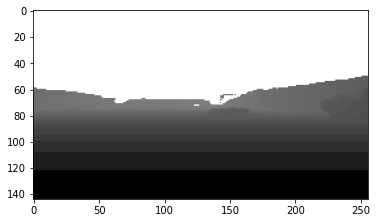

ValueError: only one element tensors can be converted to Python scalars

In [46]:
tst = input_img[0].numpy()
tst = np.moveaxis(tst, 0, -1)[0]
plt.imshow(tst, cmap="gray")
plt.show()
print(gt.item())

# Network

In [14]:
class NavNet(nn.Module):
    def __init__(self):
        super(NavNet, self).__init__()

        self.relu = nn.ReLU(inplace=True)

        self.conv3d_1_1 = nn.Conv3d(1, 8, 3, stride=1, padding='same') 
        self.conv3d_1_2 = nn.Conv3d(8, 8, 3, stride=1, padding='same', dilation=1, groups=1, bias=True, padding_mode='zeros') 
        self.conv3d_2_1 = nn.Conv3d(8, 16, 3, stride=1, padding='same', dilation=1, groups=1, bias=True, padding_mode='zeros') 
        self.conv3d_2_2 = nn.Conv3d(16, 16, 3, stride=1, padding='same', dilation=1, groups=1, bias=True, padding_mode='zeros') 
        self.fc1 = nn.Linear(1179648, 100, bias=True)
        self.fc2 = nn.Linear(100, 100, bias=True)
        self.fc3 = nn.Linear(100, 3, bias=True)

        self.max = nn.AdaptiveAvgPool3d((72,128,8)) 

    def forward(self, x):
        source = []
        source.append(x)
#         print("input: ",x.shape[-1])
#         print("input: ",x.shape)
        x1 = self.relu(self.conv3d_1_1(x))
#         print("output1: ",x1.shape)
        x2 = self.relu(self.conv3d_1_2(x1))
#         print("output2: ",x2.shape)


        max1 = self.max(x2)
#         print("output max1: ",max1.shape)
   
    
        x3 = self.relu(self.conv3d_2_1(max1))
#         print("output3: ",x3.shape)
        x4 = self.relu(self.conv3d_2_2(x3))
#         print("output4: ",x4.shape)

        # concat3 = torch.cat((x1,x2,x3,x4),1)
#         print("output5: ",torch.flatten(x4).shape)
        x5 = self.relu(self.fc1(torch.flatten(x4)))
#         print("output5: ",x5.shape)
        x6 = self.relu(self.fc2(x5))
        x7 = self.relu(self.fc3(x6))
        max_index = (x7 == torch.max(x7).item()).nonzero(as_tuple=True)[0]

        return max_index, x7

# Training

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [49]:
import torch.optim as optim

In [51]:
model = NavNet().to(device)
loss = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(NavNet().parameters(), lr=0.0001, weight_decay=0)
optimizer = optim.SGD(model.parameters(), lr=0.00005, momentum=0.7)

In [52]:
l = len(rgb_list)
loss_file = open('L:\\BOUDIAF\\Nav\\model006\\read_me.txt', 'a')
loss_file.truncate(0) #Delete everything in the txt file
for epoch in range(10):
    print("**************** epoch ", str(epoch), "****************")
    for idx, (input_img, gt) in enumerate(train_loader):
        torch.cuda.empty_cache()
        optimizer.zero_grad()
        avg_loss = 0
        for  x,y in zip(input_img, gt):
            x = torch.unsqueeze(x, 0)
            y = torch.unsqueeze(y, 0)
            x = x.to(device)
            direction, output = model(x)
            y = y.to(device)
            lss = loss(torch.unsqueeze(output, 0), y)
            avg_loss += lss.item()
            lss.backward()
            optimizer.step()
            if(y.item() == 0):
                loss_file.write('class0:'+ str(round(lss.item(),3)) +'\n') #Write into file
            elif(y.item() == 1):
                loss_file.write('class1:'+ str(round(lss.item(),3)) +'\n') #Write into file
            elif(y.item() == 2):
                loss_file.write('class2:'+ str(round(lss.item(),3)) +'\n') #Write into file
        print(round(idx*100/l,2), '%   loss:',  round(avg_loss,3))
    torch.save(model.state_dict(), "L:\\BOUDIAF\\Nav\\model006\\" + "Epoch" + str(epoch) + '.pth') 
loss_file.close()

**************** epoch  0 ****************
0.0 %   loss: 8.482
0.0 %   loss: 8.756
0.01 %   loss: 8.907
0.01 %   loss: 8.728
0.01 %   loss: 8.674
0.01 %   loss: 8.773
0.02 %   loss: 8.905
0.02 %   loss: 8.998
0.02 %   loss: 8.753
0.02 %   loss: 8.863
0.03 %   loss: 8.374
0.03 %   loss: 8.517
0.03 %   loss: 8.752
0.03 %   loss: 8.349
0.04 %   loss: 8.634
0.04 %   loss: 8.452
0.04 %   loss: 8.612
0.04 %   loss: 8.585
0.05 %   loss: 8.262
0.05 %   loss: 8.598
0.05 %   loss: 8.414
0.06 %   loss: 8.766
0.06 %   loss: 8.581
0.06 %   loss: 8.401
0.06 %   loss: 8.76
0.07 %   loss: 8.759
0.07 %   loss: 8.759
0.07 %   loss: 8.759
0.07 %   loss: 8.945
0.08 %   loss: 8.201
0.08 %   loss: 7.995
0.08 %   loss: 8.959
0.08 %   loss: 8.36
0.09 %   loss: 8.759
0.09 %   loss: 8.76
0.09 %   loss: 8.76
0.1 %   loss: 8.554
0.1 %   loss: 8.759
0.1 %   loss: 8.76
0.1 %   loss: 8.759
0.11 %   loss: 8.759
0.11 %   loss: 8.553
0.11 %   loss: 8.759
0.11 %   loss: 8.135
0.12 %   loss: 8.331
0.12 %   loss: 8.099
0.

1.04 %   loss: 7.673
1.04 %   loss: 9.614
1.04 %   loss: 7.626
1.05 %   loss: 9.397
1.05 %   loss: 7.546
1.05 %   loss: 10.294
1.05 %   loss: 9.252
1.06 %   loss: 8.82
1.06 %   loss: 8.014
1.06 %   loss: 8.309
1.06 %   loss: 8.768
1.07 %   loss: 8.948
1.07 %   loss: 8.18
1.07 %   loss: 8.298
1.07 %   loss: 7.769
1.08 %   loss: 8.766
1.08 %   loss: 9.374
1.08 %   loss: 8.32
1.08 %   loss: 8.523
1.09 %   loss: 7.86
1.09 %   loss: 9.237
1.09 %   loss: 9.567
1.1 %   loss: 8.699
1.1 %   loss: 7.92
1.1 %   loss: 9.096
1.1 %   loss: 9.434
1.11 %   loss: 8.799
1.11 %   loss: 8.161
1.11 %   loss: 8.478
1.11 %   loss: 8.159
1.12 %   loss: 9.029
1.12 %   loss: 7.908
1.12 %   loss: 8.43
1.12 %   loss: 7.855
1.13 %   loss: 7.506
1.13 %   loss: 8.05
1.13 %   loss: 8.83
1.14 %   loss: 8.827
1.14 %   loss: 8.397
1.14 %   loss: 6.979
1.14 %   loss: 8.09
1.15 %   loss: 9.295
1.15 %   loss: 7.681
1.15 %   loss: 7.673
1.15 %   loss: 9.284
1.16 %   loss: 9.55
1.16 %   loss: 7.673
1.16 %   loss: 8.409
1.16 

2.08 %   loss: 7.972
2.08 %   loss: 8.935
2.09 %   loss: 8.094
2.09 %   loss: 8.95
2.09 %   loss: 8.223
2.1 %   loss: 8.368
2.1 %   loss: 9.232
2.1 %   loss: 7.285
2.1 %   loss: 8.204
2.11 %   loss: 8.975
2.11 %   loss: 8.522
2.11 %   loss: 9.523
2.11 %   loss: 7.841
2.12 %   loss: 9.451
2.12 %   loss: 9.097
2.12 %   loss: 7.415
2.12 %   loss: 8.908
2.13 %   loss: 8.387
2.13 %   loss: 9.163
2.13 %   loss: 8.523
2.14 %   loss: 7.873
2.14 %   loss: 6.981
2.14 %   loss: 8.832
2.14 %   loss: 9.564
2.15 %   loss: 8.241
2.15 %   loss: 8.368
2.15 %   loss: 7.328
2.15 %   loss: 7.241
2.16 %   loss: 9.216
2.16 %   loss: 9.0
2.16 %   loss: 8.683
2.16 %   loss: 8.646
2.17 %   loss: 8.376
2.17 %   loss: 8.572
2.17 %   loss: 7.927
2.17 %   loss: 8.354
2.18 %   loss: 9.045
2.18 %   loss: 7.526
2.18 %   loss: 8.644
2.19 %   loss: 7.205
2.19 %   loss: 7.113
2.19 %   loss: 10.358
2.19 %   loss: 8.353
2.2 %   loss: 7.452
2.2 %   loss: 7.887
2.2 %   loss: 10.608
2.2 %   loss: 8.559
2.21 %   loss: 7.96
2.

3.12 %   loss: 9.075
3.13 %   loss: 9.063
3.13 %   loss: 8.429
3.13 %   loss: 6.697
3.14 %   loss: 7.81
3.14 %   loss: 8.155
3.14 %   loss: 8.774
3.14 %   loss: 7.396
3.15 %   loss: 8.021
3.15 %   loss: 7.042
3.15 %   loss: 9.807
3.15 %   loss: 7.703
3.16 %   loss: 9.072
3.16 %   loss: 7.008
3.16 %   loss: 8.55
3.16 %   loss: 7.462
3.17 %   loss: 10.127
3.17 %   loss: 8.634
3.17 %   loss: 8.385
3.17 %   loss: 8.168
3.18 %   loss: 7.278
3.18 %   loss: 9.967
3.18 %   loss: 6.589
3.19 %   loss: 8.847
3.19 %   loss: 7.908
3.19 %   loss: 9.086
3.19 %   loss: 7.65
3.2 %   loss: 9.128
3.2 %   loss: 7.892
3.2 %   loss: 9.334
3.2 %   loss: 10.01
3.21 %   loss: 8.17
3.21 %   loss: 9.012
3.21 %   loss: 8.816
3.21 %   loss: 10.244
3.22 %   loss: 8.949
3.22 %   loss: 9.361
3.22 %   loss: 8.515
3.23 %   loss: 8.787
3.23 %   loss: 8.381
3.23 %   loss: 8.878
3.23 %   loss: 9.154
3.24 %   loss: 7.481
3.24 %   loss: 7.664
3.24 %   loss: 8.559
3.24 %   loss: 9.658
3.25 %   loss: 8.721
3.25 %   loss: 8.95

4.17 %   loss: 8.353
4.17 %   loss: 6.138
4.17 %   loss: 8.496
4.17 %   loss: 8.945
4.18 %   loss: 9.836
4.18 %   loss: 10.021
4.18 %   loss: 7.997
4.19 %   loss: 9.286
4.19 %   loss: 9.268
4.19 %   loss: 8.364
4.19 %   loss: 8.267
4.2 %   loss: 7.361
4.2 %   loss: 6.149
4.2 %   loss: 9.312
4.2 %   loss: 8.836
4.21 %   loss: 8.445
4.21 %   loss: 8.451
4.21 %   loss: 8.053
4.21 %   loss: 8.901
4.22 %   loss: 8.398
4.22 %   loss: 9.2
4.22 %   loss: 9.469
4.23 %   loss: 8.437
4.23 %   loss: 9.17
4.23 %   loss: 8.087
4.23 %   loss: 8.411
4.24 %   loss: 7.016
4.24 %   loss: 7.315
4.24 %   loss: 8.422
4.24 %   loss: 9.541
4.25 %   loss: 7.793
4.25 %   loss: 8.386
4.25 %   loss: 7.542
4.25 %   loss: 10.545
4.26 %   loss: 9.557
4.26 %   loss: 8.068
4.26 %   loss: 9.461
4.26 %   loss: 8.079
4.27 %   loss: 8.05
4.27 %   loss: 8.464
4.27 %   loss: 7.715
4.28 %   loss: 7.31
4.28 %   loss: 7.563
4.28 %   loss: 8.946
4.28 %   loss: 9.139
4.29 %   loss: 7.316
4.29 %   loss: 7.598
4.29 %   loss: 9.234

5.21 %   loss: 7.666
5.21 %   loss: 9.06
5.21 %   loss: 8.6
5.22 %   loss: 8.565
5.22 %   loss: 8.495
5.22 %   loss: 8.937
5.23 %   loss: 7.329
5.23 %   loss: 9.925
5.23 %   loss: 9.219
5.23 %   loss: 8.28
5.24 %   loss: 9.382
5.24 %   loss: 8.665
5.24 %   loss: 8.327
5.24 %   loss: 6.739
5.25 %   loss: 9.754
5.25 %   loss: 7.213
5.25 %   loss: 7.143
5.25 %   loss: 8.917
5.26 %   loss: 6.655
5.26 %   loss: 7.512
5.26 %   loss: 9.934
5.26 %   loss: 7.966
5.27 %   loss: 9.305
5.27 %   loss: 8.775
5.27 %   loss: 9.328
5.28 %   loss: 7.242
5.28 %   loss: 10.025
5.28 %   loss: 8.811
5.28 %   loss: 9.196
5.29 %   loss: 9.78
5.29 %   loss: 8.496
5.29 %   loss: 7.461
5.29 %   loss: 9.153
5.3 %   loss: 7.035
5.3 %   loss: 8.753
5.3 %   loss: 7.714
5.3 %   loss: 8.764
5.31 %   loss: 7.758
5.31 %   loss: 9.527
5.31 %   loss: 7.057
5.32 %   loss: 8.799
5.32 %   loss: 9.139
5.32 %   loss: 8.778
5.32 %   loss: 8.777
5.33 %   loss: 9.049
5.33 %   loss: 9.387
5.33 %   loss: 9.016
5.33 %   loss: 8.296


6.25 %   loss: 6.578
6.25 %   loss: 8.795
6.26 %   loss: 9.228
6.26 %   loss: 8.383
6.26 %   loss: 8.78
6.27 %   loss: 9.301
6.27 %   loss: 8.811
6.27 %   loss: 9.085
6.27 %   loss: 8.76
6.28 %   loss: 7.638
6.28 %   loss: 8.86
6.28 %   loss: 8.057
6.28 %   loss: 8.363
6.29 %   loss: 8.181
6.29 %   loss: 8.319
6.29 %   loss: 8.096
6.29 %   loss: 6.849
6.3 %   loss: 7.307
6.3 %   loss: 7.919
6.3 %   loss: 8.5
6.3 %   loss: 9.692
6.31 %   loss: 9.356
6.31 %   loss: 8.769
6.31 %   loss: 7.469
6.32 %   loss: 8.516
6.32 %   loss: 9.282
6.32 %   loss: 7.157
6.32 %   loss: 6.647
6.33 %   loss: 8.109
6.33 %   loss: 8.036
6.33 %   loss: 6.796
6.33 %   loss: 7.968
6.34 %   loss: 7.957
6.34 %   loss: 8.854
6.34 %   loss: 8.027
6.34 %   loss: 9.785
6.35 %   loss: 8.018
6.35 %   loss: 9.712
6.35 %   loss: 9.228
6.36 %   loss: 9.599
6.36 %   loss: 8.415
6.36 %   loss: 9.904
6.36 %   loss: 8.046
6.37 %   loss: 8.103
6.37 %   loss: 7.716
6.37 %   loss: 7.697
6.37 %   loss: 7.682
6.38 %   loss: 8.695
6

7.29 %   loss: 8.44
7.3 %   loss: 6.865
7.3 %   loss: 8.424
7.3 %   loss: 9.23
7.3 %   loss: 7.605
7.31 %   loss: 8.021
7.31 %   loss: 7.957
7.31 %   loss: 6.268
7.32 %   loss: 9.899
7.32 %   loss: 7.481
7.32 %   loss: 9.761
7.32 %   loss: 8.022
7.33 %   loss: 8.481
7.33 %   loss: 7.993
7.33 %   loss: 7.958
7.33 %   loss: 8.88
7.34 %   loss: 10.84
7.34 %   loss: 7.971
7.34 %   loss: 7.646
7.34 %   loss: 7.161
7.35 %   loss: 7.25
7.35 %   loss: 8.038
7.35 %   loss: 9.002
7.36 %   loss: 7.94
7.36 %   loss: 7.923
7.36 %   loss: 7.536
7.36 %   loss: 9.293
7.37 %   loss: 7.033
7.37 %   loss: 10.091
7.37 %   loss: 7.588
7.37 %   loss: 7.868
7.38 %   loss: 8.673
7.38 %   loss: 8.116
7.38 %   loss: 8.349
7.38 %   loss: 7.644
7.39 %   loss: 9.073
7.39 %   loss: 9.32
7.39 %   loss: 7.426
7.39 %   loss: 9.073
7.4 %   loss: 8.353
7.4 %   loss: 8.844
7.4 %   loss: 8.349
7.41 %   loss: 7.441
7.41 %   loss: 7.889
7.41 %   loss: 8.115
7.41 %   loss: 8.591
7.42 %   loss: 7.786
7.42 %   loss: 9.154
7.42

8.34 %   loss: 8.433
8.34 %   loss: 9.073
8.34 %   loss: 8.433
8.34 %   loss: 8.73
8.35 %   loss: 9.017
8.35 %   loss: 9.047
8.35 %   loss: 9.319
8.36 %   loss: 8.735
8.36 %   loss: 9.013
8.36 %   loss: 8.429
8.36 %   loss: 8.429
8.37 %   loss: 8.155
8.37 %   loss: 7.532
8.37 %   loss: 7.799
8.37 %   loss: 8.708
8.38 %   loss: 8.424
8.38 %   loss: 7.21
8.38 %   loss: 7.133
8.38 %   loss: 7.054
8.39 %   loss: 9.169
8.39 %   loss: 9.487
8.39 %   loss: 7.742
8.39 %   loss: 7.72
8.4 %   loss: 7.348
8.4 %   loss: 7.299
8.4 %   loss: 9.168
8.41 %   loss: 7.266
8.41 %   loss: 8.411
8.41 %   loss: 8.825
8.41 %   loss: 8.808
8.42 %   loss: 9.621
8.42 %   loss: 8.761
8.42 %   loss: 8.37
8.42 %   loss: 8.432
8.43 %   loss: 8.819
8.43 %   loss: 8.419
8.43 %   loss: 9.483
8.43 %   loss: 8.091
8.44 %   loss: 8.094
8.44 %   loss: 7.678
8.44 %   loss: 9.524
8.45 %   loss: 8.74
8.45 %   loss: 8.082
8.45 %   loss: 6.571
8.45 %   loss: 6.854
8.46 %   loss: 8.4
8.46 %   loss: 7.173
8.46 %   loss: 9.279
8.

9.38 %   loss: 8.34
9.38 %   loss: 8.466
9.38 %   loss: 8.431
9.39 %   loss: 7.965
9.39 %   loss: 9.027
9.39 %   loss: 7.264
9.39 %   loss: 8.108
9.4 %   loss: 8.817
9.4 %   loss: 7.78
9.4 %   loss: 8.099
9.41 %   loss: 10.961
9.41 %   loss: 10.245
9.41 %   loss: 8.878
9.41 %   loss: 8.744
9.42 %   loss: 9.84
9.42 %   loss: 8.361
9.42 %   loss: 9.023
9.42 %   loss: 9.274
9.43 %   loss: 7.387
9.43 %   loss: 8.468
9.43 %   loss: 8.483
9.43 %   loss: 8.7
9.44 %   loss: 8.461
9.44 %   loss: 9.225
9.44 %   loss: 8.721
9.45 %   loss: 8.251
9.45 %   loss: 9.313
9.45 %   loss: 8.204
9.45 %   loss: 8.976
9.46 %   loss: 9.3
9.46 %   loss: 7.557
9.46 %   loss: 7.589
9.46 %   loss: 7.857
9.47 %   loss: 9.326
9.47 %   loss: 7.783
9.47 %   loss: 7.817
9.47 %   loss: 8.361
9.48 %   loss: 8.072
9.48 %   loss: 9.734
9.48 %   loss: 7.455
9.48 %   loss: 8.312
9.49 %   loss: 8.457
9.49 %   loss: 9.374
9.49 %   loss: 7.978
9.5 %   loss: 7.382
9.5 %   loss: 7.604
9.5 %   loss: 9.467
9.5 %   loss: 7.738
9.51

10.4 %   loss: 9.356
10.41 %   loss: 8.683
10.41 %   loss: 8.242
10.41 %   loss: 7.918
10.41 %   loss: 7.465
10.42 %   loss: 8.952
10.42 %   loss: 7.32
10.42 %   loss: 7.537
10.42 %   loss: 8.384
10.43 %   loss: 7.81
10.43 %   loss: 7.762
10.43 %   loss: 8.669
10.43 %   loss: 6.821
10.44 %   loss: 8.925
10.44 %   loss: 8.871
10.44 %   loss: 8.504
10.45 %   loss: 8.189
10.45 %   loss: 7.993
10.45 %   loss: 7.544
10.45 %   loss: 8.658
10.46 %   loss: 8.634
10.46 %   loss: 8.0
10.46 %   loss: 8.27
10.46 %   loss: 7.884
10.47 %   loss: 7.924
10.47 %   loss: 8.642
10.47 %   loss: 7.668
10.47 %   loss: 7.006
10.48 %   loss: 9.689
10.48 %   loss: 7.998
10.48 %   loss: 7.85
10.48 %   loss: 6.967
10.49 %   loss: 7.969
10.49 %   loss: 7.141
10.49 %   loss: 7.86
10.5 %   loss: 5.826
10.5 %   loss: 5.835
10.5 %   loss: 9.908
10.5 %   loss: 7.441
10.51 %   loss: 8.784
10.51 %   loss: 7.007
10.51 %   loss: 8.095
10.51 %   loss: 7.262
10.52 %   loss: 6.798
10.52 %   loss: 8.191
10.52 %   loss: 7.147


11.4 %   loss: 6.743
11.4 %   loss: 5.239
11.4 %   loss: 7.572
11.41 %   loss: 7.615
11.41 %   loss: 5.79
11.41 %   loss: 4.313
11.41 %   loss: 6.351
11.42 %   loss: 4.689
11.42 %   loss: 6.04
11.42 %   loss: 7.374
11.42 %   loss: 4.243
11.43 %   loss: 9.535
11.43 %   loss: 8.068
11.43 %   loss: 4.209
11.43 %   loss: 7.264
11.44 %   loss: 5.002
11.44 %   loss: 7.735
11.44 %   loss: 4.946
11.45 %   loss: 3.113
11.45 %   loss: 7.442
11.45 %   loss: 4.141
11.45 %   loss: 7.097
11.46 %   loss: 7.164
11.46 %   loss: 5.373
11.46 %   loss: 3.715
11.46 %   loss: 4.303
11.47 %   loss: 7.2
11.47 %   loss: 10.086
11.47 %   loss: 10.125
11.47 %   loss: 7.013
11.48 %   loss: 6.452
11.48 %   loss: 6.916
11.48 %   loss: 6.142
11.49 %   loss: 6.952
11.49 %   loss: 5.497
11.49 %   loss: 6.098
11.49 %   loss: 4.563
11.5 %   loss: 7.672
11.5 %   loss: 5.703
11.5 %   loss: 7.959
11.5 %   loss: 5.709
11.51 %   loss: 5.453
11.51 %   loss: 3.849
11.51 %   loss: 5.897
11.51 %   loss: 3.161
11.52 %   loss: 4.3

12.39 %   loss: 3.927
12.4 %   loss: 4.82
12.4 %   loss: 3.125
12.4 %   loss: 9.04
12.4 %   loss: 4.881
12.41 %   loss: 6.896
12.41 %   loss: 4.469
12.41 %   loss: 2.898
12.41 %   loss: 5.214
12.42 %   loss: 7.831
12.42 %   loss: 7.316
12.42 %   loss: 5.271
12.42 %   loss: 5.945
12.43 %   loss: 5.608
12.43 %   loss: 3.86
12.43 %   loss: 5.653
12.43 %   loss: 9.621
12.44 %   loss: 5.427
12.44 %   loss: 4.936
12.44 %   loss: 5.075
12.45 %   loss: 6.544
12.45 %   loss: 3.437
12.45 %   loss: 3.999
12.45 %   loss: 9.421
12.46 %   loss: 8.853
12.46 %   loss: 5.786
12.46 %   loss: 8.053
12.46 %   loss: 4.155
12.47 %   loss: 5.255
12.47 %   loss: 6.698
12.47 %   loss: 5.602
12.47 %   loss: 5.216
12.48 %   loss: 5.535
12.48 %   loss: 6.426
12.48 %   loss: 3.621
12.49 %   loss: 3.038
12.49 %   loss: 4.242
12.49 %   loss: 3.45
12.49 %   loss: 3.301
**************** epoch  1 ****************
0.0 %   loss: 2.412
0.0 %   loss: 8.443
0.01 %   loss: 3.656
0.01 %   loss: 6.304
0.01 %   loss: 2.503
0.01

0.93 %   loss: 10.0
0.93 %   loss: 5.735
0.93 %   loss: 8.47
0.94 %   loss: 3.048
0.94 %   loss: 2.901
0.94 %   loss: 5.512
0.94 %   loss: 4.84
0.95 %   loss: 3.037
0.95 %   loss: 5.369
0.95 %   loss: 6.561
0.96 %   loss: 4.719
0.96 %   loss: 4.331
0.96 %   loss: 3.741
0.96 %   loss: 4.981
0.97 %   loss: 6.806
0.97 %   loss: 9.244
0.97 %   loss: 7.368
0.97 %   loss: 4.463
0.98 %   loss: 4.809
0.98 %   loss: 8.296
0.98 %   loss: 7.217
0.98 %   loss: 6.024
0.99 %   loss: 4.706
0.99 %   loss: 2.868
0.99 %   loss: 2.825
0.99 %   loss: 6.489
1.0 %   loss: 4.832
1.0 %   loss: 3.861
1.0 %   loss: 8.526
1.01 %   loss: 7.336
1.01 %   loss: 4.191
1.01 %   loss: 3.891
1.01 %   loss: 6.307
1.02 %   loss: 4.008
1.02 %   loss: 5.782
1.02 %   loss: 4.217
1.02 %   loss: 7.262
1.03 %   loss: 6.287
1.03 %   loss: 6.2
1.03 %   loss: 4.076
1.03 %   loss: 2.823
1.04 %   loss: 2.543
1.04 %   loss: 4.112
1.04 %   loss: 4.395
1.05 %   loss: 5.452
1.05 %   loss: 5.898
1.05 %   loss: 7.487
1.05 %   loss: 13.094

1.97 %   loss: 9.067
1.97 %   loss: 6.144
1.98 %   loss: 4.374
1.98 %   loss: 5.096
1.98 %   loss: 3.391
1.98 %   loss: 4.229
1.99 %   loss: 8.927
1.99 %   loss: 5.157
1.99 %   loss: 6.672
1.99 %   loss: 4.869
2.0 %   loss: 4.665
2.0 %   loss: 4.143
2.0 %   loss: 4.77
2.01 %   loss: 6.575
2.01 %   loss: 7.671
2.01 %   loss: 5.855
2.01 %   loss: 6.892
2.02 %   loss: 7.167
2.02 %   loss: 5.465
2.02 %   loss: 4.925
2.02 %   loss: 6.696
2.03 %   loss: 6.17
2.03 %   loss: 4.291
2.03 %   loss: 5.494
2.03 %   loss: 4.284
2.04 %   loss: 4.875
2.04 %   loss: 6.336
2.04 %   loss: 4.407
2.05 %   loss: 5.739
2.05 %   loss: 7.122
2.05 %   loss: 5.239
2.05 %   loss: 3.607
2.06 %   loss: 5.367
2.06 %   loss: 5.151
2.06 %   loss: 8.711
2.06 %   loss: 5.26
2.07 %   loss: 6.522
2.07 %   loss: 3.255
2.07 %   loss: 5.774
2.07 %   loss: 4.898
2.08 %   loss: 5.496
2.08 %   loss: 5.624
2.08 %   loss: 5.301
2.08 %   loss: 4.119
2.09 %   loss: 5.921
2.09 %   loss: 2.587
2.09 %   loss: 4.662
2.1 %   loss: 5.129

3.01 %   loss: 3.298
3.02 %   loss: 7.952
3.02 %   loss: 4.538
3.02 %   loss: 8.279
3.02 %   loss: 8.907
3.03 %   loss: 5.423
3.03 %   loss: 5.973
3.03 %   loss: 6.441
3.03 %   loss: 7.317
3.04 %   loss: 6.598
3.04 %   loss: 5.486
3.04 %   loss: 4.996
3.05 %   loss: 6.286
3.05 %   loss: 5.388
3.05 %   loss: 6.474
3.05 %   loss: 5.901
3.06 %   loss: 3.932
3.06 %   loss: 4.133
3.06 %   loss: 4.339
3.06 %   loss: 2.501
3.07 %   loss: 4.738
3.07 %   loss: 10.707
3.07 %   loss: 7.294
3.07 %   loss: 5.499
3.08 %   loss: 5.299
3.08 %   loss: 5.741
3.08 %   loss: 2.566
3.08 %   loss: 5.566
3.09 %   loss: 5.314
3.09 %   loss: 4.901
3.09 %   loss: 6.7
3.1 %   loss: 6.575
3.1 %   loss: 7.145
3.1 %   loss: 3.888
3.1 %   loss: 3.35
3.11 %   loss: 6.325
3.11 %   loss: 6.935
3.11 %   loss: 5.79
3.11 %   loss: 5.811
3.12 %   loss: 4.238
3.12 %   loss: 11.05
3.12 %   loss: 3.887
3.12 %   loss: 8.917
3.13 %   loss: 5.741
3.13 %   loss: 3.784
3.13 %   loss: 7.809
3.14 %   loss: 6.019
3.14 %   loss: 3.635

4.06 %   loss: 5.428
4.06 %   loss: 3.335
4.06 %   loss: 6.474
4.06 %   loss: 2.682
4.07 %   loss: 5.656
4.07 %   loss: 4.402
4.07 %   loss: 5.113
4.07 %   loss: 5.525
4.08 %   loss: 3.31
4.08 %   loss: 1.967
4.08 %   loss: 3.239
4.08 %   loss: 5.829
4.09 %   loss: 2.876
4.09 %   loss: 2.581
4.09 %   loss: 3.243
4.1 %   loss: 9.326
4.1 %   loss: 4.597
4.1 %   loss: 2.998
4.1 %   loss: 3.316
4.11 %   loss: 6.771
4.11 %   loss: 4.023
4.11 %   loss: 8.57
4.11 %   loss: 3.405
4.12 %   loss: 4.88
4.12 %   loss: 4.828
4.12 %   loss: 4.695
4.12 %   loss: 3.795
4.13 %   loss: 5.803
4.13 %   loss: 5.454
4.13 %   loss: 3.68
4.14 %   loss: 2.753
4.14 %   loss: 3.225
4.14 %   loss: 6.717
4.14 %   loss: 7.493
4.15 %   loss: 4.768
4.15 %   loss: 2.271
4.15 %   loss: 8.877
4.15 %   loss: 5.499
4.16 %   loss: 5.777
4.16 %   loss: 4.823
4.16 %   loss: 5.363
4.16 %   loss: 4.985
4.17 %   loss: 4.609
4.17 %   loss: 7.758
4.17 %   loss: 5.012
4.17 %   loss: 4.245
4.18 %   loss: 3.831
4.18 %   loss: 4.032


5.1 %   loss: 3.234
5.1 %   loss: 7.374
5.11 %   loss: 4.157
5.11 %   loss: 7.218
5.11 %   loss: 2.666
5.11 %   loss: 9.052
5.12 %   loss: 4.802
5.12 %   loss: 4.654
5.12 %   loss: 3.647
5.12 %   loss: 5.48
5.13 %   loss: 6.511
5.13 %   loss: 2.742
5.13 %   loss: 5.174
5.14 %   loss: 6.349
5.14 %   loss: 5.963
5.14 %   loss: 5.592
5.14 %   loss: 2.469
5.15 %   loss: 4.012
5.15 %   loss: 4.758
5.15 %   loss: 3.485
5.15 %   loss: 6.431
5.16 %   loss: 5.505
5.16 %   loss: 6.549
5.16 %   loss: 5.196
5.16 %   loss: 7.955
5.17 %   loss: 3.808
5.17 %   loss: 2.858
5.17 %   loss: 3.917
5.18 %   loss: 3.093
5.18 %   loss: 4.177
5.18 %   loss: 6.427
5.18 %   loss: 4.767
5.19 %   loss: 4.428
5.19 %   loss: 2.579
5.19 %   loss: 7.69
5.19 %   loss: 4.894
5.2 %   loss: 4.618
5.2 %   loss: 4.414
5.2 %   loss: 2.252
5.2 %   loss: 6.344
5.21 %   loss: 7.865
5.21 %   loss: 4.064
5.21 %   loss: 8.825
5.21 %   loss: 4.976
5.22 %   loss: 5.596
5.22 %   loss: 6.528
5.22 %   loss: 5.445
5.23 %   loss: 7.26
5

6.14 %   loss: 5.368
6.15 %   loss: 4.861
6.15 %   loss: 3.686
6.15 %   loss: 3.25
6.15 %   loss: 3.345
6.16 %   loss: 5.306
6.16 %   loss: 4.189
6.16 %   loss: 6.679
6.16 %   loss: 4.411
6.17 %   loss: 4.362
6.17 %   loss: 3.348
6.17 %   loss: 3.597
6.18 %   loss: 6.833
6.18 %   loss: 9.408
6.18 %   loss: 4.544
6.18 %   loss: 6.238
6.19 %   loss: 3.779
6.19 %   loss: 3.864
6.19 %   loss: 8.291
6.19 %   loss: 4.221
6.2 %   loss: 6.232
6.2 %   loss: 3.878
6.2 %   loss: 5.577
6.2 %   loss: 2.874
6.21 %   loss: 5.469
6.21 %   loss: 2.444
6.21 %   loss: 2.14
6.21 %   loss: 6.127
6.22 %   loss: 5.426
6.22 %   loss: 3.522
6.22 %   loss: 2.22
6.23 %   loss: 3.629
6.23 %   loss: 6.08
6.23 %   loss: 4.13
6.23 %   loss: 5.655
6.24 %   loss: 10.466
6.24 %   loss: 6.435
6.24 %   loss: 3.129
6.24 %   loss: 8.015
6.25 %   loss: 8.156
6.25 %   loss: 7.633
6.25 %   loss: 3.866
6.25 %   loss: 5.173
6.26 %   loss: 4.338
6.26 %   loss: 4.499
6.26 %   loss: 3.463
6.27 %   loss: 4.19
6.27 %   loss: 3.457
6

7.19 %   loss: 7.554
7.19 %   loss: 3.933
7.19 %   loss: 4.666
7.19 %   loss: 7.093
7.2 %   loss: 5.712
7.2 %   loss: 4.433
7.2 %   loss: 5.673
7.2 %   loss: 5.397
7.21 %   loss: 7.33
7.21 %   loss: 5.023
7.21 %   loss: 4.526
7.21 %   loss: 7.823
7.22 %   loss: 3.643
7.22 %   loss: 3.711
7.22 %   loss: 5.953
7.23 %   loss: 4.045
7.23 %   loss: 4.995
7.23 %   loss: 5.118
7.23 %   loss: 4.158
7.24 %   loss: 10.346
7.24 %   loss: 4.444
7.24 %   loss: 3.278
7.24 %   loss: 4.179
7.25 %   loss: 3.749
7.25 %   loss: 2.955
7.25 %   loss: 7.641
7.25 %   loss: 13.22
7.26 %   loss: 4.328
7.26 %   loss: 4.914
7.26 %   loss: 4.054
7.27 %   loss: 6.883
7.27 %   loss: 3.252
7.27 %   loss: 4.352
7.27 %   loss: 7.602
7.28 %   loss: 7.459
7.28 %   loss: 7.143
7.28 %   loss: 5.117
7.28 %   loss: 5.239
7.29 %   loss: 4.981
7.29 %   loss: 5.429
7.29 %   loss: 4.277
7.29 %   loss: 6.395
7.3 %   loss: 4.978
7.3 %   loss: 3.188
7.3 %   loss: 6.58
7.3 %   loss: 2.653
7.31 %   loss: 3.746
7.31 %   loss: 3.149
7

8.23 %   loss: 4.428
8.23 %   loss: 4.832
8.24 %   loss: 2.978
8.24 %   loss: 3.664
8.24 %   loss: 6.747
8.24 %   loss: 6.345
8.25 %   loss: 6.497
8.25 %   loss: 8.321
8.25 %   loss: 4.999
8.25 %   loss: 8.506
8.26 %   loss: 5.226
8.26 %   loss: 5.622
8.26 %   loss: 6.144
8.27 %   loss: 8.682
8.27 %   loss: 5.863
8.27 %   loss: 4.818
8.27 %   loss: 3.824
8.28 %   loss: 8.725
8.28 %   loss: 4.585
8.28 %   loss: 5.947
8.28 %   loss: 2.818
8.29 %   loss: 3.372
8.29 %   loss: 4.049
8.29 %   loss: 3.748
8.29 %   loss: 5.906
8.3 %   loss: 8.328
8.3 %   loss: 6.427
8.3 %   loss: 3.1
8.3 %   loss: 6.509
8.31 %   loss: 3.908
8.31 %   loss: 5.813
8.31 %   loss: 4.759
8.32 %   loss: 2.228
8.32 %   loss: 4.575
8.32 %   loss: 6.467
8.32 %   loss: 2.072
8.33 %   loss: 4.827
8.33 %   loss: 6.487
8.33 %   loss: 4.765
8.33 %   loss: 7.077
8.34 %   loss: 6.944
8.34 %   loss: 4.862
8.34 %   loss: 5.057
8.34 %   loss: 3.106
8.35 %   loss: 4.619
8.35 %   loss: 7.553
8.35 %   loss: 5.745
8.36 %   loss: 3.57

9.27 %   loss: 4.93
9.28 %   loss: 6.918
9.28 %   loss: 10.92
9.28 %   loss: 4.615
9.28 %   loss: 5.384
9.29 %   loss: 4.892
9.29 %   loss: 5.841
9.29 %   loss: 5.27
9.29 %   loss: 4.153
9.3 %   loss: 6.596
9.3 %   loss: 4.497
9.3 %   loss: 3.46
9.3 %   loss: 4.63
9.31 %   loss: 5.621
9.31 %   loss: 5.46
9.31 %   loss: 3.545
9.32 %   loss: 6.154
9.32 %   loss: 5.526
9.32 %   loss: 2.803
9.32 %   loss: 5.026
9.33 %   loss: 6.534
9.33 %   loss: 5.36
9.33 %   loss: 4.645
9.33 %   loss: 2.842
9.34 %   loss: 3.27
9.34 %   loss: 5.539
9.34 %   loss: 7.336
9.34 %   loss: 3.151
9.35 %   loss: 2.034
9.35 %   loss: 5.025
9.35 %   loss: 2.562
9.36 %   loss: 5.366
9.36 %   loss: 3.597
9.36 %   loss: 5.812
9.36 %   loss: 4.551
9.37 %   loss: 7.389
9.37 %   loss: 5.082
9.37 %   loss: 7.886
9.37 %   loss: 3.805
9.38 %   loss: 4.279
9.38 %   loss: 5.1
9.38 %   loss: 2.781
9.38 %   loss: 7.54
9.39 %   loss: 7.499
9.39 %   loss: 4.25
9.39 %   loss: 5.681
9.39 %   loss: 3.321
9.4 %   loss: 4.275
9.4 %   

10.3 %   loss: 3.415
10.31 %   loss: 9.983
10.31 %   loss: 3.068
10.31 %   loss: 8.715
10.31 %   loss: 6.117
10.32 %   loss: 5.256
10.32 %   loss: 5.347
10.32 %   loss: 2.763
10.32 %   loss: 3.64
10.33 %   loss: 4.8
10.33 %   loss: 3.391
10.33 %   loss: 5.126
10.33 %   loss: 4.92
10.34 %   loss: 8.185
10.34 %   loss: 4.178
10.34 %   loss: 8.814
10.34 %   loss: 4.807
10.35 %   loss: 4.589
10.35 %   loss: 4.44
10.35 %   loss: 9.053
10.36 %   loss: 3.081
10.36 %   loss: 5.119
10.36 %   loss: 2.806
10.36 %   loss: 3.88
10.37 %   loss: 4.94
10.37 %   loss: 5.458
10.37 %   loss: 4.059
10.37 %   loss: 3.224
10.38 %   loss: 3.461
10.38 %   loss: 5.147
10.38 %   loss: 5.116
10.38 %   loss: 3.281
10.39 %   loss: 10.98
10.39 %   loss: 1.843
10.39 %   loss: 4.809
10.4 %   loss: 3.577
10.4 %   loss: 3.04
10.4 %   loss: 7.293
10.4 %   loss: 6.302
10.41 %   loss: 5.271
10.41 %   loss: 4.335
10.41 %   loss: 5.047
10.41 %   loss: 5.337
10.42 %   loss: 5.441
10.42 %   loss: 6.099
10.42 %   loss: 3.977
1

11.3 %   loss: 4.179
11.3 %   loss: 4.86
11.3 %   loss: 3.545
11.31 %   loss: 8.187
11.31 %   loss: 3.666
11.31 %   loss: 8.99
11.31 %   loss: 3.069
11.32 %   loss: 6.281
11.32 %   loss: 6.135
11.32 %   loss: 3.253
11.32 %   loss: 4.768
11.33 %   loss: 4.797
11.33 %   loss: 1.888
11.33 %   loss: 6.779
11.33 %   loss: 5.279
11.34 %   loss: 4.181
11.34 %   loss: 3.397
11.34 %   loss: 4.229
11.34 %   loss: 4.779
11.35 %   loss: 4.739
11.35 %   loss: 6.5
11.35 %   loss: 5.731
11.36 %   loss: 3.712
11.36 %   loss: 4.176
11.36 %   loss: 5.635
11.36 %   loss: 6.071
11.37 %   loss: 7.436
11.37 %   loss: 5.287
11.37 %   loss: 4.35
11.37 %   loss: 4.031
11.38 %   loss: 4.15
11.38 %   loss: 5.017
11.38 %   loss: 8.054
11.38 %   loss: 4.271
11.39 %   loss: 6.458
11.39 %   loss: 4.985
11.39 %   loss: 2.371
11.4 %   loss: 1.787
11.4 %   loss: 4.212
11.4 %   loss: 4.694
11.4 %   loss: 3.837
11.41 %   loss: 4.668
11.41 %   loss: 5.921
11.41 %   loss: 4.517
11.41 %   loss: 3.684
11.42 %   loss: 6.542
1

12.29 %   loss: 3.386
12.29 %   loss: 3.754
12.3 %   loss: 3.285
12.3 %   loss: 5.2
12.3 %   loss: 4.45
12.31 %   loss: 3.906
12.31 %   loss: 2.595
12.31 %   loss: 2.813
12.31 %   loss: 4.48
12.32 %   loss: 2.537
12.32 %   loss: 5.319
12.32 %   loss: 7.623
12.32 %   loss: 3.108
12.33 %   loss: 6.014
12.33 %   loss: 5.061
12.33 %   loss: 9.315
12.33 %   loss: 3.146
12.34 %   loss: 3.638
12.34 %   loss: 2.92
12.34 %   loss: 4.941
12.34 %   loss: 3.52
12.35 %   loss: 4.615
12.35 %   loss: 3.967
12.35 %   loss: 3.686
12.36 %   loss: 5.533
12.36 %   loss: 3.538
12.36 %   loss: 4.165
12.36 %   loss: 3.997
12.37 %   loss: 5.335
12.37 %   loss: 3.983
12.37 %   loss: 7.043
12.37 %   loss: 2.999
12.38 %   loss: 4.031
12.38 %   loss: 4.983
12.38 %   loss: 5.358
12.38 %   loss: 3.644
12.39 %   loss: 4.151
12.39 %   loss: 3.945
12.39 %   loss: 2.884
12.4 %   loss: 1.457
12.4 %   loss: 10.252
12.4 %   loss: 5.607
12.4 %   loss: 2.681
12.41 %   loss: 3.058
12.41 %   loss: 3.607
12.41 %   loss: 6.522


0.83 %   loss: 2.025
0.83 %   loss: 3.532
0.83 %   loss: 3.074
0.83 %   loss: 5.045
0.84 %   loss: 1.936
0.84 %   loss: 6.033
0.84 %   loss: 3.025
0.84 %   loss: 2.17
0.85 %   loss: 2.415
0.85 %   loss: 9.702
0.85 %   loss: 2.756
0.85 %   loss: 9.854
0.86 %   loss: 3.288
0.86 %   loss: 4.241
0.86 %   loss: 3.325
0.87 %   loss: 4.898
0.87 %   loss: 4.603
0.87 %   loss: 3.656
0.87 %   loss: 8.514
0.88 %   loss: 11.086
0.88 %   loss: 6.776
0.88 %   loss: 5.753
0.88 %   loss: 2.973
0.89 %   loss: 8.024
0.89 %   loss: 5.659
0.89 %   loss: 3.92
0.89 %   loss: 3.263
0.9 %   loss: 7.542
0.9 %   loss: 4.047
0.9 %   loss: 2.781
0.9 %   loss: 7.092
0.91 %   loss: 4.253
0.91 %   loss: 4.637
0.91 %   loss: 6.043
0.92 %   loss: 3.831
0.92 %   loss: 4.924
0.92 %   loss: 2.605
0.92 %   loss: 6.296
0.93 %   loss: 1.863
0.93 %   loss: 5.626
0.93 %   loss: 8.842
0.93 %   loss: 6.304
0.94 %   loss: 4.338
0.94 %   loss: 3.65
0.94 %   loss: 7.292
0.94 %   loss: 4.93
0.95 %   loss: 5.711
0.95 %   loss: 3.154

1.87 %   loss: 2.485
1.87 %   loss: 3.231
1.87 %   loss: 2.335
1.88 %   loss: 4.258
1.88 %   loss: 6.385
1.88 %   loss: 5.491
1.88 %   loss: 6.559
1.89 %   loss: 5.022
1.89 %   loss: 5.838
1.89 %   loss: 5.277
1.89 %   loss: 3.483
1.9 %   loss: 5.512
1.9 %   loss: 3.402
1.9 %   loss: 6.35
1.9 %   loss: 4.759
1.91 %   loss: 2.515
1.91 %   loss: 7.468
1.91 %   loss: 5.888
1.92 %   loss: 3.125
1.92 %   loss: 5.338
1.92 %   loss: 4.262
1.92 %   loss: 5.435
1.93 %   loss: 4.984
1.93 %   loss: 5.271
1.93 %   loss: 6.413
1.93 %   loss: 6.209
1.94 %   loss: 4.159
1.94 %   loss: 4.246
1.94 %   loss: 3.948
1.94 %   loss: 5.946
1.95 %   loss: 4.094
1.95 %   loss: 4.432
1.95 %   loss: 10.641
1.96 %   loss: 4.256
1.96 %   loss: 4.908
1.96 %   loss: 8.471
1.96 %   loss: 6.45
1.97 %   loss: 5.05
1.97 %   loss: 4.008
1.97 %   loss: 4.917
1.97 %   loss: 3.256
1.98 %   loss: 8.085
1.98 %   loss: 2.934
1.98 %   loss: 5.171
1.98 %   loss: 5.704
1.99 %   loss: 4.048
1.99 %   loss: 8.208
1.99 %   loss: 4.55

2.91 %   loss: 2.859
2.92 %   loss: 4.101
2.92 %   loss: 6.248
2.92 %   loss: 3.511
2.92 %   loss: 3.533
2.93 %   loss: 3.986
2.93 %   loss: 8.583
2.93 %   loss: 3.548
2.93 %   loss: 2.575
2.94 %   loss: 2.997
2.94 %   loss: 3.757
2.94 %   loss: 6.499
2.94 %   loss: 2.344
2.95 %   loss: 2.677
2.95 %   loss: 3.934
2.95 %   loss: 3.208
2.96 %   loss: 1.492
2.96 %   loss: 9.916
2.96 %   loss: 9.779
2.96 %   loss: 3.758
2.97 %   loss: 5.078
2.97 %   loss: 2.7
2.97 %   loss: 4.12
2.97 %   loss: 4.27
2.98 %   loss: 2.529
2.98 %   loss: 8.316
2.98 %   loss: 1.796
2.98 %   loss: 5.224
2.99 %   loss: 4.491
2.99 %   loss: 3.205
2.99 %   loss: 3.593
2.99 %   loss: 3.106
3.0 %   loss: 2.972
3.0 %   loss: 7.281
3.0 %   loss: 5.877
3.01 %   loss: 3.434
3.01 %   loss: 4.53
3.01 %   loss: 6.065
3.01 %   loss: 4.446
3.02 %   loss: 4.024
3.02 %   loss: 1.601
3.02 %   loss: 6.363
3.02 %   loss: 3.674
3.03 %   loss: 4.579
3.03 %   loss: 2.1
3.03 %   loss: 4.359
3.03 %   loss: 6.456
3.04 %   loss: 6.577
3.

3.96 %   loss: 3.007
3.96 %   loss: 4.266
3.96 %   loss: 2.611
3.96 %   loss: 6.651
3.97 %   loss: 4.928
3.97 %   loss: 5.025
3.97 %   loss: 4.084
3.97 %   loss: 4.711
3.98 %   loss: 2.333
3.98 %   loss: 3.993
3.98 %   loss: 3.422
3.98 %   loss: 11.265
3.99 %   loss: 5.942
3.99 %   loss: 4.487
3.99 %   loss: 3.835
4.0 %   loss: 3.264
4.0 %   loss: 3.19
4.0 %   loss: 4.127
4.0 %   loss: 4.232
4.01 %   loss: 3.554
4.01 %   loss: 2.721
4.01 %   loss: 8.285
4.01 %   loss: 8.255
4.02 %   loss: 4.386
4.02 %   loss: 4.195
4.02 %   loss: 6.848
4.02 %   loss: 4.323
4.03 %   loss: 6.251
4.03 %   loss: 5.256
4.03 %   loss: 6.225
4.03 %   loss: 2.923
4.04 %   loss: 2.855
4.04 %   loss: 5.714
4.04 %   loss: 2.401
4.05 %   loss: 6.093
4.05 %   loss: 3.115
4.05 %   loss: 4.732
4.05 %   loss: 1.925
4.06 %   loss: 4.676
4.06 %   loss: 4.757
4.06 %   loss: 3.282
4.06 %   loss: 3.786
4.07 %   loss: 4.837
4.07 %   loss: 3.425
4.07 %   loss: 3.121
4.07 %   loss: 4.164
4.08 %   loss: 4.327
4.08 %   loss: 3.

5.0 %   loss: 3.575
5.0 %   loss: 3.513
5.0 %   loss: 3.346
5.01 %   loss: 5.404
5.01 %   loss: 5.602
5.01 %   loss: 5.664
5.01 %   loss: 3.313
5.02 %   loss: 2.42
5.02 %   loss: 4.749
5.02 %   loss: 3.09
5.02 %   loss: 5.281
5.03 %   loss: 3.359
5.03 %   loss: 3.367
5.03 %   loss: 3.803
5.03 %   loss: 7.033
5.04 %   loss: 1.277
5.04 %   loss: 4.375
5.04 %   loss: 3.682
5.05 %   loss: 3.471
5.05 %   loss: 3.142
5.05 %   loss: 3.992
5.05 %   loss: 4.553
5.06 %   loss: 4.982
5.06 %   loss: 1.813
5.06 %   loss: 3.548
5.06 %   loss: 1.284
5.07 %   loss: 5.105
5.07 %   loss: 6.995
5.07 %   loss: 2.197
5.07 %   loss: 4.168
5.08 %   loss: 2.762
5.08 %   loss: 1.752
5.08 %   loss: 3.391
5.09 %   loss: 8.964
5.09 %   loss: 4.14
5.09 %   loss: 3.214
5.09 %   loss: 3.718
5.1 %   loss: 1.362
5.1 %   loss: 6.92
5.1 %   loss: 4.123
5.1 %   loss: 3.354
5.11 %   loss: 3.266
5.11 %   loss: 2.102
5.11 %   loss: 6.264
5.11 %   loss: 3.899
5.12 %   loss: 4.484
5.12 %   loss: 4.337
5.12 %   loss: 5.47
5.12

6.04 %   loss: 6.281
6.04 %   loss: 3.037
6.05 %   loss: 3.008
6.05 %   loss: 4.556
6.05 %   loss: 6.228
6.05 %   loss: 3.401
6.06 %   loss: 2.957
6.06 %   loss: 6.041
6.06 %   loss: 4.649
6.06 %   loss: 2.913
6.07 %   loss: 5.741
6.07 %   loss: 3.75
6.07 %   loss: 3.731
6.07 %   loss: 6.802
6.08 %   loss: 5.043
6.08 %   loss: 2.364
6.08 %   loss: 3.153
6.09 %   loss: 4.021
6.09 %   loss: 2.72
6.09 %   loss: 2.717
6.09 %   loss: 7.028
6.1 %   loss: 3.364
6.1 %   loss: 1.945
6.1 %   loss: 3.498
6.1 %   loss: 2.515
6.11 %   loss: 2.961
6.11 %   loss: 4.599
6.11 %   loss: 4.779
6.11 %   loss: 6.779
6.12 %   loss: 2.943
6.12 %   loss: 4.564
6.12 %   loss: 2.448
6.12 %   loss: 2.545
6.13 %   loss: 5.824
6.13 %   loss: 3.869
6.13 %   loss: 5.75
6.14 %   loss: 7.257
6.14 %   loss: 2.162
6.14 %   loss: 5.418
6.14 %   loss: 3.819
6.15 %   loss: 5.364
6.15 %   loss: 2.346
6.15 %   loss: 4.636
6.15 %   loss: 8.132
6.16 %   loss: 3.392
6.16 %   loss: 5.44
6.16 %   loss: 3.284
6.16 %   loss: 5.543


7.08 %   loss: 3.985
7.09 %   loss: 5.931
7.09 %   loss: 6.16
7.09 %   loss: 4.87
7.09 %   loss: 3.143
7.1 %   loss: 6.412
7.1 %   loss: 4.469
7.1 %   loss: 5.858
7.1 %   loss: 5.167
7.11 %   loss: 4.345
7.11 %   loss: 1.973
7.11 %   loss: 8.449
7.11 %   loss: 3.372
7.12 %   loss: 3.079
7.12 %   loss: 5.635
7.12 %   loss: 2.659
7.12 %   loss: 4.507
7.13 %   loss: 3.709
7.13 %   loss: 2.559
7.13 %   loss: 3.457
7.14 %   loss: 2.559
7.14 %   loss: 3.784
7.14 %   loss: 4.342
7.14 %   loss: 2.291
7.15 %   loss: 6.316
7.15 %   loss: 5.411
7.15 %   loss: 3.312
7.15 %   loss: 3.306
7.16 %   loss: 3.571
7.16 %   loss: 2.788
7.16 %   loss: 2.235
7.16 %   loss: 2.14
7.17 %   loss: 4.301
7.17 %   loss: 3.039
7.17 %   loss: 7.048
7.18 %   loss: 4.627
7.18 %   loss: 2.489
7.18 %   loss: 6.125
7.18 %   loss: 3.022
7.19 %   loss: 4.626
7.19 %   loss: 8.021
7.19 %   loss: 5.314
7.19 %   loss: 4.61
7.2 %   loss: 4.472
7.2 %   loss: 3.338
7.2 %   loss: 4.699
7.2 %   loss: 5.142
7.21 %   loss: 5.174
7.21

8.13 %   loss: 6.365
8.13 %   loss: 4.887
8.13 %   loss: 5.098
8.14 %   loss: 3.914
8.14 %   loss: 4.953
8.14 %   loss: 6.471
8.14 %   loss: 3.112
8.15 %   loss: 2.388
8.15 %   loss: 6.031
8.15 %   loss: 2.371
8.15 %   loss: 2.881
8.16 %   loss: 3.112
8.16 %   loss: 4.356
8.16 %   loss: 5.301
8.16 %   loss: 4.379
8.17 %   loss: 5.904
8.17 %   loss: 4.645
8.17 %   loss: 2.49
8.18 %   loss: 4.034
8.18 %   loss: 4.6
8.18 %   loss: 2.495
8.18 %   loss: 3.754
8.19 %   loss: 3.7
8.19 %   loss: 2.911
8.19 %   loss: 2.814
8.19 %   loss: 4.856
8.2 %   loss: 4.821
8.2 %   loss: 3.207
8.2 %   loss: 2.437
8.2 %   loss: 2.664
8.21 %   loss: 9.388
8.21 %   loss: 5.683
8.21 %   loss: 2.267
8.21 %   loss: 5.779
8.22 %   loss: 6.43
8.22 %   loss: 6.499
8.22 %   loss: 2.644
8.23 %   loss: 2.655
8.23 %   loss: 5.76
8.23 %   loss: 3.774
8.23 %   loss: 0.853
8.24 %   loss: 6.921
8.24 %   loss: 5.263
8.24 %   loss: 6.538
8.24 %   loss: 1.342
8.25 %   loss: 7.417
8.25 %   loss: 5.081
8.25 %   loss: 3.635
8.2

9.17 %   loss: 3.073
9.17 %   loss: 4.56
9.18 %   loss: 4.405
9.18 %   loss: 3.561
9.18 %   loss: 3.32
9.18 %   loss: 3.288
9.19 %   loss: 3.097
9.19 %   loss: 7.522
9.19 %   loss: 2.825
9.19 %   loss: 4.71
9.2 %   loss: 2.284
9.2 %   loss: 3.298
9.2 %   loss: 9.624
9.2 %   loss: 1.883
9.21 %   loss: 1.733
9.21 %   loss: 2.536
9.21 %   loss: 5.81
9.22 %   loss: 2.876
9.22 %   loss: 8.348
9.22 %   loss: 1.93
9.22 %   loss: 2.497
9.23 %   loss: 6.389
9.23 %   loss: 1.873
9.23 %   loss: 4.176
9.23 %   loss: 5.065
9.24 %   loss: 3.821
9.24 %   loss: 2.48
9.24 %   loss: 5.987
9.24 %   loss: 6.666
9.25 %   loss: 1.656
9.25 %   loss: 1.386
9.25 %   loss: 6.074
9.25 %   loss: 1.775
9.26 %   loss: 1.949
9.26 %   loss: 8.293
9.26 %   loss: 12.022
9.27 %   loss: 4.733
9.27 %   loss: 4.251
9.27 %   loss: 5.012
9.27 %   loss: 4.179
9.28 %   loss: 4.458
9.28 %   loss: 2.258
9.28 %   loss: 4.721
9.28 %   loss: 3.991
9.29 %   loss: 4.454
9.29 %   loss: 2.225
9.29 %   loss: 6.626
9.29 %   loss: 2.608
9

10.2 %   loss: 2.002
10.21 %   loss: 6.534
10.21 %   loss: 2.839
10.21 %   loss: 5.997
10.22 %   loss: 1.968
10.22 %   loss: 2.41
10.22 %   loss: 7.47
10.22 %   loss: 6.499
10.23 %   loss: 2.116
10.23 %   loss: 3.657
10.23 %   loss: 2.654
10.23 %   loss: 6.557
10.24 %   loss: 3.68
10.24 %   loss: 6.041
10.24 %   loss: 4.003
10.24 %   loss: 2.964
10.25 %   loss: 3.558
10.25 %   loss: 5.768
10.25 %   loss: 7.716
10.25 %   loss: 3.253
10.26 %   loss: 9.683
10.26 %   loss: 2.501
10.26 %   loss: 7.097
10.27 %   loss: 2.083
10.27 %   loss: 4.014
10.27 %   loss: 5.447
10.27 %   loss: 2.371
10.28 %   loss: 3.519
10.28 %   loss: 4.938
10.28 %   loss: 4.822
10.28 %   loss: 10.106
10.29 %   loss: 3.083
10.29 %   loss: 3.051
10.29 %   loss: 2.027
10.29 %   loss: 3.537
10.3 %   loss: 4.886
10.3 %   loss: 6.26
10.3 %   loss: 2.62
10.31 %   loss: 3.035
10.31 %   loss: 4.832
10.31 %   loss: 3.895
10.31 %   loss: 4.886
10.32 %   loss: 4.003
10.32 %   loss: 2.133
10.32 %   loss: 3.604
10.32 %   loss: 6.

11.2 %   loss: 2.846
11.2 %   loss: 1.994
11.2 %   loss: 1.401
11.21 %   loss: 4.864
11.21 %   loss: 0.928
11.21 %   loss: 3.969
11.22 %   loss: 3.276
11.22 %   loss: 2.87
11.22 %   loss: 6.149
11.22 %   loss: 4.681
11.23 %   loss: 10.601
11.23 %   loss: 5.946
11.23 %   loss: 2.113
11.23 %   loss: 4.184
11.24 %   loss: 2.506
11.24 %   loss: 4.358
11.24 %   loss: 4.047
11.24 %   loss: 3.067
11.25 %   loss: 5.223
11.25 %   loss: 3.868
11.25 %   loss: 4.438
11.25 %   loss: 4.094
11.26 %   loss: 1.763
11.26 %   loss: 6.083
11.26 %   loss: 4.309
11.27 %   loss: 2.438
11.27 %   loss: 2.568
11.27 %   loss: 1.601
11.27 %   loss: 5.478
11.28 %   loss: 2.227
11.28 %   loss: 1.316
11.28 %   loss: 7.419
11.28 %   loss: 2.828
11.29 %   loss: 3.783
11.29 %   loss: 2.831
11.29 %   loss: 2.5
11.29 %   loss: 0.913
11.3 %   loss: 6.104
11.3 %   loss: 3.378
11.3 %   loss: 2.574
11.31 %   loss: 1.715
11.31 %   loss: 0.2
11.31 %   loss: 4.325
11.31 %   loss: 1.971
11.32 %   loss: 7.865
11.32 %   loss: 5.41

12.19 %   loss: 3.675
12.2 %   loss: 4.907
12.2 %   loss: 5.079
12.2 %   loss: 3.733
12.2 %   loss: 3.243
12.21 %   loss: 4.331
12.21 %   loss: 2.566
12.21 %   loss: 3.948
12.22 %   loss: 2.661
12.22 %   loss: 1.704
12.22 %   loss: 1.102
12.22 %   loss: 4.544
12.23 %   loss: 4.21
12.23 %   loss: 7.708
12.23 %   loss: 6.062
12.23 %   loss: 4.896
12.24 %   loss: 2.622
12.24 %   loss: 3.092
12.24 %   loss: 2.266
12.24 %   loss: 4.307
12.25 %   loss: 3.87
12.25 %   loss: 5.263
12.25 %   loss: 2.333
12.25 %   loss: 3.0
12.26 %   loss: 3.903
12.26 %   loss: 5.104
12.26 %   loss: 3.89
12.27 %   loss: 5.44
12.27 %   loss: 3.064
12.27 %   loss: 2.111
12.27 %   loss: 2.893
12.28 %   loss: 8.273
12.28 %   loss: 3.28
12.28 %   loss: 7.455
12.28 %   loss: 4.937
12.29 %   loss: 6.013
12.29 %   loss: 4.243
12.29 %   loss: 3.611
12.29 %   loss: 4.883
12.3 %   loss: 7.2
12.3 %   loss: 6.029
12.3 %   loss: 3.779
12.31 %   loss: 4.179
12.31 %   loss: 2.188
12.31 %   loss: 5.78
12.31 %   loss: 3.761
12.32

0.72 %   loss: 5.162
0.72 %   loss: 1.0
0.73 %   loss: 2.886
0.73 %   loss: 2.843
0.73 %   loss: 5.991
0.74 %   loss: 2.681
0.74 %   loss: 7.605
0.74 %   loss: 2.725
0.74 %   loss: 2.371
0.75 %   loss: 2.759
0.75 %   loss: 5.098
0.75 %   loss: 5.74
0.75 %   loss: 5.548
0.76 %   loss: 5.361
0.76 %   loss: 2.698
0.76 %   loss: 8.601
0.76 %   loss: 5.174
0.77 %   loss: 4.709
0.77 %   loss: 4.669
0.77 %   loss: 1.483
0.78 %   loss: 9.033
0.78 %   loss: 4.371
0.78 %   loss: 3.295
0.78 %   loss: 4.015
0.79 %   loss: 3.232
0.79 %   loss: 3.641
0.79 %   loss: 3.388
0.79 %   loss: 2.781
0.8 %   loss: 6.157
0.8 %   loss: 8.566
0.8 %   loss: 3.539
0.8 %   loss: 4.157
0.81 %   loss: 1.826
0.81 %   loss: 4.01
0.81 %   loss: 5.512
0.81 %   loss: 6.218
0.82 %   loss: 3.286
0.82 %   loss: 1.154
0.82 %   loss: 2.458
0.83 %   loss: 1.716
0.83 %   loss: 1.589
0.83 %   loss: 1.316
0.83 %   loss: 1.316
0.84 %   loss: 5.906
0.84 %   loss: 7.369
0.84 %   loss: 4.791
0.84 %   loss: 3.371
0.85 %   loss: 2.972


1.76 %   loss: 1.951
1.77 %   loss: 2.376
1.77 %   loss: 4.577
1.77 %   loss: 1.216
1.78 %   loss: 4.929
1.78 %   loss: 3.464
1.78 %   loss: 2.948
1.78 %   loss: 2.742
1.79 %   loss: 6.413
1.79 %   loss: 4.057
1.79 %   loss: 2.152
1.79 %   loss: 3.116
1.8 %   loss: 5.443
1.8 %   loss: 7.711
1.8 %   loss: 1.949
1.8 %   loss: 3.055
1.81 %   loss: 3.36
1.81 %   loss: 1.485
1.81 %   loss: 2.484
1.81 %   loss: 3.799
1.82 %   loss: 2.319
1.82 %   loss: 4.615
1.82 %   loss: 2.521
1.83 %   loss: 1.942
1.83 %   loss: 4.491
1.83 %   loss: 1.279
1.83 %   loss: 3.637
1.84 %   loss: 4.69
1.84 %   loss: 5.082
1.84 %   loss: 2.859
1.84 %   loss: 5.73
1.85 %   loss: 5.021
1.85 %   loss: 8.454
1.85 %   loss: 3.216
1.85 %   loss: 4.102
1.86 %   loss: 4.26
1.86 %   loss: 5.778
1.86 %   loss: 5.006
1.87 %   loss: 2.306
1.87 %   loss: 5.656
1.87 %   loss: 2.505
1.87 %   loss: 9.435
1.88 %   loss: 3.767
1.88 %   loss: 4.135
1.88 %   loss: 3.514
1.88 %   loss: 5.731
1.89 %   loss: 2.159
1.89 %   loss: 1.824


2.81 %   loss: 3.134
2.81 %   loss: 3.357
2.81 %   loss: 2.849
2.82 %   loss: 3.108
2.82 %   loss: 4.46
2.82 %   loss: 2.162
2.82 %   loss: 2.703
2.83 %   loss: 4.66
2.83 %   loss: 5.42
2.83 %   loss: 1.996
2.83 %   loss: 10.312
2.84 %   loss: 0.657
2.84 %   loss: 1.196
2.84 %   loss: 5.697
2.84 %   loss: 4.022
2.85 %   loss: 1.624
2.85 %   loss: 2.047
2.85 %   loss: 5.142
2.85 %   loss: 4.032
2.86 %   loss: 2.087
2.86 %   loss: 4.603
2.86 %   loss: 2.567
2.87 %   loss: 3.116
2.87 %   loss: 6.454
2.87 %   loss: 3.038
2.87 %   loss: 3.564
2.88 %   loss: 8.396
2.88 %   loss: 4.413
2.88 %   loss: 4.804
2.88 %   loss: 2.696
2.89 %   loss: 4.008
2.89 %   loss: 11.101
2.89 %   loss: 3.411
2.89 %   loss: 2.331
2.9 %   loss: 3.176
2.9 %   loss: 3.407
2.9 %   loss: 2.816
2.9 %   loss: 5.059
2.91 %   loss: 2.112
2.91 %   loss: 3.683
2.91 %   loss: 2.972
2.92 %   loss: 4.291
2.92 %   loss: 1.245
2.92 %   loss: 3.322
2.92 %   loss: 1.548
2.93 %   loss: 5.608
2.93 %   loss: 1.49
2.93 %   loss: 1.74

3.85 %   loss: 2.092
3.85 %   loss: 4.725
3.86 %   loss: 3.188
3.86 %   loss: 2.039
3.86 %   loss: 4.125
3.87 %   loss: 3.787
3.87 %   loss: 5.864
3.87 %   loss: 3.572
3.87 %   loss: 4.367
3.88 %   loss: 2.38
3.88 %   loss: 4.163
3.88 %   loss: 2.414
3.88 %   loss: 2.136
3.89 %   loss: 2.648
3.89 %   loss: 2.29
3.89 %   loss: 3.7
3.89 %   loss: 3.566
3.9 %   loss: 1.759
3.9 %   loss: 2.099
3.9 %   loss: 5.408
3.91 %   loss: 7.183
3.91 %   loss: 3.157
3.91 %   loss: 2.058
3.91 %   loss: 6.25
3.92 %   loss: 2.734
3.92 %   loss: 3.996
3.92 %   loss: 3.715
3.92 %   loss: 3.071
3.93 %   loss: 5.711
3.93 %   loss: 2.352
3.93 %   loss: 3.45
3.93 %   loss: 2.967
3.94 %   loss: 4.246
3.94 %   loss: 4.222
3.94 %   loss: 3.33
3.94 %   loss: 4.566
3.95 %   loss: 3.099
3.95 %   loss: 3.91
3.95 %   loss: 3.829
3.96 %   loss: 2.094
3.96 %   loss: 2.378
3.96 %   loss: 4.028
3.96 %   loss: 2.567
3.97 %   loss: 0.925
3.97 %   loss: 7.43
3.97 %   loss: 2.475
3.97 %   loss: 0.819
3.98 %   loss: 6.131
3.98

4.9 %   loss: 10.421
4.9 %   loss: 3.24
4.9 %   loss: 3.932
4.91 %   loss: 4.096
4.91 %   loss: 2.561
4.91 %   loss: 1.625
4.91 %   loss: 6.332
4.92 %   loss: 4.232
4.92 %   loss: 3.694
4.92 %   loss: 2.153
4.92 %   loss: 1.664
4.93 %   loss: 2.038
4.93 %   loss: 3.55
4.93 %   loss: 2.158
4.93 %   loss: 5.969
4.94 %   loss: 3.291
4.94 %   loss: 2.552
4.94 %   loss: 3.246
4.94 %   loss: 3.795
4.95 %   loss: 4.618
4.95 %   loss: 3.718
4.95 %   loss: 2.984
4.96 %   loss: 6.544
4.96 %   loss: 2.314
4.96 %   loss: 7.92
4.96 %   loss: 4.353
4.97 %   loss: 3.759
4.97 %   loss: 8.614
4.97 %   loss: 5.792
4.97 %   loss: 2.974
4.98 %   loss: 2.167
4.98 %   loss: 5.265
4.98 %   loss: 3.229
4.98 %   loss: 5.03
4.99 %   loss: 2.556
4.99 %   loss: 4.614
4.99 %   loss: 2.482
5.0 %   loss: 2.404
5.0 %   loss: 3.724
5.0 %   loss: 5.99
5.0 %   loss: 2.688
5.01 %   loss: 7.434
5.01 %   loss: 3.467
5.01 %   loss: 2.984
5.01 %   loss: 2.266
5.02 %   loss: 1.048
5.02 %   loss: 2.916
5.02 %   loss: 5.977
5.0

5.94 %   loss: 6.621
5.94 %   loss: 1.543
5.95 %   loss: 7.187
5.95 %   loss: 1.696
5.95 %   loss: 2.443
5.96 %   loss: 2.316
5.96 %   loss: 2.529
5.96 %   loss: 2.642
5.96 %   loss: 7.33
5.97 %   loss: 0.748
5.97 %   loss: 3.979
5.97 %   loss: 3.586
5.97 %   loss: 5.691
5.98 %   loss: 1.504
5.98 %   loss: 3.753
5.98 %   loss: 1.309
5.98 %   loss: 9.532
5.99 %   loss: 4.571
5.99 %   loss: 4.348
5.99 %   loss: 4.639
6.0 %   loss: 1.013
6.0 %   loss: 6.951
6.0 %   loss: 4.216
6.0 %   loss: 3.967
6.01 %   loss: 2.254
6.01 %   loss: 2.25
6.01 %   loss: 3.482
6.01 %   loss: 4.586
6.02 %   loss: 2.195
6.02 %   loss: 2.419
6.02 %   loss: 2.548
6.02 %   loss: 2.255
6.03 %   loss: 2.794
6.03 %   loss: 4.26
6.03 %   loss: 5.082
6.03 %   loss: 2.173
6.04 %   loss: 5.22
6.04 %   loss: 1.971
6.04 %   loss: 6.555
6.05 %   loss: 2.043
6.05 %   loss: 6.056
6.05 %   loss: 3.277
6.05 %   loss: 2.615
6.06 %   loss: 0.912
6.06 %   loss: 1.963
6.06 %   loss: 2.865
6.06 %   loss: 2.572
6.07 %   loss: 2.706


6.98 %   loss: 3.876
6.99 %   loss: 3.283
6.99 %   loss: 3.927
6.99 %   loss: 2.294
7.0 %   loss: 3.021
7.0 %   loss: 3.984
7.0 %   loss: 3.378
7.0 %   loss: 2.019
7.01 %   loss: 4.655
7.01 %   loss: 4.064
7.01 %   loss: 4.586
7.01 %   loss: 4.172
7.02 %   loss: 4.637
7.02 %   loss: 7.561
7.02 %   loss: 4.889
7.02 %   loss: 5.349
7.03 %   loss: 11.336
7.03 %   loss: 4.908
7.03 %   loss: 2.457
7.03 %   loss: 1.352
7.04 %   loss: 3.588
7.04 %   loss: 4.257
7.04 %   loss: 4.148
7.05 %   loss: 2.397
7.05 %   loss: 4.549
7.05 %   loss: 2.755
7.05 %   loss: 3.599
7.06 %   loss: 4.036
7.06 %   loss: 3.101
7.06 %   loss: 2.849
7.06 %   loss: 4.102
7.07 %   loss: 3.087
7.07 %   loss: 5.21
7.07 %   loss: 1.761
7.07 %   loss: 4.147
7.08 %   loss: 4.665
7.08 %   loss: 8.899
7.08 %   loss: 4.68
7.09 %   loss: 6.198
7.09 %   loss: 3.465
7.09 %   loss: 3.058
7.09 %   loss: 3.312
7.1 %   loss: 3.292
7.1 %   loss: 4.078
7.1 %   loss: 2.942
7.1 %   loss: 3.25
7.11 %   loss: 3.228
7.11 %   loss: 4.736
7.

8.03 %   loss: 2.223
8.03 %   loss: 1.383
8.03 %   loss: 4.425
8.04 %   loss: 5.151
8.04 %   loss: 2.423
8.04 %   loss: 4.734
8.04 %   loss: 3.272
8.05 %   loss: 2.515
8.05 %   loss: 1.01
8.05 %   loss: 1.782
8.05 %   loss: 4.05
8.06 %   loss: 1.038
8.06 %   loss: 4.708
8.06 %   loss: 2.962
8.06 %   loss: 3.582
8.07 %   loss: 3.927
8.07 %   loss: 1.983
8.07 %   loss: 2.083
8.07 %   loss: 6.673
8.08 %   loss: 5.629
8.08 %   loss: 1.128
8.08 %   loss: 5.438
8.09 %   loss: 5.26
8.09 %   loss: 3.512
8.09 %   loss: 2.652
8.09 %   loss: 1.699
8.1 %   loss: 3.284
8.1 %   loss: 3.4
8.1 %   loss: 1.145
8.1 %   loss: 3.864
8.11 %   loss: 1.043
8.11 %   loss: 0.878
8.11 %   loss: 2.568
8.11 %   loss: 3.154
8.12 %   loss: 2.777
8.12 %   loss: 0.56
8.12 %   loss: 4.665
8.12 %   loss: 2.316
8.13 %   loss: 6.668
8.13 %   loss: 4.223
8.13 %   loss: 5.778
8.14 %   loss: 7.88
8.14 %   loss: 8.831
8.14 %   loss: 2.535
8.14 %   loss: 4.44
8.15 %   loss: 5.329
8.15 %   loss: 2.222
8.15 %   loss: 3.579
8.15

9.07 %   loss: 1.52
9.07 %   loss: 0.808
9.08 %   loss: 6.561
9.08 %   loss: 8.504
9.08 %   loss: 4.589
9.09 %   loss: 5.477
9.09 %   loss: 5.086
9.09 %   loss: 4.574
9.09 %   loss: 1.704
9.1 %   loss: 5.171
9.1 %   loss: 1.345
9.1 %   loss: 2.428
9.1 %   loss: 1.084
9.11 %   loss: 1.507
9.11 %   loss: 1.2
9.11 %   loss: 3.176
9.11 %   loss: 0.753
9.12 %   loss: 0.554
9.12 %   loss: 8.696
9.12 %   loss: 1.085
9.13 %   loss: 1.165
9.13 %   loss: 1.06
9.13 %   loss: 2.852
9.13 %   loss: 4.269
9.14 %   loss: 2.346
9.14 %   loss: 2.45
9.14 %   loss: 5.033
9.14 %   loss: 4.221
9.15 %   loss: 5.471
9.15 %   loss: 4.648
9.15 %   loss: 1.478
9.15 %   loss: 5.95
9.16 %   loss: 1.83
9.16 %   loss: 2.388
9.16 %   loss: 7.255
9.16 %   loss: 4.057
9.17 %   loss: 1.849
9.17 %   loss: 0.966
9.17 %   loss: 4.618
9.18 %   loss: 3.778
9.18 %   loss: 1.824
9.18 %   loss: 1.577
9.18 %   loss: 1.156
9.19 %   loss: 2.374
9.19 %   loss: 1.877
9.19 %   loss: 1.968
9.19 %   loss: 1.972
9.2 %   loss: 1.123
9.2 

10.11 %   loss: 1.167
10.11 %   loss: 4.895
10.11 %   loss: 1.782
10.12 %   loss: 2.414
10.12 %   loss: 2.43
10.12 %   loss: 2.741
10.13 %   loss: 3.209
10.13 %   loss: 1.102
10.13 %   loss: 2.602
10.13 %   loss: 4.328
10.14 %   loss: 2.155
10.14 %   loss: 2.001
10.14 %   loss: 3.584
10.14 %   loss: 1.017
10.15 %   loss: 3.558
10.15 %   loss: 1.971
10.15 %   loss: 4.96
10.15 %   loss: 2.515
10.16 %   loss: 1.5
10.16 %   loss: 1.391
10.16 %   loss: 1.597
10.16 %   loss: 0.756
10.17 %   loss: 1.77
10.17 %   loss: 4.578
10.17 %   loss: 2.058
10.18 %   loss: 3.149
10.18 %   loss: 9.728
10.18 %   loss: 2.788
10.18 %   loss: 2.182
10.19 %   loss: 4.486
10.19 %   loss: 4.016
10.19 %   loss: 2.226
10.19 %   loss: 3.307
10.2 %   loss: 0.562
10.2 %   loss: 3.321
10.2 %   loss: 5.694
10.2 %   loss: 2.378
10.21 %   loss: 1.604
10.21 %   loss: 3.122
10.21 %   loss: 4.048
10.22 %   loss: 0.783
10.22 %   loss: 3.732
10.22 %   loss: 1.515
10.22 %   loss: 4.654
10.23 %   loss: 1.048
10.23 %   loss: 1.5

11.11 %   loss: 3.099
11.11 %   loss: 2.309
11.11 %   loss: 4.335
11.11 %   loss: 2.43
11.12 %   loss: 6.075
11.12 %   loss: 2.761
11.12 %   loss: 3.572
11.13 %   loss: 4.609
11.13 %   loss: 5.16
11.13 %   loss: 5.477
11.13 %   loss: 2.718
11.14 %   loss: 3.748
11.14 %   loss: 6.214
11.14 %   loss: 3.113
11.14 %   loss: 3.33
11.15 %   loss: 2.487
11.15 %   loss: 1.279
11.15 %   loss: 7.488
11.15 %   loss: 1.419
11.16 %   loss: 3.23
11.16 %   loss: 4.04
11.16 %   loss: 3.037
11.16 %   loss: 3.069
11.17 %   loss: 3.346
11.17 %   loss: 3.499
11.17 %   loss: 4.301
11.18 %   loss: 1.096
11.18 %   loss: 5.757
11.18 %   loss: 3.509
11.18 %   loss: 3.342
11.19 %   loss: 3.512
11.19 %   loss: 3.307
11.19 %   loss: 1.148
11.19 %   loss: 4.062
11.2 %   loss: 4.598
11.2 %   loss: 2.521
11.2 %   loss: 3.269
11.2 %   loss: 0.796
11.21 %   loss: 2.313
11.21 %   loss: 1.672
11.21 %   loss: 2.448
11.22 %   loss: 1.141
11.22 %   loss: 2.273
11.22 %   loss: 2.393
11.22 %   loss: 5.544
11.23 %   loss: 9.0

12.1 %   loss: 2.965
12.11 %   loss: 4.004
12.11 %   loss: 2.006
12.11 %   loss: 0.759
12.11 %   loss: 1.252
12.12 %   loss: 4.513
12.12 %   loss: 2.485
12.12 %   loss: 3.054
12.13 %   loss: 1.221
12.13 %   loss: 1.442
12.13 %   loss: 2.452
12.13 %   loss: 5.11
12.14 %   loss: 3.153
12.14 %   loss: 2.509
12.14 %   loss: 1.513
12.14 %   loss: 4.126
12.15 %   loss: 3.719
12.15 %   loss: 4.741
12.15 %   loss: 5.893
12.15 %   loss: 4.92
12.16 %   loss: 1.375
12.16 %   loss: 1.419
12.16 %   loss: 5.194
12.16 %   loss: 1.7
12.17 %   loss: 2.764
12.17 %   loss: 2.109
12.17 %   loss: 1.594
12.18 %   loss: 2.602
12.18 %   loss: 1.597
12.18 %   loss: 5.183
12.18 %   loss: 5.61
12.19 %   loss: 0.959
12.19 %   loss: 1.206
12.19 %   loss: 2.308
12.19 %   loss: 3.539
12.2 %   loss: 3.074
12.2 %   loss: 2.445
12.2 %   loss: 2.192
12.2 %   loss: 2.551
12.21 %   loss: 3.177
12.21 %   loss: 4.558
12.21 %   loss: 2.675
12.22 %   loss: 0.49
12.22 %   loss: 2.435
12.22 %   loss: 4.788
12.22 %   loss: 1.757

0.63 %   loss: 0.756
0.63 %   loss: 2.225
0.63 %   loss: 3.057
0.64 %   loss: 2.988
0.64 %   loss: 2.202
0.64 %   loss: 6.427
0.65 %   loss: 1.05
0.65 %   loss: 1.522
0.65 %   loss: 2.816
0.65 %   loss: 3.759
0.66 %   loss: 1.768
0.66 %   loss: 1.022
0.66 %   loss: 0.654
0.66 %   loss: 5.157
0.67 %   loss: 1.792
0.67 %   loss: 5.447
0.67 %   loss: 2.947
0.67 %   loss: 5.73
0.68 %   loss: 3.913
0.68 %   loss: 1.019
0.68 %   loss: 3.527
0.69 %   loss: 2.084
0.69 %   loss: 5.931
0.69 %   loss: 3.656
0.69 %   loss: 1.075
0.7 %   loss: 1.934
0.7 %   loss: 0.47
0.7 %   loss: 5.08
0.7 %   loss: 3.657
0.71 %   loss: 2.663
0.71 %   loss: 3.654
0.71 %   loss: 4.875
0.71 %   loss: 5.484
0.72 %   loss: 2.014
0.72 %   loss: 6.212
0.72 %   loss: 0.949
0.72 %   loss: 2.599
0.73 %   loss: 5.557
0.73 %   loss: 1.045
0.73 %   loss: 3.063
0.74 %   loss: 1.39
0.74 %   loss: 2.615
0.74 %   loss: 1.654
0.74 %   loss: 2.348
0.75 %   loss: 3.519
0.75 %   loss: 2.025
0.75 %   loss: 2.722
0.75 %   loss: 6.218
0

1.67 %   loss: 0.374
1.67 %   loss: 1.469
1.68 %   loss: 1.889
1.68 %   loss: 0.895
1.68 %   loss: 4.177
1.69 %   loss: 7.896
1.69 %   loss: 1.927
1.69 %   loss: 4.331
1.69 %   loss: 2.903
1.7 %   loss: 4.138
1.7 %   loss: 0.773
1.7 %   loss: 5.528
1.7 %   loss: 1.535
1.71 %   loss: 2.087
1.71 %   loss: 3.949
1.71 %   loss: 2.199
1.71 %   loss: 3.06
1.72 %   loss: 2.452
1.72 %   loss: 0.944
1.72 %   loss: 0.613
1.73 %   loss: 2.206
1.73 %   loss: 3.001
1.73 %   loss: 3.008
1.73 %   loss: 1.199
1.74 %   loss: 7.75
1.74 %   loss: 1.544
1.74 %   loss: 0.938
1.74 %   loss: 2.193
1.75 %   loss: 2.517
1.75 %   loss: 3.15
1.75 %   loss: 2.885
1.75 %   loss: 4.397
1.76 %   loss: 2.079
1.76 %   loss: 3.767
1.76 %   loss: 1.049
1.76 %   loss: 3.708
1.77 %   loss: 6.04
1.77 %   loss: 3.229
1.77 %   loss: 5.155
1.78 %   loss: 1.567
1.78 %   loss: 4.728
1.78 %   loss: 3.109
1.78 %   loss: 2.696
1.79 %   loss: 1.17
1.79 %   loss: 0.676
1.79 %   loss: 1.645
1.79 %   loss: 3.76
1.8 %   loss: 1.697
1.8

2.72 %   loss: 4.286
2.72 %   loss: 0.873
2.72 %   loss: 2.125
2.73 %   loss: 1.677
2.73 %   loss: 5.926
2.73 %   loss: 2.013
2.73 %   loss: 4.562
2.74 %   loss: 1.841
2.74 %   loss: 1.615
2.74 %   loss: 2.076
2.74 %   loss: 4.199
2.75 %   loss: 2.896
2.75 %   loss: 3.443
2.75 %   loss: 3.154
2.75 %   loss: 5.906
2.76 %   loss: 4.899
2.76 %   loss: 1.375
2.76 %   loss: 5.909
2.76 %   loss: 0.324
2.77 %   loss: 0.787
2.77 %   loss: 1.556
2.77 %   loss: 2.996
2.78 %   loss: 0.954
2.78 %   loss: 9.001
2.78 %   loss: 2.641
2.78 %   loss: 2.848
2.79 %   loss: 8.309
2.79 %   loss: 2.076
2.79 %   loss: 2.205
2.79 %   loss: 0.311
2.8 %   loss: 6.955
2.8 %   loss: 1.708
2.8 %   loss: 1.909
2.8 %   loss: 0.969
2.81 %   loss: 2.578
2.81 %   loss: 1.609
2.81 %   loss: 2.423
2.82 %   loss: 2.649
2.82 %   loss: 1.182
2.82 %   loss: 5.294
2.82 %   loss: 5.53
2.83 %   loss: 2.491
2.83 %   loss: 3.712
2.83 %   loss: 2.949
2.83 %   loss: 2.456
2.84 %   loss: 11.153
2.84 %   loss: 1.318
2.84 %   loss: 1.

3.76 %   loss: 3.816
3.76 %   loss: 2.503
3.76 %   loss: 2.188
3.77 %   loss: 5.054
3.77 %   loss: 3.355
3.77 %   loss: 1.825
3.78 %   loss: 5.863
3.78 %   loss: 0.622
3.78 %   loss: 5.609
3.78 %   loss: 1.239
3.79 %   loss: 3.481
3.79 %   loss: 2.56
3.79 %   loss: 3.751
3.79 %   loss: 3.585
3.8 %   loss: 0.454
3.8 %   loss: 4.335
3.8 %   loss: 5.018
3.8 %   loss: 3.023
3.81 %   loss: 2.199
3.81 %   loss: 1.628
3.81 %   loss: 1.6
3.82 %   loss: 0.487
3.82 %   loss: 1.598
3.82 %   loss: 1.771
3.82 %   loss: 1.298
3.83 %   loss: 1.505
3.83 %   loss: 2.665
3.83 %   loss: 1.05
3.83 %   loss: 0.835
3.84 %   loss: 2.57
3.84 %   loss: 1.291
3.84 %   loss: 2.184
3.84 %   loss: 6.328
3.85 %   loss: 2.422
3.85 %   loss: 11.566
3.85 %   loss: 5.62
3.85 %   loss: 1.295
3.86 %   loss: 3.971
3.86 %   loss: 1.805
3.86 %   loss: 0.768
3.87 %   loss: 4.935
3.87 %   loss: 7.554
3.87 %   loss: 6.419
3.87 %   loss: 5.401
3.88 %   loss: 2.31
3.88 %   loss: 3.489
3.88 %   loss: 3.483
3.88 %   loss: 2.901
3.

4.8 %   loss: 4.446
4.8 %   loss: 3.62
4.81 %   loss: 2.75
4.81 %   loss: 1.239
4.81 %   loss: 1.211
4.82 %   loss: 0.85
4.82 %   loss: 1.254
4.82 %   loss: 8.636
4.82 %   loss: 1.498
4.83 %   loss: 3.182
4.83 %   loss: 4.046
4.83 %   loss: 2.395
4.83 %   loss: 2.098
4.84 %   loss: 4.754
4.84 %   loss: 1.799
4.84 %   loss: 1.163
4.84 %   loss: 6.338
4.85 %   loss: 5.495
4.85 %   loss: 2.845
4.85 %   loss: 2.997
4.85 %   loss: 0.884
4.86 %   loss: 4.515
4.86 %   loss: 2.7
4.86 %   loss: 1.841
4.87 %   loss: 1.671
4.87 %   loss: 0.802
4.87 %   loss: 7.258
4.87 %   loss: 2.967
4.88 %   loss: 2.742
4.88 %   loss: 5.657
4.88 %   loss: 4.91
4.88 %   loss: 4.817
4.89 %   loss: 1.535
4.89 %   loss: 2.897
4.89 %   loss: 1.798
4.89 %   loss: 1.954
4.9 %   loss: 0.886
4.9 %   loss: 0.832
4.9 %   loss: 1.592
4.91 %   loss: 1.868
4.91 %   loss: 5.848
4.91 %   loss: 1.302
4.91 %   loss: 10.637
4.92 %   loss: 1.066
4.92 %   loss: 2.107
4.92 %   loss: 2.337
4.92 %   loss: 5.424
4.93 %   loss: 0.561
4.

5.84 %   loss: 1.867
5.85 %   loss: 5.225
5.85 %   loss: 4.454
5.85 %   loss: 0.87
5.85 %   loss: 2.753
5.86 %   loss: 4.024
5.86 %   loss: 2.453
5.86 %   loss: 2.263
5.87 %   loss: 3.515
5.87 %   loss: 3.355
5.87 %   loss: 1.826
5.87 %   loss: 2.71
5.88 %   loss: 1.657
5.88 %   loss: 4.46
5.88 %   loss: 1.434
5.88 %   loss: 7.195
5.89 %   loss: 2.101
5.89 %   loss: 1.848
5.89 %   loss: 1.672
5.89 %   loss: 2.221
5.9 %   loss: 2.145
5.9 %   loss: 5.742
5.9 %   loss: 5.035
5.91 %   loss: 1.634
5.91 %   loss: 2.122
5.91 %   loss: 0.567
5.91 %   loss: 0.417
5.92 %   loss: 2.856
5.92 %   loss: 3.763
5.92 %   loss: 1.518
5.92 %   loss: 2.62
5.93 %   loss: 0.885
5.93 %   loss: 2.783
5.93 %   loss: 7.715
5.93 %   loss: 7.206
5.94 %   loss: 2.056
5.94 %   loss: 5.483
5.94 %   loss: 3.953
5.94 %   loss: 1.27
5.95 %   loss: 2.259
5.95 %   loss: 5.504
5.95 %   loss: 2.381
5.96 %   loss: 1.585
5.96 %   loss: 5.456
5.96 %   loss: 8.094
5.96 %   loss: 2.073
5.97 %   loss: 1.403
5.97 %   loss: 1.366


6.89 %   loss: 6.244
6.89 %   loss: 1.973
6.89 %   loss: 2.705
6.89 %   loss: 1.616
6.9 %   loss: 2.383
6.9 %   loss: 2.114
6.9 %   loss: 3.87
6.91 %   loss: 2.626
6.91 %   loss: 3.502
6.91 %   loss: 7.872
6.91 %   loss: 0.727
6.92 %   loss: 2.202
6.92 %   loss: 3.088
6.92 %   loss: 3.236
6.92 %   loss: 2.86
6.93 %   loss: 1.248
6.93 %   loss: 4.055
6.93 %   loss: 1.524
6.93 %   loss: 0.683
6.94 %   loss: 1.269
6.94 %   loss: 1.376
6.94 %   loss: 0.504
6.94 %   loss: 5.094
6.95 %   loss: 1.711
6.95 %   loss: 4.879
6.95 %   loss: 2.974
6.96 %   loss: 2.757
6.96 %   loss: 4.3
6.96 %   loss: 2.592
6.96 %   loss: 0.993
6.97 %   loss: 5.261
6.97 %   loss: 1.276
6.97 %   loss: 1.142
6.97 %   loss: 3.183
6.98 %   loss: 2.444
6.98 %   loss: 0.946
6.98 %   loss: 3.457
6.98 %   loss: 1.117
6.99 %   loss: 0.766
6.99 %   loss: 2.232
6.99 %   loss: 1.585
7.0 %   loss: 2.297
7.0 %   loss: 1.452
7.0 %   loss: 0.352
7.0 %   loss: 3.421
7.01 %   loss: 3.953
7.01 %   loss: 5.379
7.01 %   loss: 1.682
7.0

7.93 %   loss: 0.919
7.93 %   loss: 7.382
7.93 %   loss: 4.687
7.94 %   loss: 3.209
7.94 %   loss: 2.34
7.94 %   loss: 5.127
7.95 %   loss: 4.985
7.95 %   loss: 1.986
7.95 %   loss: 1.636
7.95 %   loss: 0.689
7.96 %   loss: 0.952
7.96 %   loss: 2.628
7.96 %   loss: 3.884
7.96 %   loss: 1.127
7.97 %   loss: 1.894
7.97 %   loss: 4.826
7.97 %   loss: 3.528
7.97 %   loss: 0.54
7.98 %   loss: 1.137
7.98 %   loss: 0.336
7.98 %   loss: 1.331
7.98 %   loss: 1.111
7.99 %   loss: 0.784
7.99 %   loss: 4.898
7.99 %   loss: 3.121
8.0 %   loss: 1.406
8.0 %   loss: 0.753
8.0 %   loss: 0.914
8.0 %   loss: 3.087
8.01 %   loss: 4.45
8.01 %   loss: 0.451
8.01 %   loss: 1.707
8.01 %   loss: 2.198
8.02 %   loss: 4.901
8.02 %   loss: 0.427
8.02 %   loss: 6.053
8.02 %   loss: 0.538
8.03 %   loss: 2.385
8.03 %   loss: 5.104
8.03 %   loss: 1.359
8.04 %   loss: 5.119
8.04 %   loss: 0.224
8.04 %   loss: 1.485
8.04 %   loss: 3.148
8.05 %   loss: 2.189
8.05 %   loss: 4.213
8.05 %   loss: 1.215
8.05 %   loss: 3.502

8.97 %   loss: 2.1
8.98 %   loss: 6.167
8.98 %   loss: 6.301
8.98 %   loss: 2.802
8.98 %   loss: 2.725
8.99 %   loss: 3.647
8.99 %   loss: 4.834
8.99 %   loss: 3.91
9.0 %   loss: 3.892
9.0 %   loss: 1.603
9.0 %   loss: 2.258
9.0 %   loss: 2.918
9.01 %   loss: 4.134
9.01 %   loss: 0.77
9.01 %   loss: 6.075
9.01 %   loss: 2.186
9.02 %   loss: 2.65
9.02 %   loss: 1.62
9.02 %   loss: 5.516
9.02 %   loss: 6.889
9.03 %   loss: 3.096
9.03 %   loss: 1.406
9.03 %   loss: 6.183
9.04 %   loss: 2.611
9.04 %   loss: 4.58
9.04 %   loss: 3.153
9.04 %   loss: 2.003
9.05 %   loss: 0.937
9.05 %   loss: 2.945
9.05 %   loss: 1.122
9.05 %   loss: 1.071
9.06 %   loss: 4.199
9.06 %   loss: 0.551
9.06 %   loss: 4.744
9.06 %   loss: 0.98
9.07 %   loss: 2.52
9.07 %   loss: 3.358
9.07 %   loss: 1.185
9.07 %   loss: 1.802
9.08 %   loss: 1.818
9.08 %   loss: 1.581
9.08 %   loss: 2.711
9.09 %   loss: 2.359
9.09 %   loss: 0.704
9.09 %   loss: 2.807
9.09 %   loss: 5.332
9.1 %   loss: 3.669
9.1 %   loss: 1.167
9.1 %  

10.02 %   loss: 2.638
10.02 %   loss: 0.756
10.02 %   loss: 1.046
10.02 %   loss: 0.825
10.03 %   loss: 2.656
10.03 %   loss: 2.228
10.03 %   loss: 1.821
10.04 %   loss: 3.398
10.04 %   loss: 1.659
10.04 %   loss: 4.106
10.04 %   loss: 2.533
10.05 %   loss: 2.323
10.05 %   loss: 4.728
10.05 %   loss: 1.41
10.05 %   loss: 3.832
10.06 %   loss: 1.052
10.06 %   loss: 1.926
10.06 %   loss: 0.928
10.06 %   loss: 0.714
10.07 %   loss: 2.717
10.07 %   loss: 1.044
10.07 %   loss: 1.117
10.07 %   loss: 0.538
10.08 %   loss: 3.489
10.08 %   loss: 3.75
10.08 %   loss: 3.549
10.09 %   loss: 1.074
10.09 %   loss: 3.566
10.09 %   loss: 8.292
10.09 %   loss: 2.67
10.1 %   loss: 4.232
10.1 %   loss: 1.088
10.1 %   loss: 2.153
10.1 %   loss: 1.854
10.11 %   loss: 3.388
10.11 %   loss: 1.803
10.11 %   loss: 1.616
10.11 %   loss: 1.354
10.12 %   loss: 4.727
10.12 %   loss: 3.259
10.12 %   loss: 1.665
10.13 %   loss: 0.892
10.13 %   loss: 3.466
10.13 %   loss: 1.824
10.13 %   loss: 1.147
10.14 %   loss: 6

11.01 %   loss: 1.702
11.02 %   loss: 2.487
11.02 %   loss: 1.325
11.02 %   loss: 1.184
11.02 %   loss: 2.922
11.03 %   loss: 1.557
11.03 %   loss: 0.241
11.03 %   loss: 5.711
11.04 %   loss: 0.994
11.04 %   loss: 3.344
11.04 %   loss: 5.433
11.04 %   loss: 2.541
11.05 %   loss: 0.75
11.05 %   loss: 1.439
11.05 %   loss: 2.065
11.05 %   loss: 4.297
11.06 %   loss: 1.733
11.06 %   loss: 5.094
11.06 %   loss: 3.432
11.06 %   loss: 2.094
11.07 %   loss: 1.313
11.07 %   loss: 2.379
11.07 %   loss: 6.493
11.07 %   loss: 1.102
11.08 %   loss: 2.339
11.08 %   loss: 1.775
11.08 %   loss: 0.838
11.09 %   loss: 1.093
11.09 %   loss: 5.109
11.09 %   loss: 1.372
11.09 %   loss: 1.533
11.1 %   loss: 2.848
11.1 %   loss: 0.964
11.1 %   loss: 2.698
11.1 %   loss: 0.275
11.11 %   loss: 4.044
11.11 %   loss: 6.381
11.11 %   loss: 1.709
11.11 %   loss: 3.292
11.12 %   loss: 2.352
11.12 %   loss: 2.523
11.12 %   loss: 4.472
11.13 %   loss: 0.291
11.13 %   loss: 1.3
11.13 %   loss: 2.031
11.13 %   loss: 2

12.01 %   loss: 2.611
12.01 %   loss: 3.358
12.01 %   loss: 1.124
12.02 %   loss: 0.316
12.02 %   loss: 2.633
12.02 %   loss: 2.467
12.02 %   loss: 3.741
12.03 %   loss: 1.126
12.03 %   loss: 1.278
12.03 %   loss: 1.884
12.04 %   loss: 4.391
12.04 %   loss: 8.136
12.04 %   loss: 0.652
12.04 %   loss: 4.554
12.05 %   loss: 0.5
12.05 %   loss: 1.355
12.05 %   loss: 0.547
12.05 %   loss: 0.94
12.06 %   loss: 7.338
12.06 %   loss: 1.015
12.06 %   loss: 0.958
12.06 %   loss: 2.502
12.07 %   loss: 1.11
12.07 %   loss: 4.006
12.07 %   loss: 4.549
12.08 %   loss: 2.966
12.08 %   loss: 0.497
12.08 %   loss: 3.134
12.08 %   loss: 2.004
12.09 %   loss: 3.187
12.09 %   loss: 2.27
12.09 %   loss: 5.576
12.09 %   loss: 3.596
12.1 %   loss: 1.546
12.1 %   loss: 0.811
12.1 %   loss: 1.437
12.1 %   loss: 2.822
12.11 %   loss: 1.892
12.11 %   loss: 2.442
12.11 %   loss: 4.368
12.11 %   loss: 2.349
12.12 %   loss: 2.579
12.12 %   loss: 1.557
12.12 %   loss: 0.643
12.13 %   loss: 2.221
12.13 %   loss: 1.0

0.53 %   loss: 1.387
0.53 %   loss: 0.406
0.53 %   loss: 4.503
0.53 %   loss: 2.11
0.54 %   loss: 1.728
0.54 %   loss: 1.6
0.54 %   loss: 0.545
0.55 %   loss: 3.644
0.55 %   loss: 1.679
0.55 %   loss: 0.724
0.55 %   loss: 4.757
0.56 %   loss: 2.938
0.56 %   loss: 1.488
0.56 %   loss: 1.532
0.56 %   loss: 3.382
0.57 %   loss: 2.979
0.57 %   loss: 0.403
0.57 %   loss: 1.083
0.57 %   loss: 0.389
0.58 %   loss: 0.445
0.58 %   loss: 0.778
0.58 %   loss: 0.814
0.58 %   loss: 1.641
0.59 %   loss: 0.967
0.59 %   loss: 1.462
0.59 %   loss: 0.9
0.6 %   loss: 5.224
0.6 %   loss: 6.468
0.6 %   loss: 0.94
0.6 %   loss: 1.725
0.61 %   loss: 2.162
0.61 %   loss: 1.161
0.61 %   loss: 10.57
0.61 %   loss: 4.734
0.62 %   loss: 0.616
0.62 %   loss: 0.91
0.62 %   loss: 2.129
0.62 %   loss: 6.314
0.63 %   loss: 1.985
0.63 %   loss: 0.31
0.63 %   loss: 1.714
0.63 %   loss: 1.915
0.64 %   loss: 3.98
0.64 %   loss: 1.432
0.64 %   loss: 0.887
0.65 %   loss: 0.822
0.65 %   loss: 4.303
0.65 %   loss: 4.19
0.65 %

1.57 %   loss: 0.461
1.57 %   loss: 0.946
1.58 %   loss: 0.612
1.58 %   loss: 1.533
1.58 %   loss: 2.32
1.58 %   loss: 1.856
1.59 %   loss: 1.775
1.59 %   loss: 4.187
1.59 %   loss: 0.772
1.6 %   loss: 1.744
1.6 %   loss: 2.487
1.6 %   loss: 0.782
1.6 %   loss: 3.474
1.61 %   loss: 7.437
1.61 %   loss: 1.33
1.61 %   loss: 5.92
1.61 %   loss: 1.482
1.62 %   loss: 1.029
1.62 %   loss: 1.285
1.62 %   loss: 3.122
1.62 %   loss: 4.11
1.63 %   loss: 1.198
1.63 %   loss: 0.439
1.63 %   loss: 0.625
1.64 %   loss: 1.142
1.64 %   loss: 2.703
1.64 %   loss: 0.531
1.64 %   loss: 0.672
1.65 %   loss: 2.961
1.65 %   loss: 1.136
1.65 %   loss: 6.242
1.65 %   loss: 0.885
1.66 %   loss: 0.053
1.66 %   loss: 2.383
1.66 %   loss: 2.34
1.66 %   loss: 3.627
1.67 %   loss: 0.655
1.67 %   loss: 1.239
1.67 %   loss: 1.254
1.67 %   loss: 3.09
1.68 %   loss: 1.926
1.68 %   loss: 1.81
1.68 %   loss: 0.839
1.69 %   loss: 3.805
1.69 %   loss: 3.088
1.69 %   loss: 3.671
1.69 %   loss: 1.901
1.7 %   loss: 4.835
1.7 

2.61 %   loss: 3.389
2.62 %   loss: 1.418
2.62 %   loss: 1.411
2.62 %   loss: 4.917
2.62 %   loss: 4.156
2.63 %   loss: 5.7
2.63 %   loss: 5.356
2.63 %   loss: 3.393
2.64 %   loss: 1.612
2.64 %   loss: 0.653
2.64 %   loss: 2.102
2.64 %   loss: 0.7
2.65 %   loss: 1.179
2.65 %   loss: 4.501
2.65 %   loss: 2.569
2.65 %   loss: 2.243
2.66 %   loss: 1.786
2.66 %   loss: 1.426
2.66 %   loss: 0.98
2.66 %   loss: 2.967
2.67 %   loss: 1.532
2.67 %   loss: 6.857
2.67 %   loss: 0.789
2.67 %   loss: 1.746
2.68 %   loss: 2.788
2.68 %   loss: 5.743
2.68 %   loss: 4.291
2.69 %   loss: 2.796
2.69 %   loss: 1.727
2.69 %   loss: 1.308
2.69 %   loss: 3.249
2.7 %   loss: 1.731
2.7 %   loss: 1.682
2.7 %   loss: 4.233
2.7 %   loss: 0.82
2.71 %   loss: 0.472
2.71 %   loss: 1.382
2.71 %   loss: 2.578
2.71 %   loss: 3.235
2.72 %   loss: 2.496
2.72 %   loss: 1.215
2.72 %   loss: 4.972
2.73 %   loss: 3.385
2.73 %   loss: 2.791
2.73 %   loss: 4.034
2.73 %   loss: 4.343
2.74 %   loss: 1.77
2.74 %   loss: 0.941
2.7

3.66 %   loss: 2.256
3.66 %   loss: 2.225
3.66 %   loss: 3.265
3.67 %   loss: 2.818
3.67 %   loss: 1.691
3.67 %   loss: 6.301
3.67 %   loss: 2.469
3.68 %   loss: 4.02
3.68 %   loss: 1.157
3.68 %   loss: 1.037
3.69 %   loss: 4.821
3.69 %   loss: 3.524
3.69 %   loss: 1.331
3.69 %   loss: 1.256
3.7 %   loss: 2.127
3.7 %   loss: 2.503
3.7 %   loss: 2.402
3.7 %   loss: 2.372
3.71 %   loss: 4.087
3.71 %   loss: 4.086
3.71 %   loss: 2.228
3.71 %   loss: 0.854
3.72 %   loss: 4.44
3.72 %   loss: 2.959
3.72 %   loss: 2.249
3.73 %   loss: 0.654
3.73 %   loss: 2.271
3.73 %   loss: 0.421
3.73 %   loss: 3.145
3.74 %   loss: 3.876
3.74 %   loss: 1.003
3.74 %   loss: 2.45
3.74 %   loss: 1.544
3.75 %   loss: 0.476
3.75 %   loss: 2.713
3.75 %   loss: 1.561
3.75 %   loss: 1.027
3.76 %   loss: 4.522
3.76 %   loss: 0.5
3.76 %   loss: 1.189
3.76 %   loss: 4.355
3.77 %   loss: 0.92
3.77 %   loss: 1.978
3.77 %   loss: 2.644
3.78 %   loss: 2.437
3.78 %   loss: 6.429
3.78 %   loss: 1.572
3.78 %   loss: 2.872
3.

4.7 %   loss: 1.903
4.71 %   loss: 5.196
4.71 %   loss: 3.678
4.71 %   loss: 2.21
4.71 %   loss: 1.346
4.72 %   loss: 3.026
4.72 %   loss: 1.134
4.72 %   loss: 1.989
4.73 %   loss: 3.769
4.73 %   loss: 0.905
4.73 %   loss: 0.457
4.73 %   loss: 2.574
4.74 %   loss: 4.237
4.74 %   loss: 1.999
4.74 %   loss: 1.129
4.74 %   loss: 3.422
4.75 %   loss: 0.287
4.75 %   loss: 8.916
4.75 %   loss: 0.455
4.75 %   loss: 3.96
4.76 %   loss: 2.839
4.76 %   loss: 2.686
4.76 %   loss: 1.426
4.76 %   loss: 4.826
4.77 %   loss: 0.363
4.77 %   loss: 1.436
4.77 %   loss: 4.004
4.78 %   loss: 1.231
4.78 %   loss: 9.503
4.78 %   loss: 0.916
4.78 %   loss: 4.998
4.79 %   loss: 6.725
4.79 %   loss: 1.766
4.79 %   loss: 5.095
4.79 %   loss: 4.438
4.8 %   loss: 2.299
4.8 %   loss: 3.536
4.8 %   loss: 1.239
4.8 %   loss: 2.585
4.81 %   loss: 2.519
4.81 %   loss: 5.718
4.81 %   loss: 2.933
4.82 %   loss: 5.057
4.82 %   loss: 2.837
4.82 %   loss: 2.728
4.82 %   loss: 2.028
4.83 %   loss: 2.629
4.83 %   loss: 3.26


5.75 %   loss: 3.775
5.75 %   loss: 1.339
5.75 %   loss: 4.238
5.75 %   loss: 2.587
5.76 %   loss: 1.804
5.76 %   loss: 4.701
5.76 %   loss: 1.494
5.77 %   loss: 2.932
5.77 %   loss: 1.239
5.77 %   loss: 3.81
5.77 %   loss: 1.918
5.78 %   loss: 1.622
5.78 %   loss: 1.524
5.78 %   loss: 1.527
5.78 %   loss: 2.015
5.79 %   loss: 0.812
5.79 %   loss: 1.212
5.79 %   loss: 0.778
5.79 %   loss: 5.286
5.8 %   loss: 4.806
5.8 %   loss: 0.221
5.8 %   loss: 1.735
5.8 %   loss: 1.864
5.81 %   loss: 2.363
5.81 %   loss: 6.576
5.81 %   loss: 5.152
5.82 %   loss: 3.5
5.82 %   loss: 1.726
5.82 %   loss: 1.269
5.82 %   loss: 3.483
5.83 %   loss: 6.139
5.83 %   loss: 2.668
5.83 %   loss: 4.816
5.83 %   loss: 1.28
5.84 %   loss: 2.936
5.84 %   loss: 2.715
5.84 %   loss: 2.754
5.84 %   loss: 1.329
5.85 %   loss: 1.252
5.85 %   loss: 5.959
5.85 %   loss: 5.709
5.85 %   loss: 2.066
5.86 %   loss: 6.448
5.86 %   loss: 2.802
5.86 %   loss: 0.825
5.87 %   loss: 2.628
5.87 %   loss: 1.558
5.87 %   loss: 2.681


6.79 %   loss: 1.088
6.79 %   loss: 1.101
6.8 %   loss: 0.96
6.8 %   loss: 2.354
6.8 %   loss: 0.858
6.8 %   loss: 1.272
6.81 %   loss: 0.904
6.81 %   loss: 7.852
6.81 %   loss: 1.144
6.82 %   loss: 6.831
6.82 %   loss: 1.837
6.82 %   loss: 2.745
6.82 %   loss: 1.998
6.83 %   loss: 2.279
6.83 %   loss: 1.303
6.83 %   loss: 7.657
6.83 %   loss: 1.496
6.84 %   loss: 1.111
6.84 %   loss: 2.133
6.84 %   loss: 2.503
6.84 %   loss: 2.439
6.85 %   loss: 2.064
6.85 %   loss: 1.701
6.85 %   loss: 1.367
6.86 %   loss: 3.824
6.86 %   loss: 1.615
6.86 %   loss: 0.335
6.86 %   loss: 0.555
6.87 %   loss: 2.817
6.87 %   loss: 1.368
6.87 %   loss: 0.4
6.87 %   loss: 2.034
6.88 %   loss: 2.917
6.88 %   loss: 0.462
6.88 %   loss: 1.641
6.88 %   loss: 3.26
6.89 %   loss: 1.276
6.89 %   loss: 0.236
6.89 %   loss: 0.313
6.89 %   loss: 2.674
6.9 %   loss: 3.889
6.9 %   loss: 0.666
6.9 %   loss: 4.262
6.91 %   loss: 2.609
6.91 %   loss: 1.495
6.91 %   loss: 0.713
6.91 %   loss: 2.881
6.92 %   loss: 4.367
6.9

7.84 %   loss: 2.934
7.84 %   loss: 1.188
7.84 %   loss: 1.112
7.84 %   loss: 1.754
7.85 %   loss: 1.291
7.85 %   loss: 1.39
7.85 %   loss: 1.359
7.86 %   loss: 4.718
7.86 %   loss: 3.509
7.86 %   loss: 3.915
7.86 %   loss: 1.536
7.87 %   loss: 1.056
7.87 %   loss: 3.432
7.87 %   loss: 5.465
7.87 %   loss: 0.823
7.88 %   loss: 0.846
7.88 %   loss: 1.06
7.88 %   loss: 2.09
7.88 %   loss: 2.275
7.89 %   loss: 0.325
7.89 %   loss: 0.844
7.89 %   loss: 0.852
7.89 %   loss: 2.353
7.9 %   loss: 3.696
7.9 %   loss: 3.007
7.9 %   loss: 2.223
7.91 %   loss: 0.986
7.91 %   loss: 4.687
7.91 %   loss: 3.045
7.91 %   loss: 1.868
7.92 %   loss: 1.272
7.92 %   loss: 0.471
7.92 %   loss: 3.575
7.92 %   loss: 1.815
7.93 %   loss: 1.25
7.93 %   loss: 0.827
7.93 %   loss: 5.097
7.93 %   loss: 1.344
7.94 %   loss: 0.65
7.94 %   loss: 2.78
7.94 %   loss: 1.251
7.95 %   loss: 0.974
7.95 %   loss: 2.284
7.95 %   loss: 2.05
7.95 %   loss: 0.994
7.96 %   loss: 0.717
7.96 %   loss: 1.428
7.96 %   loss: 1.931
7.

8.88 %   loss: 0.567
8.88 %   loss: 0.289
8.89 %   loss: 3.177
8.89 %   loss: 1.659
8.89 %   loss: 4.025
8.89 %   loss: 0.45
8.9 %   loss: 1.456
8.9 %   loss: 0.749
8.9 %   loss: 1.226
8.91 %   loss: 2.861
8.91 %   loss: 1.641
8.91 %   loss: 1.295
8.91 %   loss: 0.189
8.92 %   loss: 3.17
8.92 %   loss: 0.959
8.92 %   loss: 0.803
8.92 %   loss: 1.669
8.93 %   loss: 0.947
8.93 %   loss: 0.497
8.93 %   loss: 5.124
8.93 %   loss: 0.627
8.94 %   loss: 4.052
8.94 %   loss: 4.596
8.94 %   loss: 3.801
8.95 %   loss: 0.488
8.95 %   loss: 0.576
8.95 %   loss: 0.776
8.95 %   loss: 0.783
8.96 %   loss: 1.37
8.96 %   loss: 6.106
8.96 %   loss: 1.068
8.96 %   loss: 1.569
8.97 %   loss: 1.024
8.97 %   loss: 2.952
8.97 %   loss: 0.481
8.97 %   loss: 2.763
8.98 %   loss: 0.245
8.98 %   loss: 3.358
8.98 %   loss: 1.031
8.98 %   loss: 3.954
8.99 %   loss: 1.22
8.99 %   loss: 2.608
8.99 %   loss: 2.731
9.0 %   loss: 1.81
9.0 %   loss: 2.077
9.0 %   loss: 3.777
9.0 %   loss: 2.829
9.01 %   loss: 4.069
9.01

9.93 %   loss: 1.316
9.93 %   loss: 2.503
9.93 %   loss: 1.796
9.93 %   loss: 5.102
9.94 %   loss: 1.42
9.94 %   loss: 0.876
9.94 %   loss: 2.071
9.95 %   loss: 0.403
9.95 %   loss: 0.557
9.95 %   loss: 4.335
9.95 %   loss: 1.184
9.96 %   loss: 0.732
9.96 %   loss: 2.898
9.96 %   loss: 4.916
9.96 %   loss: 0.641
9.97 %   loss: 0.901
9.97 %   loss: 1.639
9.97 %   loss: 2.566
9.97 %   loss: 2.075
9.98 %   loss: 0.319
9.98 %   loss: 5.437
9.98 %   loss: 0.251
9.98 %   loss: 1.011
9.99 %   loss: 4.402
9.99 %   loss: 7.775
9.99 %   loss: 2.39
10.0 %   loss: 1.438
10.0 %   loss: 0.964
10.0 %   loss: 2.045
10.0 %   loss: 1.858
10.01 %   loss: 1.815
10.01 %   loss: 1.671
10.01 %   loss: 7.72
10.01 %   loss: 0.928
10.02 %   loss: 2.901
10.02 %   loss: 4.799
10.02 %   loss: 2.048
10.02 %   loss: 0.32
10.03 %   loss: 1.505
10.03 %   loss: 2.63
10.03 %   loss: 0.742
10.04 %   loss: 1.222
10.04 %   loss: 2.991
10.04 %   loss: 2.756
10.04 %   loss: 0.5
10.05 %   loss: 0.435
10.05 %   loss: 2.227
10.

10.93 %   loss: 5.914
10.93 %   loss: 2.267
10.93 %   loss: 0.941
10.93 %   loss: 0.586
10.94 %   loss: 0.511
10.94 %   loss: 1.614
10.94 %   loss: 0.796
10.95 %   loss: 0.873
10.95 %   loss: 1.77
10.95 %   loss: 0.287
10.95 %   loss: 0.187
10.96 %   loss: 0.195
10.96 %   loss: 0.573
10.96 %   loss: 1.137
10.96 %   loss: 1.26
10.97 %   loss: 1.344
10.97 %   loss: 1.297
10.97 %   loss: 1.188
10.97 %   loss: 0.688
10.98 %   loss: 0.303
10.98 %   loss: 0.625
10.98 %   loss: 2.068
10.98 %   loss: 0.25
10.99 %   loss: 2.795
10.99 %   loss: 5.153
10.99 %   loss: 2.722
11.0 %   loss: 0.979
11.0 %   loss: 4.457
11.0 %   loss: 2.542
11.0 %   loss: 2.751
11.01 %   loss: 2.467
11.01 %   loss: 4.497
11.01 %   loss: 2.435
11.01 %   loss: 1.329
11.02 %   loss: 2.668
11.02 %   loss: 1.052
11.02 %   loss: 1.922
11.02 %   loss: 6.354
11.03 %   loss: 2.446
11.03 %   loss: 0.699
11.03 %   loss: 2.024
11.04 %   loss: 6.336
11.04 %   loss: 1.028
11.04 %   loss: 2.103
11.04 %   loss: 0.661
11.05 %   loss: 1

11.92 %   loss: 1.675
11.93 %   loss: 2.284
11.93 %   loss: 2.486
11.93 %   loss: 1.562
11.93 %   loss: 0.762
11.94 %   loss: 2.416
11.94 %   loss: 1.108
11.94 %   loss: 1.31
11.95 %   loss: 0.457
11.95 %   loss: 0.815
11.95 %   loss: 2.255
11.95 %   loss: 0.783
11.96 %   loss: 2.392
11.96 %   loss: 3.45
11.96 %   loss: 1.771
11.96 %   loss: 1.716
11.97 %   loss: 0.682
11.97 %   loss: 0.76
11.97 %   loss: 4.619
11.97 %   loss: 4.115
11.98 %   loss: 0.958
11.98 %   loss: 3.759
11.98 %   loss: 0.683
11.99 %   loss: 0.437
11.99 %   loss: 5.782
11.99 %   loss: 0.467
11.99 %   loss: 2.434
12.0 %   loss: 0.266
12.0 %   loss: 0.705
12.0 %   loss: 0.693
12.0 %   loss: 2.537
12.01 %   loss: 3.898
12.01 %   loss: 5.952
12.01 %   loss: 2.677
12.01 %   loss: 4.186
12.02 %   loss: 2.335
12.02 %   loss: 0.712
12.02 %   loss: 1.239
12.02 %   loss: 3.063
12.03 %   loss: 1.215
12.03 %   loss: 2.209
12.03 %   loss: 1.924
12.04 %   loss: 0.64
12.04 %   loss: 1.537
12.04 %   loss: 0.939
12.04 %   loss: 0.

0.44 %   loss: 0.192
0.44 %   loss: 0.611
0.44 %   loss: 1.559
0.45 %   loss: 0.377
0.45 %   loss: 0.927
0.45 %   loss: 0.216
0.46 %   loss: 1.716
0.46 %   loss: 1.474
0.46 %   loss: 0.779
0.46 %   loss: 0.738
0.47 %   loss: 2.535
0.47 %   loss: 6.892
0.47 %   loss: 4.579
0.47 %   loss: 1.554
0.48 %   loss: 0.211
0.48 %   loss: 4.149
0.48 %   loss: 1.667
0.48 %   loss: 0.191
0.49 %   loss: 0.8
0.49 %   loss: 1.704
0.49 %   loss: 1.752
0.49 %   loss: 0.47
0.5 %   loss: 3.939
0.5 %   loss: 4.758
0.5 %   loss: 3.524
0.51 %   loss: 5.081
0.51 %   loss: 0.631
0.51 %   loss: 3.194
0.51 %   loss: 4.918
0.52 %   loss: 1.126
0.52 %   loss: 2.603
0.52 %   loss: 1.246
0.52 %   loss: 0.479
0.53 %   loss: 1.521
0.53 %   loss: 5.68
0.53 %   loss: 0.827
0.53 %   loss: 1.146
0.54 %   loss: 3.452
0.54 %   loss: 1.037
0.54 %   loss: 1.689
0.55 %   loss: 3.036
0.55 %   loss: 2.443
0.55 %   loss: 2.713
0.55 %   loss: 0.598
0.56 %   loss: 2.076
0.56 %   loss: 2.062
0.56 %   loss: 3.442
0.56 %   loss: 0.615

1.48 %   loss: 1.132
1.48 %   loss: 1.017
1.49 %   loss: 0.46
1.49 %   loss: 4.531
1.49 %   loss: 1.245
1.49 %   loss: 0.44
1.5 %   loss: 4.012
1.5 %   loss: 1.891
1.5 %   loss: 0.402
1.51 %   loss: 5.225
1.51 %   loss: 2.415
1.51 %   loss: 0.731
1.51 %   loss: 0.368
1.52 %   loss: 1.98
1.52 %   loss: 3.068
1.52 %   loss: 1.086
1.52 %   loss: 0.733
1.53 %   loss: 0.412
1.53 %   loss: 6.616
1.53 %   loss: 1.952
1.53 %   loss: 1.834
1.54 %   loss: 0.405
1.54 %   loss: 0.52
1.54 %   loss: 2.842
1.55 %   loss: 0.256
1.55 %   loss: 0.372
1.55 %   loss: 1.687
1.55 %   loss: 1.11
1.56 %   loss: 3.605
1.56 %   loss: 1.144
1.56 %   loss: 2.119
1.56 %   loss: 0.655
1.57 %   loss: 1.641
1.57 %   loss: 7.624
1.57 %   loss: 2.331
1.57 %   loss: 2.86
1.58 %   loss: 2.255
1.58 %   loss: 0.721
1.58 %   loss: 2.057
1.58 %   loss: 0.476
1.59 %   loss: 1.461
1.59 %   loss: 1.639
1.59 %   loss: 2.972
1.6 %   loss: 1.975
1.6 %   loss: 0.809
1.6 %   loss: 4.033
1.6 %   loss: 1.17
1.61 %   loss: 1.629
1.61 %

2.53 %   loss: 1.018
2.53 %   loss: 0.956
2.53 %   loss: 0.917
2.53 %   loss: 0.64
2.54 %   loss: 0.694
2.54 %   loss: 1.384
2.54 %   loss: 1.633
2.55 %   loss: 2.121
2.55 %   loss: 4.036
2.55 %   loss: 2.349
2.55 %   loss: 4.37
2.56 %   loss: 1.471
2.56 %   loss: 3.026
2.56 %   loss: 1.666
2.56 %   loss: 1.408
2.57 %   loss: 5.379
2.57 %   loss: 1.147
2.57 %   loss: 3.363
2.57 %   loss: 2.357
2.58 %   loss: 0.758
2.58 %   loss: 1.599
2.58 %   loss: 0.641
2.58 %   loss: 2.016
2.59 %   loss: 4.947
2.59 %   loss: 0.858
2.59 %   loss: 4.54
2.6 %   loss: 0.287
2.6 %   loss: 0.881
2.6 %   loss: 2.678
2.6 %   loss: 2.982
2.61 %   loss: 7.112
2.61 %   loss: 0.39
2.61 %   loss: 1.605
2.61 %   loss: 1.68
2.62 %   loss: 1.259
2.62 %   loss: 2.785
2.62 %   loss: 0.666
2.62 %   loss: 0.286
2.63 %   loss: 2.047
2.63 %   loss: 1.635
2.63 %   loss: 0.632
2.64 %   loss: 1.448
2.64 %   loss: 0.956
2.64 %   loss: 4.147
2.64 %   loss: 0.534
2.65 %   loss: 1.047
2.65 %   loss: 1.687
2.65 %   loss: 0.827
2

3.57 %   loss: 0.944
3.57 %   loss: 0.613
3.57 %   loss: 0.742
3.58 %   loss: 0.376
3.58 %   loss: 1.351
3.58 %   loss: 3.861
3.58 %   loss: 1.219
3.59 %   loss: 3.774
3.59 %   loss: 1.908
3.59 %   loss: 0.884
3.6 %   loss: 3.369
3.6 %   loss: 0.216
3.6 %   loss: 0.615
3.6 %   loss: 1.092
3.61 %   loss: 1.313
3.61 %   loss: 1.683
3.61 %   loss: 0.924
3.61 %   loss: 1.137
3.62 %   loss: 0.288
3.62 %   loss: 0.406
3.62 %   loss: 2.207
3.62 %   loss: 1.287
3.63 %   loss: 2.518
3.63 %   loss: 0.379
3.63 %   loss: 7.495
3.64 %   loss: 0.307
3.64 %   loss: 0.551
3.64 %   loss: 0.649
3.64 %   loss: 0.853
3.65 %   loss: 0.847
3.65 %   loss: 5.649
3.65 %   loss: 3.4
3.65 %   loss: 0.583
3.66 %   loss: 3.355
3.66 %   loss: 0.65
3.66 %   loss: 1.303
3.66 %   loss: 3.878
3.67 %   loss: 2.182
3.67 %   loss: 7.951
3.67 %   loss: 1.527
3.67 %   loss: 3.219
3.68 %   loss: 0.275
3.68 %   loss: 0.804
3.68 %   loss: 0.329
3.69 %   loss: 0.543
3.69 %   loss: 1.622
3.69 %   loss: 0.966
3.69 %   loss: 4.876

4.61 %   loss: 1.143
4.61 %   loss: 1.806
4.62 %   loss: 4.253
4.62 %   loss: 4.966
4.62 %   loss: 0.576
4.62 %   loss: 2.459
4.63 %   loss: 1.118
4.63 %   loss: 0.885
4.63 %   loss: 8.03
4.64 %   loss: 2.339
4.64 %   loss: 1.077
4.64 %   loss: 0.374
4.64 %   loss: 1.494
4.65 %   loss: 1.706
4.65 %   loss: 3.236
4.65 %   loss: 0.588
4.65 %   loss: 0.586
4.66 %   loss: 3.104
4.66 %   loss: 0.424
4.66 %   loss: 3.157
4.66 %   loss: 0.89
4.67 %   loss: 3.258
4.67 %   loss: 1.74
4.67 %   loss: 0.738
4.67 %   loss: 2.895
4.68 %   loss: 0.562
4.68 %   loss: 6.663
4.68 %   loss: 1.403
4.69 %   loss: 0.73
4.69 %   loss: 5.654
4.69 %   loss: 1.367
4.69 %   loss: 0.703
4.7 %   loss: 0.312
4.7 %   loss: 0.831
4.7 %   loss: 4.232
4.7 %   loss: 0.526
4.71 %   loss: 1.698
4.71 %   loss: 1.271
4.71 %   loss: 1.397
4.71 %   loss: 0.723
4.72 %   loss: 4.148
4.72 %   loss: 3.641
4.72 %   loss: 1.315
4.73 %   loss: 1.574
4.73 %   loss: 5.186
4.73 %   loss: 1.25
4.73 %   loss: 1.691
4.74 %   loss: 2.616
4

5.66 %   loss: 2.89
5.66 %   loss: 1.046
5.66 %   loss: 2.365
5.66 %   loss: 5.353
5.67 %   loss: 1.328
5.67 %   loss: 2.211
5.67 %   loss: 0.676
5.68 %   loss: 1.323
5.68 %   loss: 0.813
5.68 %   loss: 0.404
5.68 %   loss: 2.627
5.69 %   loss: 3.156
5.69 %   loss: 1.811
5.69 %   loss: 2.017
5.69 %   loss: 0.392
5.7 %   loss: 0.994
5.7 %   loss: 0.645
5.7 %   loss: 1.278
5.7 %   loss: 1.025
5.71 %   loss: 0.102
5.71 %   loss: 3.198
5.71 %   loss: 0.785
5.71 %   loss: 2.02
5.72 %   loss: 1.622
5.72 %   loss: 2.716
5.72 %   loss: 1.225
5.73 %   loss: 0.292
5.73 %   loss: 0.56
5.73 %   loss: 0.344
5.73 %   loss: 2.168
5.74 %   loss: 1.143
5.74 %   loss: 1.389
5.74 %   loss: 1.525
5.74 %   loss: 6.322
5.75 %   loss: 0.142
5.75 %   loss: 4.358
5.75 %   loss: 3.105
5.75 %   loss: 0.486
5.76 %   loss: 0.793
5.76 %   loss: 1.157
5.76 %   loss: 2.615
5.77 %   loss: 1.317
5.77 %   loss: 2.736
5.77 %   loss: 3.36
5.77 %   loss: 3.243
5.78 %   loss: 5.167
5.78 %   loss: 4.223
5.78 %   loss: 5.278


6.7 %   loss: 2.717
6.7 %   loss: 0.813
6.71 %   loss: 3.309
6.71 %   loss: 2.57
6.71 %   loss: 1.153
6.71 %   loss: 2.577
6.72 %   loss: 3.049
6.72 %   loss: 0.513
6.72 %   loss: 2.51
6.73 %   loss: 1.673
6.73 %   loss: 1.02
6.73 %   loss: 0.728
6.73 %   loss: 2.635
6.74 %   loss: 9.263
6.74 %   loss: 1.228
6.74 %   loss: 0.468
6.74 %   loss: 0.422
6.75 %   loss: 1.394
6.75 %   loss: 4.473
6.75 %   loss: 0.629
6.75 %   loss: 1.842
6.76 %   loss: 1.28
6.76 %   loss: 0.819
6.76 %   loss: 0.308
6.77 %   loss: 0.698
6.77 %   loss: 0.865
6.77 %   loss: 1.402
6.77 %   loss: 2.618
6.78 %   loss: 0.26
6.78 %   loss: 1.959
6.78 %   loss: 4.9
6.78 %   loss: 0.282
6.79 %   loss: 0.601
6.79 %   loss: 0.881
6.79 %   loss: 2.344
6.79 %   loss: 3.89
6.8 %   loss: 1.244
6.8 %   loss: 1.719
6.8 %   loss: 2.347
6.8 %   loss: 1.758
6.81 %   loss: 1.033
6.81 %   loss: 5.249
6.81 %   loss: 2.041
6.82 %   loss: 0.735
6.82 %   loss: 1.87
6.82 %   loss: 0.614
6.82 %   loss: 0.215
6.83 %   loss: 0.969
6.83 % 

7.75 %   loss: 3.692
7.75 %   loss: 1.839
7.75 %   loss: 4.482
7.75 %   loss: 3.454
7.76 %   loss: 0.907
7.76 %   loss: 1.616
7.76 %   loss: 1.278
7.77 %   loss: 3.499
7.77 %   loss: 2.268
7.77 %   loss: 2.136
7.77 %   loss: 2.502
7.78 %   loss: 4.456
7.78 %   loss: 4.256
7.78 %   loss: 1.857
7.78 %   loss: 0.323
7.79 %   loss: 0.286
7.79 %   loss: 1.229
7.79 %   loss: 2.249
7.79 %   loss: 1.754
7.8 %   loss: 0.45
7.8 %   loss: 0.493
7.8 %   loss: 1.232
7.8 %   loss: 0.889
7.81 %   loss: 1.42
7.81 %   loss: 0.242
7.81 %   loss: 2.112
7.82 %   loss: 3.766
7.82 %   loss: 5.255
7.82 %   loss: 4.078
7.82 %   loss: 1.56
7.83 %   loss: 3.307
7.83 %   loss: 1.689
7.83 %   loss: 0.98
7.83 %   loss: 0.245
7.84 %   loss: 1.446
7.84 %   loss: 0.86
7.84 %   loss: 0.33
7.84 %   loss: 0.697
7.85 %   loss: 1.059
7.85 %   loss: 1.32
7.85 %   loss: 0.443
7.86 %   loss: 2.12
7.86 %   loss: 0.785
7.86 %   loss: 1.421
7.86 %   loss: 4.654
7.87 %   loss: 5.336
7.87 %   loss: 5.17
7.87 %   loss: 3.704
7.87 

8.79 %   loss: 0.865
8.79 %   loss: 1.481
8.79 %   loss: 1.26
8.8 %   loss: 0.851
8.8 %   loss: 1.733
8.8 %   loss: 4.43
8.8 %   loss: 0.269
8.81 %   loss: 0.269
8.81 %   loss: 1.058
8.81 %   loss: 0.23
8.82 %   loss: 2.631
8.82 %   loss: 0.552
8.82 %   loss: 1.439
8.82 %   loss: 0.955
8.83 %   loss: 5.131
8.83 %   loss: 1.275
8.83 %   loss: 1.042
8.83 %   loss: 0.175
8.84 %   loss: 0.583
8.84 %   loss: 1.796
8.84 %   loss: 0.971
8.84 %   loss: 2.258
8.85 %   loss: 0.238
8.85 %   loss: 0.602
8.85 %   loss: 0.288
8.86 %   loss: 0.487
8.86 %   loss: 0.232
8.86 %   loss: 3.793
8.86 %   loss: 0.625
8.87 %   loss: 2.828
8.87 %   loss: 2.466
8.87 %   loss: 1.449
8.87 %   loss: 2.154
8.88 %   loss: 0.609
8.88 %   loss: 0.304
8.88 %   loss: 7.966
8.88 %   loss: 2.812
8.89 %   loss: 1.057
8.89 %   loss: 0.97
8.89 %   loss: 1.034
8.89 %   loss: 0.493
8.9 %   loss: 0.365
8.9 %   loss: 0.568
8.9 %   loss: 0.871
8.91 %   loss: 0.761
8.91 %   loss: 1.444
8.91 %   loss: 2.938
8.91 %   loss: 0.414
8.9

9.83 %   loss: 1.416
9.84 %   loss: 0.665
9.84 %   loss: 1.036
9.84 %   loss: 0.895
9.84 %   loss: 3.427
9.85 %   loss: 0.071
9.85 %   loss: 1.525
9.85 %   loss: 2.153
9.86 %   loss: 5.996
9.86 %   loss: 1.534
9.86 %   loss: 1.63
9.86 %   loss: 1.423
9.87 %   loss: 1.529
9.87 %   loss: 1.308
9.87 %   loss: 0.765
9.87 %   loss: 2.006
9.88 %   loss: 0.186
9.88 %   loss: 1.653
9.88 %   loss: 2.258
9.88 %   loss: 1.676
9.89 %   loss: 0.119
9.89 %   loss: 2.874
9.89 %   loss: 2.657
9.89 %   loss: 1.167
9.9 %   loss: 0.239
9.9 %   loss: 1.033
9.9 %   loss: 3.072
9.91 %   loss: 0.842
9.91 %   loss: 2.163
9.91 %   loss: 1.637
9.91 %   loss: 0.411
9.92 %   loss: 0.47
9.92 %   loss: 0.336
9.92 %   loss: 1.098
9.92 %   loss: 0.707
9.93 %   loss: 1.02
9.93 %   loss: 0.141
9.93 %   loss: 4.708
9.93 %   loss: 3.21
9.94 %   loss: 0.416
9.94 %   loss: 0.992
9.94 %   loss: 0.439
9.95 %   loss: 0.39
9.95 %   loss: 0.296
9.95 %   loss: 2.081
9.95 %   loss: 1.333
9.96 %   loss: 0.319
9.96 %   loss: 2.635


10.84 %   loss: 1.225
10.84 %   loss: 0.199
10.84 %   loss: 0.355
10.84 %   loss: 0.874
10.85 %   loss: 0.455
10.85 %   loss: 0.463
10.85 %   loss: 1.106
10.86 %   loss: 1.013
10.86 %   loss: 0.607
10.86 %   loss: 2.283
10.86 %   loss: 0.319
10.87 %   loss: 1.739
10.87 %   loss: 2.685
10.87 %   loss: 6.631
10.87 %   loss: 7.064
10.88 %   loss: 0.883
10.88 %   loss: 0.76
10.88 %   loss: 0.685
10.88 %   loss: 0.379
10.89 %   loss: 0.922
10.89 %   loss: 0.106
10.89 %   loss: 1.19
10.9 %   loss: 0.347
10.9 %   loss: 5.338
10.9 %   loss: 1.486
10.9 %   loss: 1.882
10.91 %   loss: 0.88
10.91 %   loss: 0.482
10.91 %   loss: 2.369
10.91 %   loss: 0.24
10.92 %   loss: 1.768
10.92 %   loss: 5.516
10.92 %   loss: 5.336
10.92 %   loss: 2.968
10.93 %   loss: 3.908
10.93 %   loss: 1.732
10.93 %   loss: 0.459
10.93 %   loss: 2.546
10.94 %   loss: 3.024
10.94 %   loss: 5.216
10.94 %   loss: 1.631
10.95 %   loss: 0.907
10.95 %   loss: 0.81
10.95 %   loss: 2.095
10.95 %   loss: 1.331
10.96 %   loss: 2.1

11.83 %   loss: 0.911
11.83 %   loss: 0.797
11.84 %   loss: 0.94
11.84 %   loss: 1.261
11.84 %   loss: 2.804
11.84 %   loss: 1.326
11.85 %   loss: 2.56
11.85 %   loss: 0.88
11.85 %   loss: 0.403
11.86 %   loss: 1.371
11.86 %   loss: 0.402
11.86 %   loss: 1.621
11.86 %   loss: 2.144
11.87 %   loss: 3.563
11.87 %   loss: 2.604
11.87 %   loss: 0.417
11.87 %   loss: 2.66
11.88 %   loss: 1.3
11.88 %   loss: 2.235
11.88 %   loss: 1.85
11.88 %   loss: 1.422
11.89 %   loss: 1.581
11.89 %   loss: 3.452
11.89 %   loss: 4.508
11.9 %   loss: 0.973
11.9 %   loss: 2.29
11.9 %   loss: 1.213
11.9 %   loss: 0.755
11.91 %   loss: 0.782
11.91 %   loss: 2.232
11.91 %   loss: 0.4
11.91 %   loss: 2.257
11.92 %   loss: 1.702
11.92 %   loss: 0.565
11.92 %   loss: 1.771
11.92 %   loss: 0.478
11.93 %   loss: 0.556
11.93 %   loss: 0.913
11.93 %   loss: 1.153
11.93 %   loss: 2.96
11.94 %   loss: 0.184
11.94 %   loss: 0.843
11.94 %   loss: 0.639
11.95 %   loss: 1.516
11.95 %   loss: 0.941
11.95 %   loss: 1.747
11.

0.34 %   loss: 0.18
0.35 %   loss: 1.724
0.35 %   loss: 0.581
0.35 %   loss: 4.152
0.35 %   loss: 0.331
0.36 %   loss: 0.111
0.36 %   loss: 0.824
0.36 %   loss: 1.932
0.37 %   loss: 1.236
0.37 %   loss: 1.389
0.37 %   loss: 2.049
0.37 %   loss: 0.489
0.38 %   loss: 0.923
0.38 %   loss: 0.264
0.38 %   loss: 0.189
0.38 %   loss: 1.233
0.39 %   loss: 1.085
0.39 %   loss: 7.422
0.39 %   loss: 3.728
0.39 %   loss: 2.381
0.4 %   loss: 0.388
0.4 %   loss: 0.497
0.4 %   loss: 0.143
0.4 %   loss: 2.448
0.41 %   loss: 2.293
0.41 %   loss: 2.235
0.41 %   loss: 1.327
0.42 %   loss: 0.692
0.42 %   loss: 0.189
0.42 %   loss: 0.662
0.42 %   loss: 0.261
0.43 %   loss: 0.175
0.43 %   loss: 1.202
0.43 %   loss: 0.422
0.43 %   loss: 0.488
0.44 %   loss: 1.053
0.44 %   loss: 0.542
0.44 %   loss: 0.388
0.44 %   loss: 0.128
0.45 %   loss: 0.172
0.45 %   loss: 1.263
0.45 %   loss: 5.993
0.46 %   loss: 1.036
0.46 %   loss: 0.834
0.46 %   loss: 0.772
0.46 %   loss: 3.889
0.47 %   loss: 2.061
0.47 %   loss: 2.0

1.39 %   loss: 3.636
1.39 %   loss: 7.147
1.39 %   loss: 1.006
1.39 %   loss: 2.862
1.4 %   loss: 0.483
1.4 %   loss: 5.465
1.4 %   loss: 0.6
1.4 %   loss: 0.489
1.41 %   loss: 5.716
1.41 %   loss: 0.338
1.41 %   loss: 2.095
1.42 %   loss: 0.481
1.42 %   loss: 1.674
1.42 %   loss: 1.258
1.42 %   loss: 0.988
1.43 %   loss: 1.778
1.43 %   loss: 0.878
1.43 %   loss: 1.042
1.43 %   loss: 3.436
1.44 %   loss: 1.718
1.44 %   loss: 1.527
1.44 %   loss: 1.157
1.44 %   loss: 1.209
1.45 %   loss: 0.175
1.45 %   loss: 0.905
1.45 %   loss: 0.338
1.46 %   loss: 0.206
1.46 %   loss: 1.019
1.46 %   loss: 2.273
1.46 %   loss: 2.263
1.47 %   loss: 0.719
1.47 %   loss: 0.361
1.47 %   loss: 0.325
1.47 %   loss: 1.419
1.48 %   loss: 3.665
1.48 %   loss: 0.968
1.48 %   loss: 0.343
1.48 %   loss: 0.821
1.49 %   loss: 0.897
1.49 %   loss: 1.398
1.49 %   loss: 0.745
1.49 %   loss: 4.248
1.5 %   loss: 1.786
1.5 %   loss: 0.989
1.5 %   loss: 0.35
1.51 %   loss: 1.058
1.51 %   loss: 5.263
1.51 %   loss: 0.718
1.

2.43 %   loss: 3.046
2.43 %   loss: 1.158
2.43 %   loss: 4.147
2.44 %   loss: 5.607
2.44 %   loss: 0.033
2.44 %   loss: 0.194
2.44 %   loss: 4.529
2.45 %   loss: 0.519
2.45 %   loss: 1.023
2.45 %   loss: 1.051
2.46 %   loss: 0.12
2.46 %   loss: 1.741
2.46 %   loss: 1.067
2.46 %   loss: 0.198
2.47 %   loss: 1.865
2.47 %   loss: 2.831
2.47 %   loss: 3.188
2.47 %   loss: 0.623
2.48 %   loss: 1.002
2.48 %   loss: 6.359
2.48 %   loss: 0.601
2.48 %   loss: 2.245
2.49 %   loss: 1.117
2.49 %   loss: 0.679
2.49 %   loss: 0.216
2.49 %   loss: 0.45
2.5 %   loss: 1.191
2.5 %   loss: 0.26
2.5 %   loss: 0.333
2.51 %   loss: 0.114
2.51 %   loss: 0.504
2.51 %   loss: 0.599
2.51 %   loss: 0.25
2.52 %   loss: 1.692
2.52 %   loss: 0.069
2.52 %   loss: 0.843
2.52 %   loss: 3.12
2.53 %   loss: 1.002
2.53 %   loss: 0.242
2.53 %   loss: 1.595
2.53 %   loss: 1.003
2.54 %   loss: 1.374
2.54 %   loss: 2.073
2.54 %   loss: 1.982
2.55 %   loss: 1.734
2.55 %   loss: 3.335
2.55 %   loss: 0.427
2.55 %   loss: 3.572


3.47 %   loss: 7.073
3.47 %   loss: 2.182
3.48 %   loss: 3.385
3.48 %   loss: 0.528
3.48 %   loss: 3.048
3.48 %   loss: 1.546
3.49 %   loss: 6.785
3.49 %   loss: 1.529
3.49 %   loss: 1.112
3.49 %   loss: 0.571
3.5 %   loss: 1.679
3.5 %   loss: 3.341
3.5 %   loss: 1.555
3.51 %   loss: 3.302
3.51 %   loss: 1.661
3.51 %   loss: 2.882
3.51 %   loss: 0.168
3.52 %   loss: 0.538
3.52 %   loss: 0.537
3.52 %   loss: 0.204
3.52 %   loss: 2.287
3.53 %   loss: 1.358
3.53 %   loss: 1.168
3.53 %   loss: 1.883
3.53 %   loss: 0.152
3.54 %   loss: 0.436
3.54 %   loss: 0.848
3.54 %   loss: 0.23
3.55 %   loss: 0.194
3.55 %   loss: 0.267
3.55 %   loss: 0.621
3.55 %   loss: 0.619
3.56 %   loss: 1.882
3.56 %   loss: 1.216
3.56 %   loss: 2.586
3.56 %   loss: 1.472
3.57 %   loss: 0.365
3.57 %   loss: 0.522
3.57 %   loss: 0.642
3.57 %   loss: 1.229
3.58 %   loss: 3.276
3.58 %   loss: 2.364
3.58 %   loss: 5.399
3.58 %   loss: 4.078
3.59 %   loss: 0.528
3.59 %   loss: 2.18
3.59 %   loss: 0.155
3.6 %   loss: 4.54

4.51 %   loss: 2.981
4.52 %   loss: 1.71
4.52 %   loss: 3.396
4.52 %   loss: 0.701
4.52 %   loss: 0.921
4.53 %   loss: 0.329
4.53 %   loss: 4.074
4.53 %   loss: 2.434
4.53 %   loss: 3.57
4.54 %   loss: 2.111
4.54 %   loss: 4.427
4.54 %   loss: 0.671
4.55 %   loss: 0.362
4.55 %   loss: 0.569
4.55 %   loss: 0.451
4.55 %   loss: 1.712
4.56 %   loss: 0.151
4.56 %   loss: 0.074
4.56 %   loss: 0.92
4.56 %   loss: 1.475
4.57 %   loss: 2.249
4.57 %   loss: 0.125
4.57 %   loss: 0.817
4.57 %   loss: 0.154
4.58 %   loss: 2.209
4.58 %   loss: 2.068
4.58 %   loss: 6.859
4.59 %   loss: 1.551
4.59 %   loss: 1.482
4.59 %   loss: 1.201
4.59 %   loss: 0.587
4.6 %   loss: 0.68
4.6 %   loss: 2.448
4.6 %   loss: 2.225
4.6 %   loss: 2.576
4.61 %   loss: 1.315
4.61 %   loss: 0.216
4.61 %   loss: 1.967
4.61 %   loss: 1.236
4.62 %   loss: 1.166
4.62 %   loss: 0.708
4.62 %   loss: 0.634
4.62 %   loss: 0.053
4.63 %   loss: 6.386
4.63 %   loss: 0.729
4.63 %   loss: 1.124
4.64 %   loss: 2.23
4.64 %   loss: 1.307
4

5.56 %   loss: 0.279
5.56 %   loss: 1.43
5.56 %   loss: 0.815
5.57 %   loss: 0.705
5.57 %   loss: 0.498
5.57 %   loss: 0.482
5.57 %   loss: 1.533
5.58 %   loss: 0.605
5.58 %   loss: 1.495
5.58 %   loss: 0.852
5.59 %   loss: 0.557
5.59 %   loss: 0.682
5.59 %   loss: 0.757
5.59 %   loss: 0.186
5.6 %   loss: 2.262
5.6 %   loss: 0.415
5.6 %   loss: 0.574
5.6 %   loss: 0.496
5.61 %   loss: 0.396
5.61 %   loss: 1.474
5.61 %   loss: 0.678
5.61 %   loss: 0.062
5.62 %   loss: 5.086
5.62 %   loss: 1.024
5.62 %   loss: 6.073
5.62 %   loss: 0.723
5.63 %   loss: 2.413
5.63 %   loss: 3.654
5.63 %   loss: 1.48
5.64 %   loss: 1.855
5.64 %   loss: 1.926
5.64 %   loss: 2.051
5.64 %   loss: 0.409
5.65 %   loss: 0.615
5.65 %   loss: 0.879
5.65 %   loss: 0.559
5.65 %   loss: 0.989
5.66 %   loss: 0.491
5.66 %   loss: 1.343
5.66 %   loss: 0.193
5.66 %   loss: 0.351
5.67 %   loss: 7.302
5.67 %   loss: 3.939
5.67 %   loss: 0.546
5.68 %   loss: 0.541
5.68 %   loss: 0.182
5.68 %   loss: 1.477
5.68 %   loss: 0.40

6.6 %   loss: 1.196
6.6 %   loss: 1.965
6.61 %   loss: 0.514
6.61 %   loss: 1.286
6.61 %   loss: 1.4
6.61 %   loss: 5.721
6.62 %   loss: 0.783
6.62 %   loss: 6.458
6.62 %   loss: 4.504
6.62 %   loss: 0.925
6.63 %   loss: 2.258
6.63 %   loss: 0.417
6.63 %   loss: 2.204
6.64 %   loss: 5.292
6.64 %   loss: 0.235
6.64 %   loss: 2.461
6.64 %   loss: 0.559
6.65 %   loss: 0.578
6.65 %   loss: 1.118
6.65 %   loss: 1.05
6.65 %   loss: 5.093
6.66 %   loss: 1.15
6.66 %   loss: 1.544
6.66 %   loss: 1.819
6.66 %   loss: 0.721
6.67 %   loss: 0.605
6.67 %   loss: 0.559
6.67 %   loss: 0.457
6.68 %   loss: 4.476
6.68 %   loss: 0.414
6.68 %   loss: 0.768
6.68 %   loss: 0.435
6.69 %   loss: 1.505
6.69 %   loss: 0.582
6.69 %   loss: 1.155
6.69 %   loss: 3.073
6.7 %   loss: 0.237
6.7 %   loss: 1.009
6.7 %   loss: 3.044
6.7 %   loss: 0.655
6.71 %   loss: 0.817
6.71 %   loss: 0.291
6.71 %   loss: 0.214
6.71 %   loss: 1.042
6.72 %   loss: 0.617
6.72 %   loss: 0.337
6.72 %   loss: 3.384
6.73 %   loss: 0.672
6.

7.64 %   loss: 0.336
7.65 %   loss: 4.19
7.65 %   loss: 0.375
7.65 %   loss: 1.825
7.65 %   loss: 0.203
7.66 %   loss: 3.446
7.66 %   loss: 1.888
7.66 %   loss: 8.163
7.66 %   loss: 1.401
7.67 %   loss: 0.346
7.67 %   loss: 8.193
7.67 %   loss: 0.868
7.68 %   loss: 1.749
7.68 %   loss: 3.874
7.68 %   loss: 1.39
7.68 %   loss: 3.622
7.69 %   loss: 1.845
7.69 %   loss: 5.116
7.69 %   loss: 0.614
7.69 %   loss: 2.27
7.7 %   loss: 2.712
7.7 %   loss: 1.299
7.7 %   loss: 2.81
7.7 %   loss: 0.123
7.71 %   loss: 3.921
7.71 %   loss: 4.131
7.71 %   loss: 3.708
7.71 %   loss: 2.853
7.72 %   loss: 1.002
7.72 %   loss: 0.152
7.72 %   loss: 0.772
7.73 %   loss: 1.501
7.73 %   loss: 0.874
7.73 %   loss: 0.09
7.73 %   loss: 0.668
7.74 %   loss: 2.935
7.74 %   loss: 1.589
7.74 %   loss: 0.494
7.74 %   loss: 1.534
7.75 %   loss: 0.306
7.75 %   loss: 2.226
7.75 %   loss: 2.595
7.75 %   loss: 2.233
7.76 %   loss: 0.259
7.76 %   loss: 0.768
7.76 %   loss: 2.623
7.77 %   loss: 0.71
7.77 %   loss: 1.724
7.

8.69 %   loss: 1.407
8.69 %   loss: 2.494
8.69 %   loss: 4.171
8.7 %   loss: 1.791
8.7 %   loss: 1.428
8.7 %   loss: 5.334
8.7 %   loss: 1.006
8.71 %   loss: 3.55
8.71 %   loss: 1.146
8.71 %   loss: 1.862
8.71 %   loss: 2.931
8.72 %   loss: 1.513
8.72 %   loss: 1.962
8.72 %   loss: 0.556
8.73 %   loss: 1.336
8.73 %   loss: 3.76
8.73 %   loss: 1.737
8.73 %   loss: 0.826
8.74 %   loss: 2.067
8.74 %   loss: 0.376
8.74 %   loss: 0.379
8.74 %   loss: 0.75
8.75 %   loss: 1.898
8.75 %   loss: 0.654
8.75 %   loss: 1.803
8.75 %   loss: 1.746
8.76 %   loss: 3.753
8.76 %   loss: 1.668
8.76 %   loss: 0.462
8.77 %   loss: 5.405
8.77 %   loss: 0.472
8.77 %   loss: 1.868
8.77 %   loss: 1.986
8.78 %   loss: 0.511
8.78 %   loss: 2.614
8.78 %   loss: 3.088
8.78 %   loss: 0.92
8.79 %   loss: 2.624
8.79 %   loss: 1.059
8.79 %   loss: 0.248
8.79 %   loss: 2.296
8.8 %   loss: 2.537
8.8 %   loss: 2.688
8.8 %   loss: 0.248
8.8 %   loss: 1.195
8.81 %   loss: 0.971
8.81 %   loss: 0.71
8.81 %   loss: 0.816
8.82 

9.73 %   loss: 0.507
9.74 %   loss: 6.331
9.74 %   loss: 0.945
9.74 %   loss: 0.27
9.74 %   loss: 0.245
9.75 %   loss: 1.515
9.75 %   loss: 0.316
9.75 %   loss: 0.563
9.75 %   loss: 0.783
9.76 %   loss: 1.241
9.76 %   loss: 4.307
9.76 %   loss: 0.333
9.77 %   loss: 0.661
9.77 %   loss: 0.065
9.77 %   loss: 0.25
9.77 %   loss: 0.547
9.78 %   loss: 0.289
9.78 %   loss: 0.731
9.78 %   loss: 1.219
9.78 %   loss: 1.171
9.79 %   loss: 0.383
9.79 %   loss: 1.658
9.79 %   loss: 0.283
9.79 %   loss: 0.176
9.8 %   loss: 2.683
9.8 %   loss: 1.266
9.8 %   loss: 0.172
9.81 %   loss: 0.464
9.81 %   loss: 0.675
9.81 %   loss: 0.719
9.81 %   loss: 0.065
9.82 %   loss: 2.947
9.82 %   loss: 0.272
9.82 %   loss: 1.083
9.82 %   loss: 0.495
9.83 %   loss: 2.907
9.83 %   loss: 5.598
9.83 %   loss: 2.554
9.83 %   loss: 0.85
9.84 %   loss: 0.102
9.84 %   loss: 3.648
9.84 %   loss: 0.513
9.84 %   loss: 0.277
9.85 %   loss: 2.096
9.85 %   loss: 5.671
9.85 %   loss: 0.182
9.86 %   loss: 2.003
9.86 %   loss: 0.42

10.74 %   loss: 1.155
10.74 %   loss: 1.662
10.75 %   loss: 0.263
10.75 %   loss: 1.089
10.75 %   loss: 0.13
10.75 %   loss: 1.398
10.76 %   loss: 0.91
10.76 %   loss: 2.747
10.76 %   loss: 0.423
10.77 %   loss: 2.431
10.77 %   loss: 0.845
10.77 %   loss: 0.464
10.77 %   loss: 1.117
10.78 %   loss: 1.956
10.78 %   loss: 0.218
10.78 %   loss: 0.495
10.78 %   loss: 2.205
10.79 %   loss: 1.165
10.79 %   loss: 7.491
10.79 %   loss: 0.273
10.79 %   loss: 0.2
10.8 %   loss: 0.097
10.8 %   loss: 0.949
10.8 %   loss: 0.353
10.81 %   loss: 2.051
10.81 %   loss: 0.493
10.81 %   loss: 4.411
10.81 %   loss: 0.819
10.82 %   loss: 0.573
10.82 %   loss: 3.559
10.82 %   loss: 0.237
10.82 %   loss: 0.147
10.83 %   loss: 0.496
10.83 %   loss: 1.882
10.83 %   loss: 3.475
10.83 %   loss: 1.321
10.84 %   loss: 0.571
10.84 %   loss: 2.598
10.84 %   loss: 1.926
10.84 %   loss: 0.652
10.85 %   loss: 0.673
10.85 %   loss: 0.171
10.85 %   loss: 0.618
10.86 %   loss: 0.651
10.86 %   loss: 0.101
10.86 %   loss: 0

11.74 %   loss: 3.762
11.74 %   loss: 0.312
11.74 %   loss: 1.145
11.75 %   loss: 1.221
11.75 %   loss: 4.282
11.75 %   loss: 1.835
11.75 %   loss: 0.67
11.76 %   loss: 4.414
11.76 %   loss: 0.2
11.76 %   loss: 1.175
11.77 %   loss: 0.194
11.77 %   loss: 0.724
11.77 %   loss: 0.165
11.77 %   loss: 1.165
11.78 %   loss: 0.132
11.78 %   loss: 3.453
11.78 %   loss: 0.076
11.78 %   loss: 0.6
11.79 %   loss: 2.43
11.79 %   loss: 1.294
11.79 %   loss: 0.281
11.79 %   loss: 1.463
11.8 %   loss: 7.158
11.8 %   loss: 2.27
11.8 %   loss: 0.112
11.81 %   loss: 5.882
11.81 %   loss: 0.487
11.81 %   loss: 0.605
11.81 %   loss: 1.423
11.82 %   loss: 0.167
11.82 %   loss: 2.803
11.82 %   loss: 0.525
11.82 %   loss: 5.023
11.83 %   loss: 0.302
11.83 %   loss: 2.015
11.83 %   loss: 0.429
11.83 %   loss: 4.036
11.84 %   loss: 1.306
11.84 %   loss: 6.976
11.84 %   loss: 0.795
11.84 %   loss: 1.33
11.85 %   loss: 0.337
11.85 %   loss: 0.134
11.85 %   loss: 2.224
11.86 %   loss: 0.424
11.86 %   loss: 2.274

0.25 %   loss: 2.15
0.25 %   loss: 0.954
0.25 %   loss: 0.749
0.25 %   loss: 0.531
0.26 %   loss: 2.832
0.26 %   loss: 0.628
0.26 %   loss: 2.209
0.26 %   loss: 1.251
0.27 %   loss: 0.621
0.27 %   loss: 0.115
0.27 %   loss: 1.183
0.28 %   loss: 0.394
0.28 %   loss: 0.114
0.28 %   loss: 0.238
0.28 %   loss: 0.242
0.29 %   loss: 0.366
0.29 %   loss: 0.19
0.29 %   loss: 2.051
0.29 %   loss: 0.86
0.3 %   loss: 0.382
0.3 %   loss: 0.507
0.3 %   loss: 0.693
0.3 %   loss: 0.274
0.31 %   loss: 2.088
0.31 %   loss: 1.317
0.31 %   loss: 0.154
0.31 %   loss: 0.248
0.32 %   loss: 0.742
0.32 %   loss: 2.862
0.32 %   loss: 1.673
0.33 %   loss: 4.435
0.33 %   loss: 2.513
0.33 %   loss: 5.811
0.33 %   loss: 1.842
0.34 %   loss: 2.369
0.34 %   loss: 0.186
0.34 %   loss: 1.062
0.34 %   loss: 0.317
0.35 %   loss: 2.194
0.35 %   loss: 0.547
0.35 %   loss: 4.638
0.35 %   loss: 4.703
0.36 %   loss: 0.493
0.36 %   loss: 2.633
0.36 %   loss: 0.679
0.37 %   loss: 0.713
0.37 %   loss: 0.318
0.37 %   loss: 1.067

1.29 %   loss: 0.51
1.29 %   loss: 0.27
1.3 %   loss: 0.5
1.3 %   loss: 0.235
1.3 %   loss: 5.738
1.3 %   loss: 0.205
1.31 %   loss: 0.083
1.31 %   loss: 4.959
1.31 %   loss: 4.504
1.31 %   loss: 4.909
1.32 %   loss: 0.989
1.32 %   loss: 1.109
1.32 %   loss: 0.609
1.33 %   loss: 0.691
1.33 %   loss: 2.95
1.33 %   loss: 2.965
1.33 %   loss: 1.418
1.34 %   loss: 0.07
1.34 %   loss: 5.89
1.34 %   loss: 3.315
1.34 %   loss: 0.273
1.35 %   loss: 0.678
1.35 %   loss: 0.176
1.35 %   loss: 2.296
1.35 %   loss: 0.162
1.36 %   loss: 0.709
1.36 %   loss: 0.069
1.36 %   loss: 2.997
1.37 %   loss: 0.47
1.37 %   loss: 3.161
1.37 %   loss: 2.435
1.37 %   loss: 0.729
1.38 %   loss: 0.575
1.38 %   loss: 0.498
1.38 %   loss: 2.155
1.38 %   loss: 3.255
1.39 %   loss: 1.9
1.39 %   loss: 1.085
1.39 %   loss: 1.253
1.39 %   loss: 0.587
1.4 %   loss: 1.853
1.4 %   loss: 4.736
1.4 %   loss: 4.459
1.4 %   loss: 0.327
1.41 %   loss: 1.164
1.41 %   loss: 0.929
1.41 %   loss: 2.188
1.42 %   loss: 1.667
1.42 %   l

2.34 %   loss: 1.109
2.34 %   loss: 0.476
2.34 %   loss: 1.809
2.35 %   loss: 1.894
2.35 %   loss: 3.767
2.35 %   loss: 0.64
2.35 %   loss: 1.548
2.36 %   loss: 0.585
2.36 %   loss: 0.218
2.36 %   loss: 0.231
2.37 %   loss: 1.469
2.37 %   loss: 0.228
2.37 %   loss: 0.603
2.37 %   loss: 3.188
2.38 %   loss: 1.636
2.38 %   loss: 0.11
2.38 %   loss: 0.192
2.38 %   loss: 0.171
2.39 %   loss: 3.512
2.39 %   loss: 4.582
2.39 %   loss: 2.688
2.39 %   loss: 0.642
2.4 %   loss: 0.557
2.4 %   loss: 0.557
2.4 %   loss: 0.276
2.4 %   loss: 0.86
2.41 %   loss: 0.572
2.41 %   loss: 2.499
2.41 %   loss: 0.31
2.42 %   loss: 0.539
2.42 %   loss: 0.799
2.42 %   loss: 4.022
2.42 %   loss: 0.545
2.43 %   loss: 2.695
2.43 %   loss: 0.669
2.43 %   loss: 0.331
2.43 %   loss: 0.287
2.44 %   loss: 0.188
2.44 %   loss: 0.363
2.44 %   loss: 1.137
2.44 %   loss: 2.969
2.45 %   loss: 1.291
2.45 %   loss: 0.201
2.45 %   loss: 1.651
2.46 %   loss: 0.14
2.46 %   loss: 0.031
2.46 %   loss: 1.38
2.46 %   loss: 1.142
2.

3.38 %   loss: 1.898
3.38 %   loss: 0.507
3.39 %   loss: 0.057
3.39 %   loss: 1.242
3.39 %   loss: 0.178
3.39 %   loss: 1.715
3.4 %   loss: 0.183
3.4 %   loss: 0.054
3.4 %   loss: 5.907
3.41 %   loss: 2.355
3.41 %   loss: 0.451
3.41 %   loss: 0.783
3.41 %   loss: 0.2
3.42 %   loss: 1.64
3.42 %   loss: 0.543
3.42 %   loss: 2.058
3.42 %   loss: 0.52
3.43 %   loss: 0.258
3.43 %   loss: 2.27
3.43 %   loss: 0.688
3.43 %   loss: 5.536
3.44 %   loss: 0.746
3.44 %   loss: 0.32
3.44 %   loss: 2.549
3.44 %   loss: 0.844
3.45 %   loss: 0.406
3.45 %   loss: 1.963
3.45 %   loss: 0.554
3.46 %   loss: 0.958
3.46 %   loss: 0.596
3.46 %   loss: 1.311
3.46 %   loss: 0.899
3.47 %   loss: 1.871
3.47 %   loss: 0.626
3.47 %   loss: 1.861
3.47 %   loss: 3.127
3.48 %   loss: 0.269
3.48 %   loss: 1.22
3.48 %   loss: 2.353
3.48 %   loss: 0.327
3.49 %   loss: 0.041
3.49 %   loss: 0.894
3.49 %   loss: 3.429
3.49 %   loss: 0.349
3.5 %   loss: 0.362
3.5 %   loss: 1.453
3.5 %   loss: 1.494
3.51 %   loss: 0.817
3.51 

4.43 %   loss: 2.188
4.43 %   loss: 3.09
4.43 %   loss: 2.351
4.43 %   loss: 1.7
4.44 %   loss: 0.958
4.44 %   loss: 0.861
4.44 %   loss: 0.071
4.44 %   loss: 0.915
4.45 %   loss: 0.514
4.45 %   loss: 0.744
4.45 %   loss: 0.71
4.46 %   loss: 4.737
4.46 %   loss: 1.96
4.46 %   loss: 0.769
4.46 %   loss: 0.739
4.47 %   loss: 0.096
4.47 %   loss: 3.975
4.47 %   loss: 0.345
4.47 %   loss: 0.751
4.48 %   loss: 1.131
4.48 %   loss: 0.773
4.48 %   loss: 1.062
4.48 %   loss: 0.611
4.49 %   loss: 0.308
4.49 %   loss: 1.706
4.49 %   loss: 0.757
4.5 %   loss: 0.283
4.5 %   loss: 0.416
4.5 %   loss: 2.526
4.5 %   loss: 3.86
4.51 %   loss: 0.193
4.51 %   loss: 1.725
4.51 %   loss: 1.646
4.51 %   loss: 0.747
4.52 %   loss: 0.363
4.52 %   loss: 1.187
4.52 %   loss: 1.905
4.52 %   loss: 0.658
4.53 %   loss: 0.503
4.53 %   loss: 0.629
4.53 %   loss: 3.29
4.53 %   loss: 2.333
4.54 %   loss: 0.433
4.54 %   loss: 0.592
4.54 %   loss: 0.467
4.55 %   loss: 0.127
4.55 %   loss: 4.207
4.55 %   loss: 2.684
4.5

5.47 %   loss: 0.156
5.47 %   loss: 1.646
5.47 %   loss: 0.165
5.48 %   loss: 2.102
5.48 %   loss: 0.112
5.48 %   loss: 1.215
5.48 %   loss: 0.529
5.49 %   loss: 0.701
5.49 %   loss: 0.326
5.49 %   loss: 1.287
5.5 %   loss: 0.326
5.5 %   loss: 0.578
5.5 %   loss: 0.572
5.5 %   loss: 0.432
5.51 %   loss: 2.17
5.51 %   loss: 2.93
5.51 %   loss: 0.587
5.51 %   loss: 1.627
5.52 %   loss: 3.554
5.52 %   loss: 2.09
5.52 %   loss: 3.037
5.52 %   loss: 2.069
5.53 %   loss: 0.061
5.53 %   loss: 0.961
5.53 %   loss: 3.59
5.53 %   loss: 2.143
5.54 %   loss: 0.237
5.54 %   loss: 0.323
5.54 %   loss: 1.156
5.55 %   loss: 2.433
5.55 %   loss: 0.908
5.55 %   loss: 3.224
5.55 %   loss: 0.12
5.56 %   loss: 0.515
5.56 %   loss: 0.162
5.56 %   loss: 1.964
5.56 %   loss: 0.564
5.57 %   loss: 0.327
5.57 %   loss: 3.019
5.57 %   loss: 1.294
5.57 %   loss: 0.551
5.58 %   loss: 0.548
5.58 %   loss: 0.22
5.58 %   loss: 0.425
5.59 %   loss: 2.842
5.59 %   loss: 1.238
5.59 %   loss: 0.549
5.59 %   loss: 3.038
5.

6.51 %   loss: 3.534
6.52 %   loss: 0.414
6.52 %   loss: 0.336
6.52 %   loss: 0.456
6.52 %   loss: 0.948
6.53 %   loss: 1.998
6.53 %   loss: 1.712
6.53 %   loss: 0.526
6.53 %   loss: 1.027
6.54 %   loss: 1.138
6.54 %   loss: 0.495
6.54 %   loss: 4.269
6.55 %   loss: 0.243
6.55 %   loss: 2.582
6.55 %   loss: 0.372
6.55 %   loss: 0.381
6.56 %   loss: 1.49
6.56 %   loss: 2.269
6.56 %   loss: 0.768
6.56 %   loss: 0.741
6.57 %   loss: 5.041
6.57 %   loss: 0.66
6.57 %   loss: 0.238
6.57 %   loss: 3.457
6.58 %   loss: 0.333
6.58 %   loss: 0.113
6.58 %   loss: 0.473
6.59 %   loss: 0.998
6.59 %   loss: 0.148
6.59 %   loss: 0.157
6.59 %   loss: 1.152
6.6 %   loss: 4.425
6.6 %   loss: 0.987
6.6 %   loss: 0.597
6.6 %   loss: 4.05
6.61 %   loss: 0.46
6.61 %   loss: 0.375
6.61 %   loss: 2.687
6.61 %   loss: 1.727
6.62 %   loss: 0.064
6.62 %   loss: 1.714
6.62 %   loss: 0.121
6.62 %   loss: 0.606
6.63 %   loss: 2.998
6.63 %   loss: 0.159
6.63 %   loss: 2.564
6.64 %   loss: 4.832
6.64 %   loss: 1.622


7.56 %   loss: 2.785
7.56 %   loss: 6.475
7.56 %   loss: 2.026
7.56 %   loss: 0.732
7.57 %   loss: 2.736
7.57 %   loss: 4.019
7.57 %   loss: 0.375
7.57 %   loss: 0.886
7.58 %   loss: 0.807
7.58 %   loss: 2.189
7.58 %   loss: 0.499
7.59 %   loss: 2.398
7.59 %   loss: 0.423
7.59 %   loss: 1.042
7.59 %   loss: 0.595
7.6 %   loss: 0.828
7.6 %   loss: 0.996
7.6 %   loss: 1.734
7.6 %   loss: 1.714
7.61 %   loss: 0.215
7.61 %   loss: 0.073
7.61 %   loss: 0.13
7.61 %   loss: 3.123
7.62 %   loss: 0.699
7.62 %   loss: 0.991
7.62 %   loss: 0.668
7.62 %   loss: 0.419
7.63 %   loss: 0.472
7.63 %   loss: 2.093
7.63 %   loss: 1.263
7.64 %   loss: 0.261
7.64 %   loss: 0.588
7.64 %   loss: 2.549
7.64 %   loss: 6.317
7.65 %   loss: 1.194
7.65 %   loss: 0.445
7.65 %   loss: 1.546
7.65 %   loss: 0.911
7.66 %   loss: 1.44
7.66 %   loss: 2.745
7.66 %   loss: 0.223
7.66 %   loss: 0.268
7.67 %   loss: 3.234
7.67 %   loss: 1.204
7.67 %   loss: 0.215
7.68 %   loss: 1.931
7.68 %   loss: 1.065
7.68 %   loss: 1.63

8.6 %   loss: 1.135
8.6 %   loss: 0.73
8.61 %   loss: 3.146
8.61 %   loss: 3.958
8.61 %   loss: 4.609
8.61 %   loss: 0.652
8.62 %   loss: 0.895
8.62 %   loss: 0.169
8.62 %   loss: 6.081
8.63 %   loss: 1.402
8.63 %   loss: 0.47
8.63 %   loss: 4.612
8.63 %   loss: 1.706
8.64 %   loss: 2.015
8.64 %   loss: 0.805
8.64 %   loss: 1.191
8.64 %   loss: 1.912
8.65 %   loss: 0.192
8.65 %   loss: 2.513
8.65 %   loss: 3.146
8.65 %   loss: 2.851
8.66 %   loss: 0.325
8.66 %   loss: 0.301
8.66 %   loss: 1.213
8.66 %   loss: 0.888
8.67 %   loss: 0.236
8.67 %   loss: 0.144
8.67 %   loss: 4.652
8.68 %   loss: 0.122
8.68 %   loss: 0.456
8.68 %   loss: 0.912
8.68 %   loss: 1.219
8.69 %   loss: 0.133
8.69 %   loss: 0.28
8.69 %   loss: 0.254
8.69 %   loss: 0.456
8.7 %   loss: 2.058
8.7 %   loss: 2.676
8.7 %   loss: 0.097
8.7 %   loss: 1.668
8.71 %   loss: 0.391
8.71 %   loss: 1.055
8.71 %   loss: 0.178
8.71 %   loss: 0.566
8.72 %   loss: 1.104
8.72 %   loss: 0.376
8.72 %   loss: 2.287
8.73 %   loss: 0.743
8

9.64 %   loss: 0.954
9.65 %   loss: 3.049
9.65 %   loss: 0.559
9.65 %   loss: 1.941
9.65 %   loss: 0.281
9.66 %   loss: 3.335
9.66 %   loss: 2.083
9.66 %   loss: 5.327
9.66 %   loss: 1.298
9.67 %   loss: 0.377
9.67 %   loss: 0.464
9.67 %   loss: 1.062
9.68 %   loss: 0.352
9.68 %   loss: 1.524
9.68 %   loss: 1.623
9.68 %   loss: 1.001
9.69 %   loss: 1.421
9.69 %   loss: 1.418
9.69 %   loss: 0.905
9.69 %   loss: 0.595
9.7 %   loss: 1.187
9.7 %   loss: 2.335
9.7 %   loss: 2.366
9.7 %   loss: 2.288
9.71 %   loss: 0.533
9.71 %   loss: 3.299
9.71 %   loss: 0.954
9.72 %   loss: 0.959
9.72 %   loss: 0.206
9.72 %   loss: 0.308
9.72 %   loss: 1.682
9.73 %   loss: 1.892
9.73 %   loss: 0.319
9.73 %   loss: 0.259
9.73 %   loss: 0.726
9.74 %   loss: 0.157
9.74 %   loss: 0.359
9.74 %   loss: 0.523
9.74 %   loss: 0.215
9.75 %   loss: 2.843
9.75 %   loss: 3.272
9.75 %   loss: 0.218
9.75 %   loss: 1.968
9.76 %   loss: 1.243
9.76 %   loss: 0.464
9.76 %   loss: 1.886
9.77 %   loss: 3.013
9.77 %   loss: 4.

10.65 %   loss: 5.893
10.66 %   loss: 3.367
10.66 %   loss: 0.57
10.66 %   loss: 0.327
10.66 %   loss: 0.072
10.67 %   loss: 2.564
10.67 %   loss: 0.136
10.67 %   loss: 0.037
10.68 %   loss: 0.877
10.68 %   loss: 0.054
10.68 %   loss: 0.29
10.68 %   loss: 0.229
10.69 %   loss: 0.175
10.69 %   loss: 0.03
10.69 %   loss: 0.406
10.69 %   loss: 2.503
10.7 %   loss: 0.431
10.7 %   loss: 2.143
10.7 %   loss: 0.211
10.7 %   loss: 0.23
10.71 %   loss: 0.225
10.71 %   loss: 4.05
10.71 %   loss: 0.096
10.72 %   loss: 3.118
10.72 %   loss: 0.094
10.72 %   loss: 0.845
10.72 %   loss: 0.235
10.73 %   loss: 1.212
10.73 %   loss: 0.6
10.73 %   loss: 0.169
10.73 %   loss: 3.169
10.74 %   loss: 0.835
10.74 %   loss: 1.307
10.74 %   loss: 0.138
10.74 %   loss: 1.993
10.75 %   loss: 1.431
10.75 %   loss: 0.427
10.75 %   loss: 0.901
10.75 %   loss: 1.244
10.76 %   loss: 0.06
10.76 %   loss: 0.238
10.76 %   loss: 0.742
10.77 %   loss: 2.337
10.77 %   loss: 3.162
10.77 %   loss: 0.042
10.77 %   loss: 2.564


11.65 %   loss: 0.021
11.65 %   loss: 0.896
11.66 %   loss: 0.877
11.66 %   loss: 0.208
11.66 %   loss: 0.249
11.66 %   loss: 0.286
11.67 %   loss: 0.297
11.67 %   loss: 0.972
11.67 %   loss: 0.144
11.68 %   loss: 0.213
11.68 %   loss: 1.729
11.68 %   loss: 0.361
11.68 %   loss: 1.001
11.69 %   loss: 1.497
11.69 %   loss: 0.592
11.69 %   loss: 3.916
11.69 %   loss: 0.342
11.7 %   loss: 1.522
11.7 %   loss: 0.057
11.7 %   loss: 3.726
11.7 %   loss: 2.009
11.71 %   loss: 0.28
11.71 %   loss: 6.959
11.71 %   loss: 3.565
11.72 %   loss: 0.286
11.72 %   loss: 0.122
11.72 %   loss: 2.339
11.72 %   loss: 2.176
11.73 %   loss: 1.196
11.73 %   loss: 0.85
11.73 %   loss: 1.063
11.73 %   loss: 4.137
11.74 %   loss: 2.024
11.74 %   loss: 0.111
11.74 %   loss: 0.454
11.74 %   loss: 1.265
11.75 %   loss: 0.354
11.75 %   loss: 0.432
11.75 %   loss: 0.344
11.75 %   loss: 0.724
11.76 %   loss: 0.634
11.76 %   loss: 0.107
11.76 %   loss: 0.122
11.77 %   loss: 0.124
11.77 %   loss: 2.095
11.77 %   loss: 

0.15 %   loss: 0.061
0.16 %   loss: 1.735
0.16 %   loss: 0.525
0.16 %   loss: 0.064
0.16 %   loss: 0.253
0.17 %   loss: 3.06
0.17 %   loss: 0.926
0.17 %   loss: 3.115
0.17 %   loss: 3.989
0.18 %   loss: 0.558
0.18 %   loss: 0.571
0.18 %   loss: 0.918
0.19 %   loss: 1.421
0.19 %   loss: 5.885
0.19 %   loss: 0.395
0.19 %   loss: 0.629
0.2 %   loss: 1.803
0.2 %   loss: 1.094
0.2 %   loss: 1.034
0.2 %   loss: 1.528
0.21 %   loss: 0.97
0.21 %   loss: 1.56
0.21 %   loss: 1.044
0.21 %   loss: 0.283
0.22 %   loss: 0.756
0.22 %   loss: 0.461
0.22 %   loss: 0.068
0.22 %   loss: 0.842
0.23 %   loss: 0.288
0.23 %   loss: 0.162
0.23 %   loss: 0.298
0.24 %   loss: 0.397
0.24 %   loss: 2.119
0.24 %   loss: 3.286
0.24 %   loss: 2.057
0.25 %   loss: 0.345
0.25 %   loss: 1.472
0.25 %   loss: 0.761
0.25 %   loss: 5.443
0.26 %   loss: 0.121
0.26 %   loss: 1.121
0.26 %   loss: 0.358
0.26 %   loss: 0.318
0.27 %   loss: 1.0
0.27 %   loss: 0.507
0.27 %   loss: 0.411
0.28 %   loss: 3.576
0.28 %   loss: 1.171
0

1.2 %   loss: 0.929
1.2 %   loss: 2.318
1.2 %   loss: 0.259
1.2 %   loss: 2.03
1.21 %   loss: 0.72
1.21 %   loss: 0.654
1.21 %   loss: 0.218
1.21 %   loss: 0.493
1.22 %   loss: 0.294
1.22 %   loss: 0.789
1.22 %   loss: 0.499
1.22 %   loss: 0.404
1.23 %   loss: 0.612
1.23 %   loss: 0.849
1.23 %   loss: 2.036
1.24 %   loss: 0.512
1.24 %   loss: 0.831
1.24 %   loss: 1.144
1.24 %   loss: 0.606
1.25 %   loss: 0.406
1.25 %   loss: 0.076
1.25 %   loss: 0.189
1.25 %   loss: 0.476
1.26 %   loss: 0.187
1.26 %   loss: 1.257
1.26 %   loss: 1.497
1.26 %   loss: 0.452
1.27 %   loss: 1.767
1.27 %   loss: 7.541
1.27 %   loss: 0.225
1.28 %   loss: 0.608
1.28 %   loss: 3.008
1.28 %   loss: 0.066
1.28 %   loss: 0.071
1.29 %   loss: 1.453
1.29 %   loss: 1.122
1.29 %   loss: 0.682
1.29 %   loss: 0.489
1.3 %   loss: 1.258
1.3 %   loss: 1.105
1.3 %   loss: 4.777
1.3 %   loss: 1.112
1.31 %   loss: 2.68
1.31 %   loss: 0.539
1.31 %   loss: 0.494
1.31 %   loss: 0.802
1.32 %   loss: 0.456
1.32 %   loss: 1.679
1.3

2.24 %   loss: 3.722
2.24 %   loss: 0.317
2.24 %   loss: 1.704
2.25 %   loss: 3.59
2.25 %   loss: 1.236
2.25 %   loss: 0.704
2.25 %   loss: 0.494
2.26 %   loss: 0.648
2.26 %   loss: 0.384
2.26 %   loss: 0.366
2.26 %   loss: 0.141
2.27 %   loss: 0.318
2.27 %   loss: 3.84
2.27 %   loss: 0.568
2.28 %   loss: 1.41
2.28 %   loss: 1.868
2.28 %   loss: 0.059
2.28 %   loss: 0.934
2.29 %   loss: 3.287
2.29 %   loss: 0.563
2.29 %   loss: 4.659
2.29 %   loss: 1.14
2.3 %   loss: 0.372
2.3 %   loss: 0.187
2.3 %   loss: 0.361
2.3 %   loss: 4.829
2.31 %   loss: 1.493
2.31 %   loss: 4.126
2.31 %   loss: 0.951
2.31 %   loss: 1.226
2.32 %   loss: 3.884
2.32 %   loss: 1.152
2.32 %   loss: 2.669
2.33 %   loss: 1.261
2.33 %   loss: 0.175
2.33 %   loss: 0.099
2.33 %   loss: 3.425
2.34 %   loss: 4.055
2.34 %   loss: 0.131
2.34 %   loss: 0.219
2.34 %   loss: 0.182
2.35 %   loss: 2.271
2.35 %   loss: 3.715
2.35 %   loss: 0.671
2.35 %   loss: 0.136
2.36 %   loss: 0.285
2.36 %   loss: 0.256
2.36 %   loss: 1.084


3.28 %   loss: 1.169
3.29 %   loss: 1.495
3.29 %   loss: 1.74
3.29 %   loss: 0.121
3.29 %   loss: 0.261
3.3 %   loss: 0.358
3.3 %   loss: 1.168
3.3 %   loss: 1.348
3.3 %   loss: 0.123
3.31 %   loss: 0.521
3.31 %   loss: 1.623
3.31 %   loss: 0.379
3.32 %   loss: 0.401
3.32 %   loss: 3.089
3.32 %   loss: 0.094
3.32 %   loss: 0.516
3.33 %   loss: 2.201
3.33 %   loss: 3.056
3.33 %   loss: 0.171
3.33 %   loss: 0.567
3.34 %   loss: 1.33
3.34 %   loss: 2.515
3.34 %   loss: 0.328
3.34 %   loss: 0.01
3.35 %   loss: 0.815
3.35 %   loss: 0.751
3.35 %   loss: 1.918
3.35 %   loss: 1.24
3.36 %   loss: 5.013
3.36 %   loss: 0.109
3.36 %   loss: 0.158
3.37 %   loss: 0.497
3.37 %   loss: 0.216
3.37 %   loss: 0.15
3.37 %   loss: 1.941
3.38 %   loss: 0.604
3.38 %   loss: 1.082
3.38 %   loss: 0.146
3.38 %   loss: 0.243
3.39 %   loss: 0.742
3.39 %   loss: 1.139
3.39 %   loss: 0.51
3.39 %   loss: 0.397
3.4 %   loss: 0.248
3.4 %   loss: 0.619
3.4 %   loss: 0.205
3.41 %   loss: 4.322
3.41 %   loss: 0.773
3.41 

4.33 %   loss: 2.693
4.33 %   loss: 0.253
4.33 %   loss: 2.707
4.34 %   loss: 1.139
4.34 %   loss: 3.568
4.34 %   loss: 2.573
4.34 %   loss: 0.244
4.35 %   loss: 2.356
4.35 %   loss: 0.609
4.35 %   loss: 0.535
4.35 %   loss: 1.886
4.36 %   loss: 0.238
4.36 %   loss: 5.217
4.36 %   loss: 4.06
4.37 %   loss: 0.953
4.37 %   loss: 0.241
4.37 %   loss: 0.329
4.37 %   loss: 0.984
4.38 %   loss: 1.059
4.38 %   loss: 0.973
4.38 %   loss: 0.104
4.38 %   loss: 0.109
4.39 %   loss: 0.637
4.39 %   loss: 0.758
4.39 %   loss: 1.691
4.39 %   loss: 1.11
4.4 %   loss: 0.705
4.4 %   loss: 2.411
4.4 %   loss: 1.173
4.41 %   loss: 0.553
4.41 %   loss: 2.67
4.41 %   loss: 1.272
4.41 %   loss: 0.471
4.42 %   loss: 1.647
4.42 %   loss: 0.204
4.42 %   loss: 2.508
4.42 %   loss: 0.948
4.43 %   loss: 1.627
4.43 %   loss: 3.589
4.43 %   loss: 0.293
4.43 %   loss: 1.087
4.44 %   loss: 0.183
4.44 %   loss: 1.59
4.44 %   loss: 4.478
4.44 %   loss: 0.411
4.45 %   loss: 0.331
4.45 %   loss: 2.672
4.45 %   loss: 0.156

5.37 %   loss: 7.592
5.37 %   loss: 0.364
5.38 %   loss: 0.291
5.38 %   loss: 2.279
5.38 %   loss: 1.241
5.38 %   loss: 0.519
5.39 %   loss: 1.277
5.39 %   loss: 0.1
5.39 %   loss: 0.554
5.39 %   loss: 1.909
5.4 %   loss: 2.649
5.4 %   loss: 1.318
5.4 %   loss: 0.219
5.41 %   loss: 1.165
5.41 %   loss: 1.037
5.41 %   loss: 5.656
5.41 %   loss: 0.408
5.42 %   loss: 0.47
5.42 %   loss: 0.192
5.42 %   loss: 2.854
5.42 %   loss: 3.165
5.43 %   loss: 0.63
5.43 %   loss: 0.722
5.43 %   loss: 0.381
5.43 %   loss: 0.417
5.44 %   loss: 1.121
5.44 %   loss: 3.842
5.44 %   loss: 0.671
5.44 %   loss: 0.802
5.45 %   loss: 0.146
5.45 %   loss: 0.347
5.45 %   loss: 3.88
5.46 %   loss: 1.951
5.46 %   loss: 3.416
5.46 %   loss: 0.714
5.46 %   loss: 0.251
5.47 %   loss: 0.192
5.47 %   loss: 1.469
5.47 %   loss: 0.259
5.47 %   loss: 0.568
5.48 %   loss: 0.446
5.48 %   loss: 2.799
5.48 %   loss: 2.454
5.48 %   loss: 1.723
5.49 %   loss: 0.259
5.49 %   loss: 6.547
5.49 %   loss: 0.652
5.5 %   loss: 0.255
5

6.42 %   loss: 0.836
6.42 %   loss: 0.368
6.42 %   loss: 0.121
6.42 %   loss: 0.087
6.43 %   loss: 0.11
6.43 %   loss: 1.014
6.43 %   loss: 0.279
6.43 %   loss: 2.67
6.44 %   loss: 0.165
6.44 %   loss: 0.944
6.44 %   loss: 0.2
6.44 %   loss: 0.1
6.45 %   loss: 0.474
6.45 %   loss: 1.57
6.45 %   loss: 1.574
6.46 %   loss: 1.945
6.46 %   loss: 0.315
6.46 %   loss: 1.534
6.46 %   loss: 3.386
6.47 %   loss: 0.8
6.47 %   loss: 0.646
6.47 %   loss: 0.11
6.47 %   loss: 0.537
6.48 %   loss: 1.022
6.48 %   loss: 0.668
6.48 %   loss: 1.169
6.48 %   loss: 0.097
6.49 %   loss: 1.696
6.49 %   loss: 0.036
6.49 %   loss: 1.092
6.5 %   loss: 0.273
6.5 %   loss: 0.059
6.5 %   loss: 0.543
6.5 %   loss: 0.138
6.51 %   loss: 0.908
6.51 %   loss: 0.253
6.51 %   loss: 0.269
6.51 %   loss: 1.09
6.52 %   loss: 1.332
6.52 %   loss: 1.588
6.52 %   loss: 2.824
6.52 %   loss: 0.435
6.53 %   loss: 0.103
6.53 %   loss: 0.353
6.53 %   loss: 0.244
6.53 %   loss: 0.9
6.54 %   loss: 0.146
6.54 %   loss: 0.158
6.54 %   

7.46 %   loss: 0.218
7.46 %   loss: 1.932
7.47 %   loss: 1.514
7.47 %   loss: 0.026
7.47 %   loss: 0.065
7.47 %   loss: 0.146
7.48 %   loss: 0.005
7.48 %   loss: 0.172
7.48 %   loss: 0.38
7.48 %   loss: 2.915
7.49 %   loss: 4.08
7.49 %   loss: 0.683
7.49 %   loss: 4.531
7.5 %   loss: 1.337
7.5 %   loss: 0.205
7.5 %   loss: 1.141
7.5 %   loss: 0.408
7.51 %   loss: 1.23
7.51 %   loss: 0.34
7.51 %   loss: 0.314
7.51 %   loss: 0.192
7.52 %   loss: 3.237
7.52 %   loss: 2.366
7.52 %   loss: 2.294
7.52 %   loss: 1.65
7.53 %   loss: 0.268
7.53 %   loss: 2.547
7.53 %   loss: 0.93
7.53 %   loss: 0.099
7.54 %   loss: 1.414
7.54 %   loss: 0.177
7.54 %   loss: 0.825
7.55 %   loss: 0.672
7.55 %   loss: 1.139
7.55 %   loss: 0.267
7.55 %   loss: 0.677
7.56 %   loss: 0.171
7.56 %   loss: 1.136
7.56 %   loss: 1.484
7.56 %   loss: 0.476
7.57 %   loss: 0.223
7.57 %   loss: 0.24
7.57 %   loss: 1.004
7.57 %   loss: 0.6
7.58 %   loss: 0.724
7.58 %   loss: 0.778
7.58 %   loss: 1.305
7.59 %   loss: 6.343
7.59 

8.51 %   loss: 1.293
8.51 %   loss: 2.144
8.51 %   loss: 0.285
8.51 %   loss: 2.024
8.52 %   loss: 0.444
8.52 %   loss: 0.464
8.52 %   loss: 5.473
8.52 %   loss: 0.254
8.53 %   loss: 0.414
8.53 %   loss: 0.53
8.53 %   loss: 1.617
8.54 %   loss: 0.191
8.54 %   loss: 0.376
8.54 %   loss: 1.814
8.54 %   loss: 0.202
8.55 %   loss: 0.216
8.55 %   loss: 5.017
8.55 %   loss: 0.971
8.55 %   loss: 0.39
8.56 %   loss: 0.051
8.56 %   loss: 0.214
8.56 %   loss: 0.672
8.56 %   loss: 0.098
8.57 %   loss: 0.617
8.57 %   loss: 0.996
8.57 %   loss: 1.541
8.57 %   loss: 0.418
8.58 %   loss: 0.084
8.58 %   loss: 0.559
8.58 %   loss: 0.076
8.59 %   loss: 0.254
8.59 %   loss: 0.735
8.59 %   loss: 0.197
8.59 %   loss: 0.536
8.6 %   loss: 0.096
8.6 %   loss: 1.856
8.6 %   loss: 0.11
8.6 %   loss: 4.599
8.61 %   loss: 0.862
8.61 %   loss: 1.363
8.61 %   loss: 0.347
8.61 %   loss: 0.272
8.62 %   loss: 0.174
8.62 %   loss: 0.255
8.62 %   loss: 0.065
8.63 %   loss: 2.04
8.63 %   loss: 2.934
8.63 %   loss: 0.986


9.55 %   loss: 0.134
9.55 %   loss: 0.414
9.56 %   loss: 0.838
9.56 %   loss: 0.271
9.56 %   loss: 0.712
9.56 %   loss: 0.338
9.57 %   loss: 2.639
9.57 %   loss: 0.268
9.57 %   loss: 0.949
9.57 %   loss: 0.08
9.58 %   loss: 2.436
9.58 %   loss: 0.55
9.58 %   loss: 1.789
9.59 %   loss: 0.424
9.59 %   loss: 1.522
9.59 %   loss: 0.13
9.59 %   loss: 0.085
9.6 %   loss: 0.595
9.6 %   loss: 1.411
9.6 %   loss: 0.358
9.6 %   loss: 0.087
9.61 %   loss: 2.545
9.61 %   loss: 0.419
9.61 %   loss: 0.362
9.61 %   loss: 1.878
9.62 %   loss: 0.132
9.62 %   loss: 1.491
9.62 %   loss: 0.523
9.63 %   loss: 1.097
9.63 %   loss: 2.195
9.63 %   loss: 0.923
9.63 %   loss: 0.716
9.64 %   loss: 1.463
9.64 %   loss: 3.798
9.64 %   loss: 0.557
9.64 %   loss: 0.294
9.65 %   loss: 2.26
9.65 %   loss: 0.684
9.65 %   loss: 0.33
9.65 %   loss: 0.843
9.66 %   loss: 0.479
9.66 %   loss: 0.28
9.66 %   loss: 1.679
9.66 %   loss: 0.168
9.67 %   loss: 0.406
9.67 %   loss: 0.558
9.67 %   loss: 0.352
9.68 %   loss: 1.157
9.

10.57 %   loss: 0.094
10.57 %   loss: 2.405
10.57 %   loss: 0.516
10.57 %   loss: 0.419
10.58 %   loss: 1.295
10.58 %   loss: 0.726
10.58 %   loss: 2.663
10.59 %   loss: 0.278
10.59 %   loss: 0.714
10.59 %   loss: 2.249
10.59 %   loss: 0.265
10.6 %   loss: 0.126
10.6 %   loss: 0.419
10.6 %   loss: 0.353
10.6 %   loss: 0.115
10.61 %   loss: 0.133
10.61 %   loss: 0.202
10.61 %   loss: 0.421
10.61 %   loss: 0.093
10.62 %   loss: 0.539
10.62 %   loss: 1.445
10.62 %   loss: 3.369
10.63 %   loss: 0.136
10.63 %   loss: 2.844
10.63 %   loss: 6.817
10.63 %   loss: 0.632
10.64 %   loss: 4.843
10.64 %   loss: 0.664
10.64 %   loss: 0.119
10.64 %   loss: 7.01
10.65 %   loss: 0.185
10.65 %   loss: 1.756
10.65 %   loss: 0.619
10.65 %   loss: 1.663
10.66 %   loss: 0.533
10.66 %   loss: 1.251
10.66 %   loss: 0.454
10.66 %   loss: 0.716
10.67 %   loss: 0.296
10.67 %   loss: 0.763
10.67 %   loss: 2.151
10.68 %   loss: 3.364
10.68 %   loss: 2.241
10.68 %   loss: 0.599
10.68 %   loss: 0.896
10.69 %   loss:

11.56 %   loss: 0.818
11.57 %   loss: 0.336
11.57 %   loss: 0.106
11.57 %   loss: 0.947
11.57 %   loss: 0.074
11.58 %   loss: 0.05
11.58 %   loss: 0.248
11.58 %   loss: 0.186
11.59 %   loss: 2.764
11.59 %   loss: 0.198
11.59 %   loss: 0.542
11.59 %   loss: 0.331
11.6 %   loss: 1.011
11.6 %   loss: 0.019
11.6 %   loss: 0.275
11.6 %   loss: 0.278
11.61 %   loss: 0.124
11.61 %   loss: 2.006
11.61 %   loss: 1.515
11.61 %   loss: 2.275
11.62 %   loss: 1.997
11.62 %   loss: 0.147
11.62 %   loss: 0.019
11.63 %   loss: 0.491
11.63 %   loss: 0.413
11.63 %   loss: 0.032
11.63 %   loss: 0.884
11.64 %   loss: 1.68
11.64 %   loss: 0.176
11.64 %   loss: 4.926
11.64 %   loss: 1.602
11.65 %   loss: 0.552
11.65 %   loss: 0.575
11.65 %   loss: 0.25
11.65 %   loss: 0.695
11.66 %   loss: 0.63
11.66 %   loss: 0.994
11.66 %   loss: 0.223
11.66 %   loss: 0.308
11.67 %   loss: 0.018
11.67 %   loss: 0.77
11.67 %   loss: 0.815
11.68 %   loss: 0.837
11.68 %   loss: 0.623
11.68 %   loss: 0.192
11.68 %   loss: 4.2

In [38]:
import timeit

In [54]:
correct = 0
wrong = 0
model = NavNet().to(device)
model.load_state_dict(torch.load(models_list[-1]))
for idx, (input_img, gt) in enumerate(train_loader):
    for  x,y in zip(input_img, gt):
        x = torch.unsqueeze(x, 0)
        y = torch.unsqueeze(y, 0)
        x = x.to(device)
        outdata, i = model(x)
        print("predection: ", outdata[0].item(), "   GT: ", y.item())
        if (outdata[0].item()==y.item()):
            correct += 1
        else:
            wrong += 1

print("num of correct: ", correct)
print("num of wrong: ", wrong)
print("acc: ", correct*100/(correct+wrong))

predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  0
predection:  0    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  0
predection:  0    GT:  0


predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0


predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  0
predection:  1    GT:  1


predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0


predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2


predection:  1    GT:  1
predection:  1    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0


predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0


predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  1


predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  0
predection:  1    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1


predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0


predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0


predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2


predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1


predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1


predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  2
predection:  0    GT:  0
predection:  2    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0


predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1


predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2


predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  0
predection:  2    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0


predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2


predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  2
predection:  0    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  1
predection:  2    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0


predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  0
predection:  0    GT:  0
predection:  2    GT:  0
predection:  1    GT:  1


predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  0


predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2


predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  0
predection:  0    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1


predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1


predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0


predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2


predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2


predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1


predection:  1    GT:  1
predection:  1    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2


predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1


predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  2
predection:  1    GT:  1
predection:  1    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0


predection:  1    GT:  1
predection:  1    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1


predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0


predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0


predection:  1    GT:  1
predection:  2    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2


predection:  0    GT:  0
predection:  2    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1


predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1


predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  2
predection:  1    GT:  1
predection:  0    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  2


predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1


predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1


predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1


predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  0
predection:  2    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0


predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  0
predection:  0    GT:  0


predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0


predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1


predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2


predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1


predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1


predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0


predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1


predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2


predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1


predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  0
predection:  2    GT:  2


predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1


predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0


predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1


predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  1
predection:  0    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  0
predection:  2    GT:  2
predection:  2    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0


predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  2


predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1


predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0


predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  2
predection:  2    GT:  2
predection:  2    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0


predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2


predection:  1    GT:  1
predection:  0    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2


predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  0
predection:  0    GT:  0
predection:  1    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  0


predection:  2    GT:  2
predection:  2    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0


predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0


predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1


predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0


predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  1
predection:  0    GT:  0
predection:  0    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  1


predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2


predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2


predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0


predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1


predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0


predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0


predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  0
predection:  1    GT:  1
predection:  1    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  0
predection:  1    GT:  1
predection:  1    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1


predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0


predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1


predection:  2    GT:  2
predection:  2    GT:  0
predection:  0    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  0
predection:  1    GT:  1
predection:  0    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2


predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2


predection:  0    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  1
predection:  0    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0


predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  0
predection:  2    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  1
predection:  2    GT:  0
predection:  2    GT:  2


predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0


predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2


predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0


predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0


predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  2
predection:  1    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  0
predection:  1    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0


predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2


predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0


predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1


predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1


predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1


predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0


predection:  1    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1


predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2


predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1


predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1


predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0


predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2


predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1


predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0


predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0


predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0


predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2


predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0


predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1


predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0


predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  2
predection:  0    GT:  0
predection:  1    GT:  0
predection:  0    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  0
predection:  2    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0


predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2


predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0


predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0


predection:  1    GT:  1
predection:  2    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0


predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  0


predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0


predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1


# Testing

In [109]:
#Loading testing images paths
path = "L:\\BOUDIAF\\AirSimDatasetAbdulrahmene\\trial 3\\"
depth_list = sorted(glob.glob(os.path.join(path, 'depth\\*.png')))

In [110]:
#Loading steering direction
filename = 'L:\\BOUDIAF\\AirSimDatasetAbdulrahmene\\trial 3\\steering_angels.csv'
steering = np.loadtxt(filename, delimiter=',', skiprows=0, dtype=np.float64)
steering = steering[14:]
#Convert steering angle to calsses
steering_idx = []
for i in steering:
    if(i == 0):
        steering_idx.append(0)
    elif(i == 0.5):
        steering_idx.append(1)
    elif(i == -0.5):
        steering_idx.append(2)
stright_idxs = [i for i, x in enumerate(steering_idx) if x == 0]
right_idxs = [i for i, x in enumerate(steering_idx) if x == 1]
left_idxs = [i for i, x in enumerate(steering_idx) if x == 2]
# w1 = 1 - (len(stright_idxs)/len(train_dataset))
# w2 = 1 - (len(right_idxs)/len(train_dataset))
# w3 = 1 - (len(left_idxs)/len(train_dataset))
w1 = 0.1
w2 = 0.9
w3 = 0.9
class_weights = []
for i in steering_idx:
    if(i == 0):
        class_weights.append(w1)
    elif(i == 1):
        class_weights.append(w2)
    elif(i == 2):
        class_weights.append(w3)

In [111]:
test_dataset = Dataset(depth_list, 15)

In [112]:
WeightSampler = torch.utils.data.WeightedRandomSampler(class_weights, len(class_weights))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, sampler=WeightSampler)

In [53]:
#Loading models paths
path = "L:\\BOUDIAF\\Nav\\model006\\"
models_list = sorted(glob.glob(os.path.join(path, '*.pth')))

In [ ]:
model = NavNet().to(device)
scors = []
counter = 0
for model_path in models_list:
    model.load_state_dict(torch.load(model_path))
    correct = 0
    wrong = 0
    for idx, (input_img, gt) in enumerate(train_loader):
        outdata, i = model(input_img.to(device))
#         print("predection: ", outdata[0].item(), "   GT: ", gt.item())
        if (outdata[0].item()==gt.item()):
            correct += 1
        else:
            wrong += 1
    scors.append(correct*100/(correct+wrong))
#     print("num of correct: ", correct)
#     print("num of wrong: ", wrong)
    print("model ", counter, " acc: ", correct*100/(correct+wrong))
    counter+=1

Trail 1
model  0  acc:  56.022408963585434
model  1  acc:  50.42016806722689
model  2  acc:  53.78151260504202
model  3  acc:  51.5406162464986
model  4  acc:  41.1764705882353
model  5  acc:  54.90196078431372
model  6  acc:  53.221288515406165
model  7  acc:  51.5406162464986
model  8  acc:  54.34173669467787
model  9  acc:  50.700280112044815

Trail 2
model  0  acc:  35.425383542538356
model  1  acc:  39.05160390516039
model  2  acc:  49.9302649930265
model  3  acc:  47.14086471408647
model  4  acc:  62.76150627615063
model  5  acc:  47.69874476987448
model  6  acc:  48.81450488145049
model  7  acc:  62.20362622036262
model  8  acc:  68.20083682008368
model  9  acc:  55.78800557880056

Trail 3
model  0  acc:  27.2419627749577
model  1  acc:  41.11675126903553
model  2  acc:  44.83925549915398
model  3  acc:  42.8087986463621
model  4  acc:  68.02030456852792
model  5  acc:  60.40609137055838
model  6  acc:  54.31472081218274
model  7  acc:  64.63620981387479
model  8  acc:  68.35871404399323
model  9  acc:  61.92893401015228

In [16]:
#latency
import timeit
path = "L:\\BOUDIAF\\Nav\\model006\\"
models_list = sorted(glob.glob(os.path.join(path, '*.pth')))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = NavNet().to(device)
model.load_state_dict(torch.load(models_list[-1]))
print('START!!!!!!!!!!')
start = timeit.default_timer()
for idx, (input_img, gt) in enumerate(train_loader):
    for  x,y in zip(input_img, gt):
        x = torch.unsqueeze(x, 0)
        y = torch.unsqueeze(y, 0)
        x = x.to(device)
        outdata, i = model(x)
    if(idx==100): break
stop = timeit.default_timer()
print('Time: ', (stop - start)/800)  

START!!!!!!!!!!
Time:  0.10919229603503482
